# Feature Engineering

### Approach
<b>Features To Build </b>
- Total Songs Listened To
- App Page Interactions
    - Thumbs Up
    - Thumbs Down
    - Add Friend
    - Add to playlist
- Help Page Interactions/Error Page Interactions
- User Device Brand
- User Browser


<b> Key Points </b>
- The Feature dataframe will be created based on the userId
- Transformations will need to maximize Pyspark capabilities

In [46]:
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.types import IntegerType, StringType,DoubleType
from pyspark.sql import functions as F
from pyspark.sql.functions import col, from_unixtime, date_trunc, udf, lit,date_format


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import plotly.express as px

In [47]:
def create_spark_session(app_name="Sparkify", default_settings = True ,  total_physical_cores=16,driver_memory = 8,executor_memory = 8):
# Calculate available cores for Spark
    try:
        spark.shutdown()
    except  Exception as e:
        print(e)

    if default_settings == False:
        total_physical_cores = input(" Available Cores")
        driver_memory =  input(" Driver Memory Allowance")
        executor_memory = input("Executor Memory Allowance")

    available_cores_for_spark =int( total_physical_cores - 2)
    # Configure Spark session
    spark = (
        SparkSession.builder.appName(app_name)
        .config("spark.driver.memory", str(int(driver_memory)) + "g")
        .config("spark.executor.memory", str(int(executor_memory)) + "g")
        .config("spark.executor.cores", available_cores_for_spark)
        .getOrCreate()
    )

    return  spark

spark = create_spark_session()

local variable 'spark' referenced before assignment


In [48]:
path = "../data/lg_sparkify_event_data.json"
sdf = spark.read.json(path)

In [49]:

clean_sdf = sdf.dropna(subset="userId")
clean_sdf.createOrReplaceTempView("cleaned_user_log")
unique_users = clean_sdf[["userId"]].distinct()

clean_sdf = clean_sdf.withColumn("ts", (col("ts") / 1000).cast("timestamp"))

# Apply date_format function
clean_sdf = clean_sdf.withColumn("date", date_format(col("ts"), "yyyy-MM-dd"))

# clean_sdf = clean_scopy_df.withColumn("ts", from_unixtime(col("ts") / 1000))  # Assuming ts is in milliseconds
# clean_sdf = sdf.withColumn("date", date_format(col("ts"), "yyyy-MM-dd"))

In [50]:
def handle_missing_users(
    sdf: DataFrame, unique_users: DataFrame, fill_value=lit(0)
) -> DataFrame:
    """
    Handle missing users in a PySpark DataFrame.

    Parameters:
    - sdf (DataFrame): PySpark DataFrame representing user data. Should have columns 'userId' and 'featur_name'.
    - unique_users (DataFrame): PySpark DataFrame with unique user information.

    Returns:
    - DataFrame: Updated PySpark DataFrame with filled missing users.
    """

    sdf_user_count = sdf.count()

    unique_count = unique_users.count()

    if sdf_user_count != unique_count:
        print(f"Missing Values: {unique_count - sdf_user_count}")
        missing_users = unique_users.select("userId").subtract(sdf.select("userId"))
        # Since the sdf is only two we rename the column based on sdf's second column
        missing_users_sdf = missing_users.withColumn(sdf.columns[1], fill_value)
        filled_missing_users = sdf.union(missing_users_sdf)

        return filled_missing_users
    else:
        return sdf
    
def flag_rows(df, column_name, check_list, flagged_column_name):
    """
    Flag rows in a PySpark DataFrame based on whether the value in a specified column is in a given list.

    Parameters:
    - df (pyspark.sql.DataFrame): The PySpark DataFrame to be modified.
    - column_name (str): The name of the column to check for values.
    - check_list (list): The list of values to check against.
    - flagged_column_name (str): The name of the new column to be created for the flags.

    Returns:
    pyspark.sql.DataFrame: The modified PySpark DataFrame with the new flagged column.

    This function takes a PySpark DataFrame, a column name, a list of values, and a flagged column name. It then adds a new column to the DataFrame
    that contains a flag (1 or 0) based on whether the values in the specified column are present in the given list.
    """

    def check_list_udf(value):
        return 1 if value in check_list else 0

    check_list_udf = udf(check_list_udf, IntegerType())

    df = df.withColumn(flagged_column_name, check_list_udf(df[column_name]))

    return df

## Build Features

### Song Counts

In [51]:
song_counts = (
    clean_sdf[["userId", "artist"]].dropna(subset="artist").groupBy("userId").count()
)

song_counts =song_counts.withColumnRenamed("count","song_counts")
song_counts = handle_missing_users(song_counts, unique_users)

# song_counts.show()

Missing Values: 17


### Distinct Artist

In [52]:
distinct_artist = (
    clean_sdf.filter(clean_sdf["artist"].isNotNull())
    .groupBy("userId")
    .agg(F.countDistinct("artist").alias("distinct_artist"))
)

distinct_artist = handle_missing_users(distinct_artist, unique_users)

# distinct_artist.show()

Missing Values: 17


### User Level

In [53]:
user_level = (
    clean_sdf[["userId", "level", "ts"]]
    .orderBy("ts", ascending=False)
    .dropDuplicates(subset=["userId"])
    .select("userId", "level")
)

level_flag_udf = udf(lambda x: 1 if x == "paid" else 0, IntegerType())

# one-hot encode
user_level = user_level.withColumn(
    "level_flag", level_flag_udf(user_level["level"])
).select("userId", "level_flag")

user_level = handle_missing_users(user_level, unique_users)
# user_level.show()

### Positive App Usage

In [54]:
positive_usage_list = ["Thumbs Up", "Thumbs Down", "Add Friend", "Add to playlist"]

positive_usage = (
    clean_sdf[["userId", "page"]]
    .filter(col("page").isin(positive_usage_list))
    .groupBy("userId")
    .count()
)

positive_usage = positive_usage.withColumnRenamed("count", "pos_interactions")

positive_usage = handle_missing_users(positive_usage, unique_users)
# positive_usage.show()

Missing Values: 318


### Negative Interactions

In [55]:
neg_interactions_list = ["Error", "Help"]

neg_interactions = (
    clean_sdf[["userId", "page"]]
    .filter(col("page").isin(neg_interactions_list))
    .groupBy("userId")
    .count()
)

neg_interactions = neg_interactions.withColumnRenamed("count", "neg_interactions")

neg_interactions = handle_missing_users(neg_interactions, unique_users)
# neg_interactions.show()

Missing Values: 3412


### Unique Locations

In [56]:
unique_locations = (
    clean_sdf.filter(clean_sdf["location"].isNotNull())
    .groupBy("userId")
    .agg(F.countDistinct("location").alias("unique_locations"))
)


unique_locations = handle_missing_users(unique_locations, unique_users)


Missing Values: 1


### Avg Daily Listens

In [57]:
# Calculate the average daily listens per user
average_daily_listens = (
    clean_sdf.dropna(subset="artist")
    .groupBy("userId", "date")
    .agg(F.count("artist").alias("daily_listens"))
    .groupBy("userId")
    .agg(F.avg("daily_listens").alias("avg_daily_listens"))
)

average_daily_listens = average_daily_listens.withColumn("avg_daily_listens", F.round("avg_daily_listens"))


### Page Counts

In [58]:
page_filter = ["Cancel", "Cancellation Confirmation", "NextSong"]
page_count_df = (
    clean_sdf[["userId", "page"]]
    .filter(~col("page").isin(page_filter))
    .toPandas()
    .groupby("userId")
    .value_counts()
    .reset_index()
    .pivot(columns="page", values="count", index="userId")
    .fillna(int(0))
)


# page_count_corr = page_count_df.corr()

# # sns.heatmap(
# #     page_count_corr,
# #     annot=False,
# #     cmap="coolwarm",
# #     fmt=".2f",
# #     linewidths=0.5,
# # )

page_count = spark.createDataFrame(page_count_df.reset_index())
# page_count.show()

## Device and Browsers

In [59]:
def ua_check(sdf):
    from ua_parser import user_agent_parser

    def device_check(ua):
        if ua:
            ua = ua.replace("\\", "")
            parsed_string = user_agent_parser.Parse(ua)
            return parsed_string["os"]["family"]
        else:
            return "Other"

    def browser_check(ua):
        if ua:
            ua = ua.replace("\\", "")
            parsed_string = user_agent_parser.Parse(ua)
            return parsed_string["user_agent"]["family"]
        else:
            return "Other"

    device_check_udf = udf(device_check, StringType())
    browse_brand_udf = udf(browser_check, StringType())

    sdf = sdf.withColumn("device", device_check_udf(sdf["userAgent"]))
    sdf = sdf.withColumn("browser", browse_brand_udf(sdf["userAgent"]))

    return sdf





In [60]:

cols_to_encode = ["device","browser"]

def one_hot_encode(sdf,cols_to_encode):
    conditions = {}
    categories = {}

    for col in cols_to_encode:
        cats = [row[0] for row in sdf.select(col).distinct().collect()]
        conditions[col] = {f"{col} == '{cat}'": idx for idx, cat in enumerate(cats)}
        categories[col] = {cat: idx for idx, cat in enumerate(cats)}

    for col, cats_dict in categories.items():
        for cat, idx in cats_dict.items():
            expression = F.when(sdf[col] == cat, 1).otherwise(0)
            sdf = sdf.withColumn(f"{col}_{cat}", expression)
        sdf = sdf.drop(col)

    return sdf

ua_sdf = one_hot_encode(ua_check(sdf).select("userId","device","browser"),cols_to_encode)


## Time Since Registration

In [61]:
time_since_registration = sdf.groupBy('userId', 'ts', 'registration').count() \
    .withColumn('life_time', (F.col('ts') - F.col('registration')) / 1000) \
    .groupBy('userId').agg(F.max('life_time').alias('time_since_registration'))

# Average Time between User Activity

## Avg. Day Between Sessions

In [62]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Assuming you have a SparkSession named 'spark' and a DataFrame named 'your_data'
# Replace 'your_data' with the actual DataFrame containing the columns 'userId', 'sessionId', and 'ts'

# Assuming 'ts' is in timestamp format, otherwise, you may need to convert it.

# Step 1: Calculate time differences
window_spec = Window.partitionBy("userId", "sessionId").orderBy("ts")

your_data = sdf.withColumn("session_duration", (F.col("ts") - F.lag("ts").over(window_spec))/ 3600)

# Step 2: Aggregate to find the average time between sessions for each user
average_time_between_sessions = your_data.groupBy("userId").agg(
    F.avg("session_duration").alias("avg_time_between_sessions")
)

# Show the result
average_daily_time_between_sessions = handle_missing_users(average_time_between_sessions, unique_users)



In [63]:
unique_sessions = sdf.select("userId","sessionId").groupBy("userId").agg(
    F.countDistinct("*").alias("unique_sessions")
)

unique_sessions = handle_missing_users(unique_sessions,unique_users)

## Label

In [64]:
labels = (
    clean_sdf[["userId", "page"]]
    .filter(col("page").isin(["Cancellation Confirmation"]))
    .drop_duplicates(["userId"])
)


labels = labels.withColumn("label", lit(1))
labels_sdf = labels.drop("page")

labels_sdf = handle_missing_users(labels_sdf, unique_users)



Missing Values: 17275


In [65]:
song_counts.distinct().show()

+-------+-----------+
| userId|song_counts|
+-------+-----------+
|1041334|        323|
|1225467|       1038|
|1149117|        439|
|1571170|       1706|
|1420349|       1099|
|1400265|       1351|
|1946042|        365|
|1283684|        729|
|1101009|       2743|
|1980435|        645|
|1104614|        769|
|1974046|       2354|
|1853100|        612|
|1266252|        344|
|1847783|        270|
|1725754|       1199|
|1240092|         60|
|1596905|       2904|
|1747253|        797|
|1396927|        586|
+-------+-----------+
only showing top 20 rows



In [66]:
dfs = [
    song_counts,
    # song_listened_mean,
    average_daily_listens,
    user_level,
    positive_usage,
    neg_interactions,
    #unique_locations,
    distinct_artist,
    page_count,
    average_daily_time_between_sessions ,
    time_since_registration,
    unique_sessions,
    ua_sdf
]

processed_features = labels_sdf
from pyspark.sql.functions import log1p, col

def log_func(value):
    return np.log1p(value)

for df in dfs:
    # Check that there are more than 2 distinct values
    distinct_count = df.select(df.columns[1]).distinct().count()
    
    if distinct_count > 2:
        # Apply log function to the second column
        log_udf = udf(log_func, DoubleType())
        df = df.withColumn(df.columns[1],log1p(col(df.columns[1])))
    
    processed_features = processed_features.join(df, "userId", "left_outer")


In [67]:
processed_features = processed_features.dropDuplicates().dropna()

### Export Features For Model Testing

In [75]:
from datetime import datetime

# processed_features.toPandas().to_csv(f"../data/lg_log_all_features.csv")
# processed_features.write.parquet("../data/mini_all_features.parquet")
file_name ="../data/lg_log_all_features.csv"
processed_features.repartition(1).write \
    .mode("overwrite") \
    .format("com.databricks.spark.csv") \
    .option("header", "true") \
    .save(file_name)

# processed_features.write.parquet("/tmp/out/people.parquet") 
spark.stop()        
                                
#processed_features.write.csv(f"/Users/jacobfletcher/git/churn_project/data/processed_features_{datetime.now()}", mode='overwrite',header= True)

24/01/24 02:20:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/01/24 02:20:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/01/24 02:20:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/01/24 02:20:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/01/24 02:20:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/01/24 02:20:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/01/24 02:20:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/01/24 02:20:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/01/24 02:20:35 WARN RowBasedKeyValueBatch: Calling spill() on

# Analyzing Selected Features

In [79]:
df = pd.read_csv("../data/lg_log_all_features.csv/part-00000-711a9c3b-a5f1-4956-8a38-8a3ab92fde37-c000.csv")
df.rename(columns={"count":"song_counts"},inplace = True)
# df = df.drop(columns=['Unnamed: 0', 'userId'])




In [71]:
processed_features.toPandas()

24/01/24 01:38:21 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
24/01/24 01:42:45 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/01/24 01:42:45 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/01/24 01:42:45 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/01/24 01:42:45 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/01/24 01:42:45 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/01/24 01:42:45 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/01/24 01:42:45 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but re

userId  label  song_counts  avg_daily_listens  level_flag  \
0      1000280      1     6.930495           3.850148           0   
1      1000353      1     5.480639           4.110874           1   
2      1000503      1     5.257495           4.174387           1   
3      1001129      0     6.324359           3.951244           0   
4      1001246      0     6.533789           3.663562           1   
...        ...    ...          ...                ...         ...   
22225  1991581      0     6.901737           4.430817           1   
22226  1994379      0     5.356586           3.583519           0   
22227  1996355      0     5.476464           3.555348           1   
22228  1996408      0     7.474205           4.356709           1   
22229  1997088      1     6.949856           3.970292           1   

       pos_interactions  neg_interactions  distinct_artist     About  \
0              4.615121          2.484907         6.643790  0.000000   
1              3.295837          1.098612         5.398163  0.000000   
2              2.302585          1.098612         5.164786  0.000000   
3              3.871201          2.197225         6.133398  1.098612   
4              4.356709          2.197225         6.338594  1.791759   
...                 ...               ...              ...       ...   
22225          4.262680          1.791759         6.655440  1.386294   
22226          2.833213          0.000000         5.220356  1.098612   
22227          3.258097          1.098612         5.398163  1.098612   
22228          5.429346          3.044522         7.108244  1.609438   
22229          4.521789          1.945910         6.687109  1.386294   

       Add Friend  ...  device_Mac OS X  device_Windows  browser_Firefox  \
0            14.0  ...                0               1                1   
1             9.0  ...                0               1                0   
2             3.0  ...                0               1                1   
3            12.0  ...                1               0                0   
4            10.0  ...                1               0                0   
...           ...  ...              ...             ...              ...   
22225        18.0  ...                1               0                0   
22226         5.0  ...                0               1                0   
22227         4.0  ...                0               0                0   
22228        38.0  ...                1               0                0   
22229        18.0  ...                0               1                0   

       browser_Safari  browser_Other  browser_Chromium  browser_Google  \
0                   0              0                 0               0   
1                   0              0                 0               0   
2                   0              0                 0               0   
3                   0              0                 0               0   
4                   0              0                 0               0   
...               ...            ...               ...             ...   
22225               0              0                 0               0   
22226               0              0                 0               0   
22227               0              0                 0               0   
22228               0              0                 0               0   
22229               0              0                 0               0   

       browser_Mobile Safari  browser_IE  browser_Chrome  
0                          0           0               0  
1                          0           0               1  
2                          0           0               0  
3                          0           0               1  
4                          0           0               1  
...                      ...         ...             ...  
22225                      0           0               1  
22226                      0           0

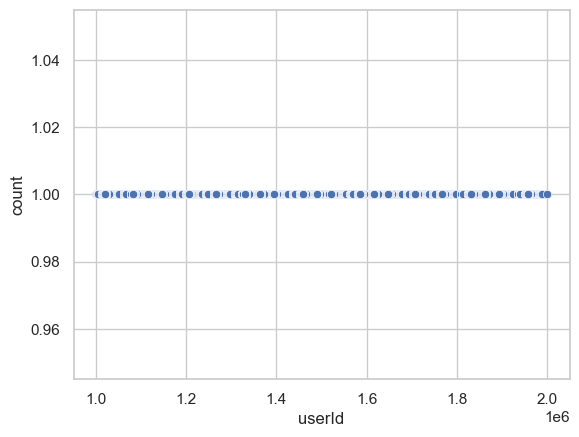

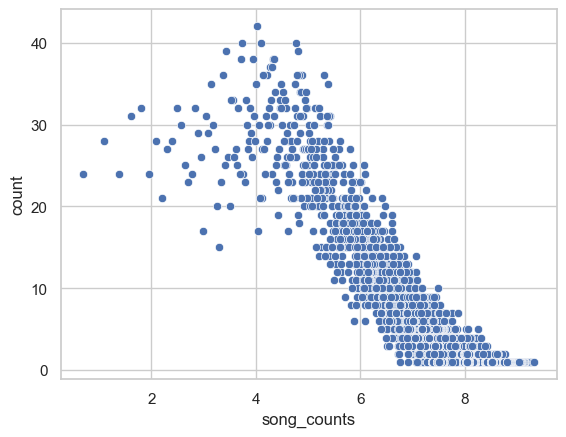

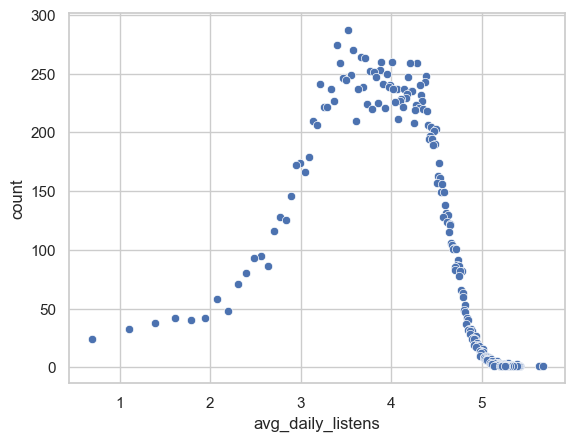

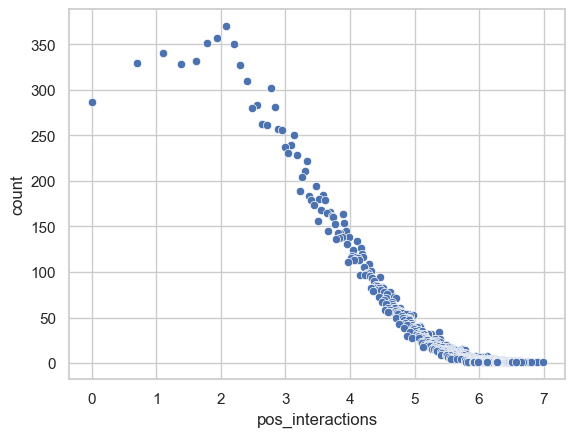

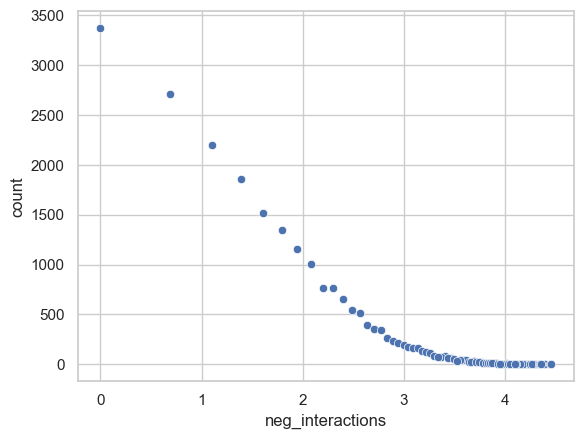

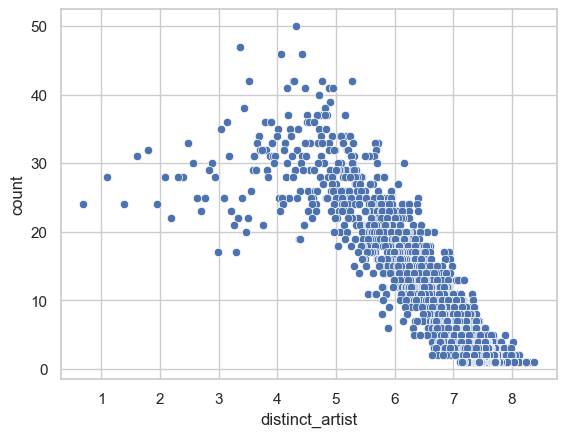

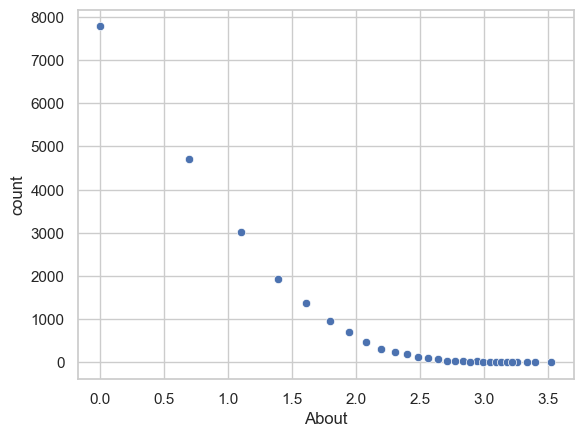

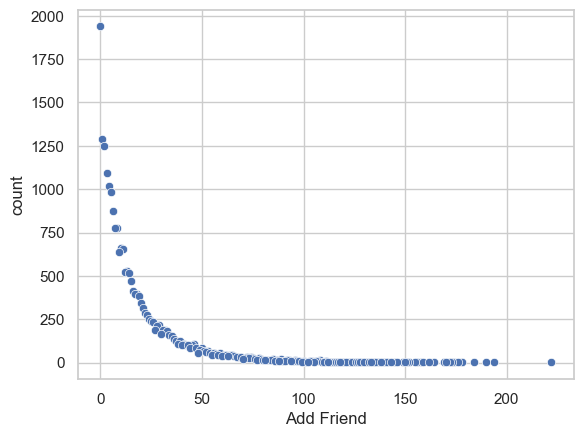

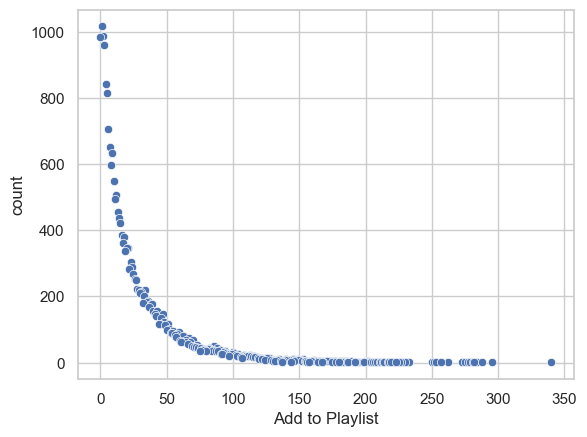

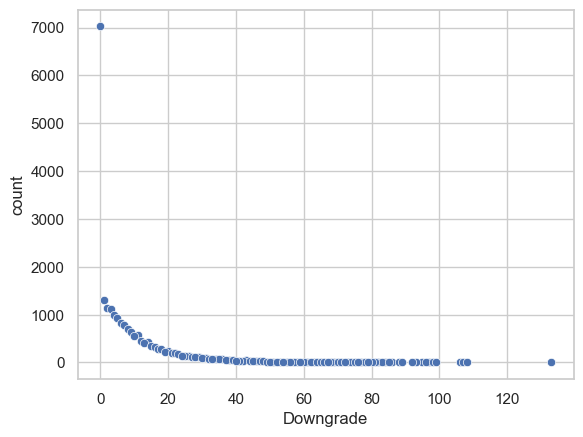

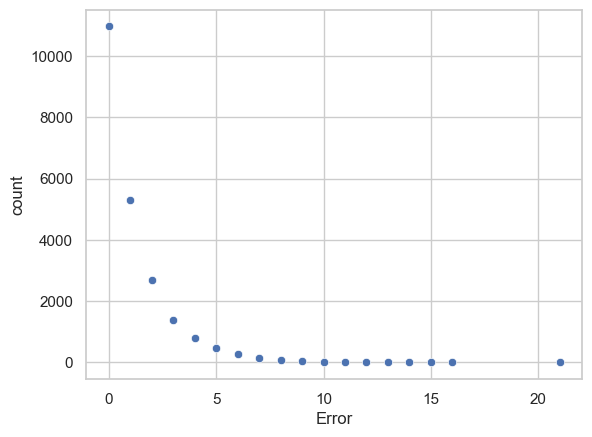

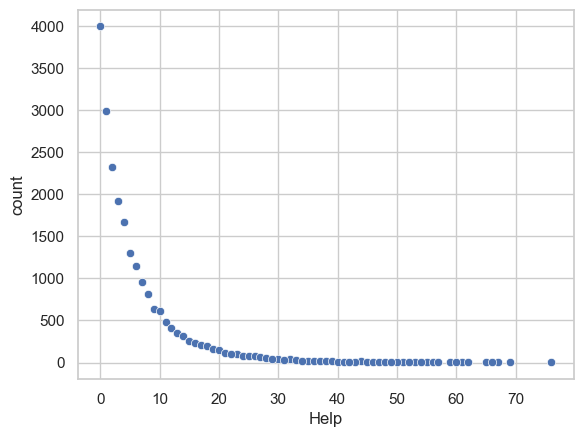

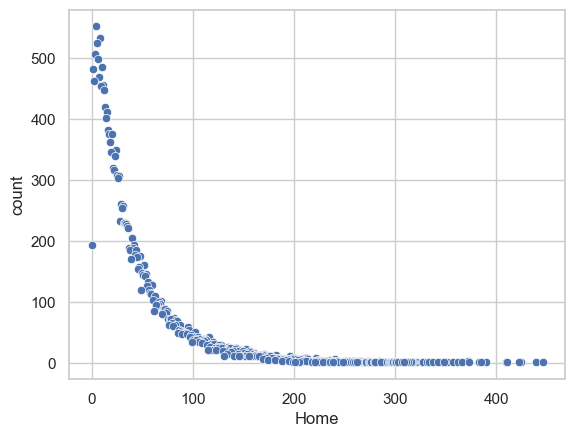

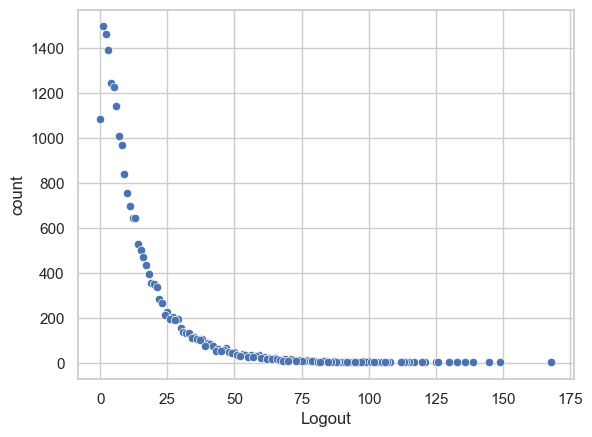

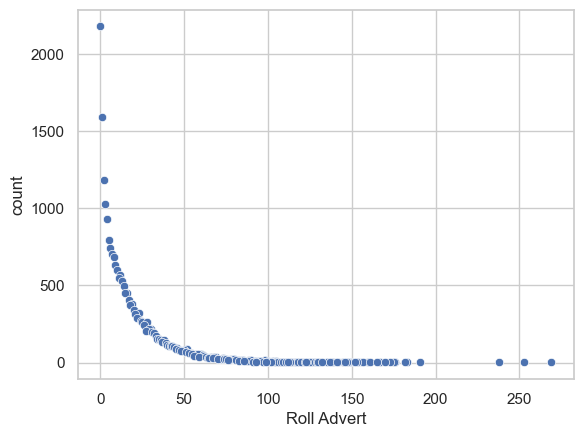

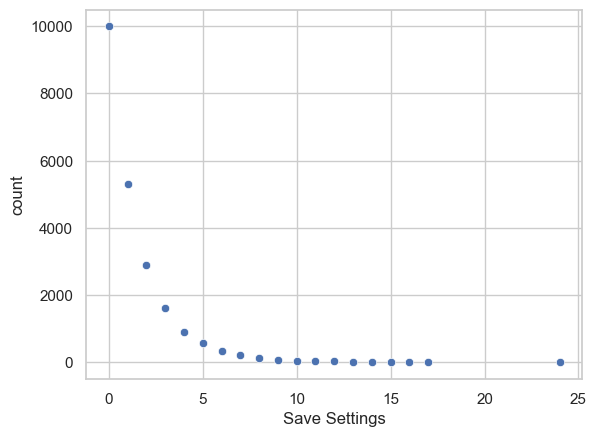

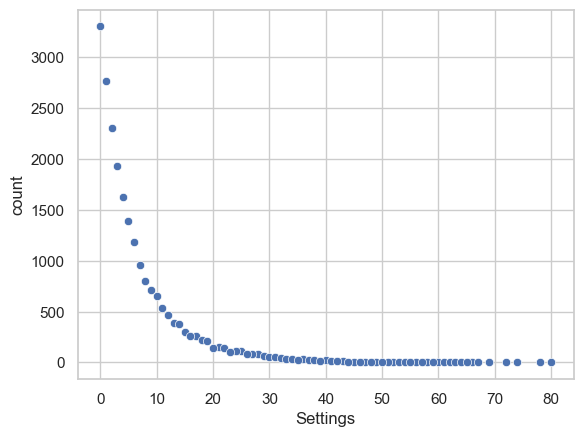

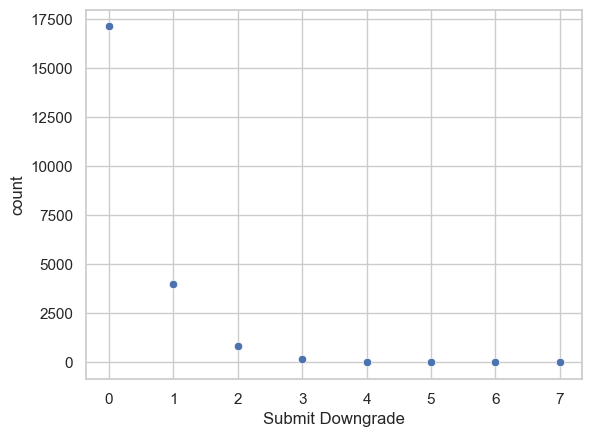

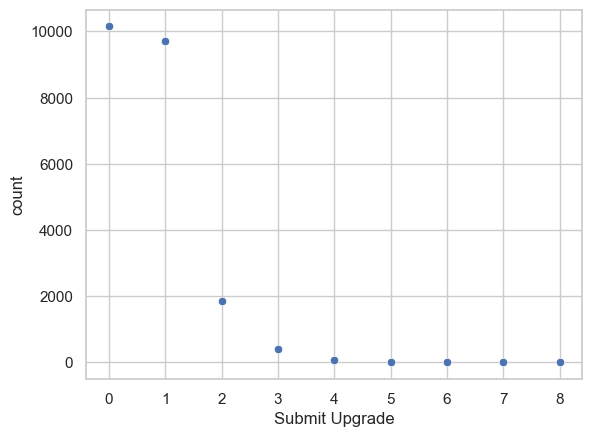

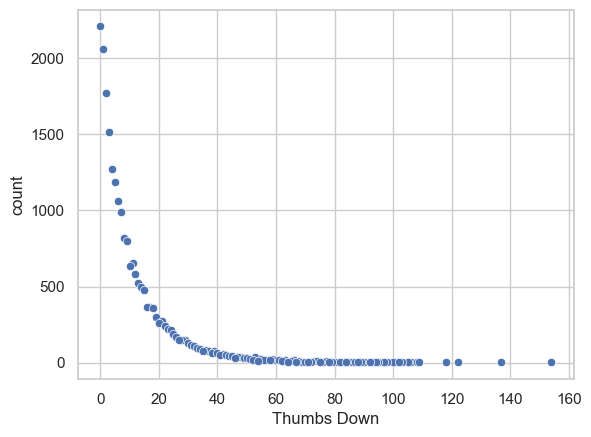

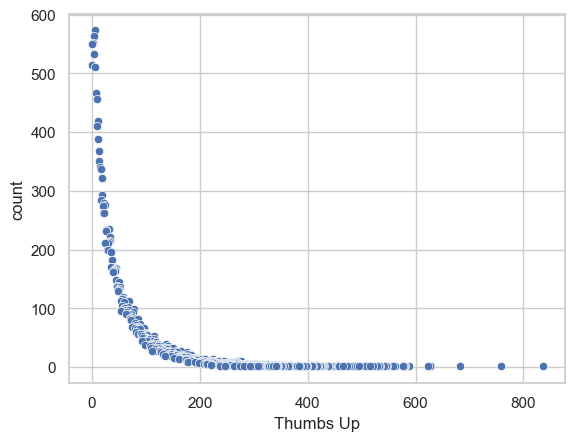

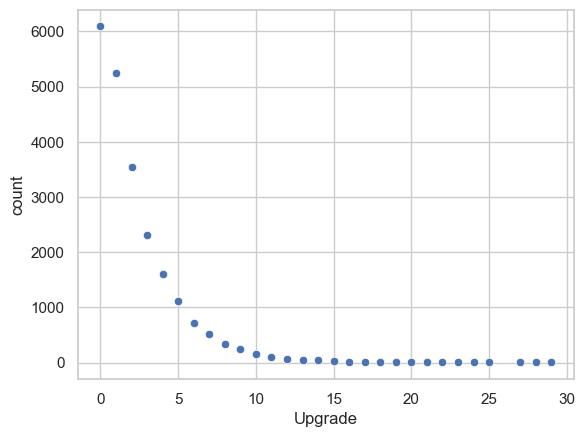

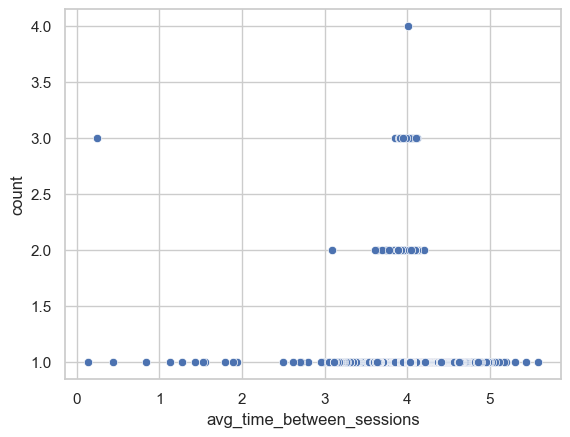

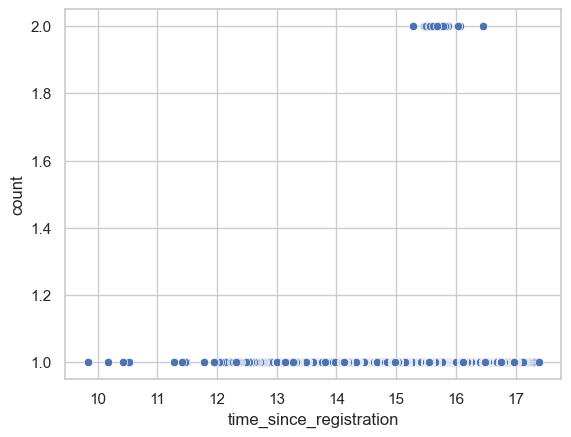

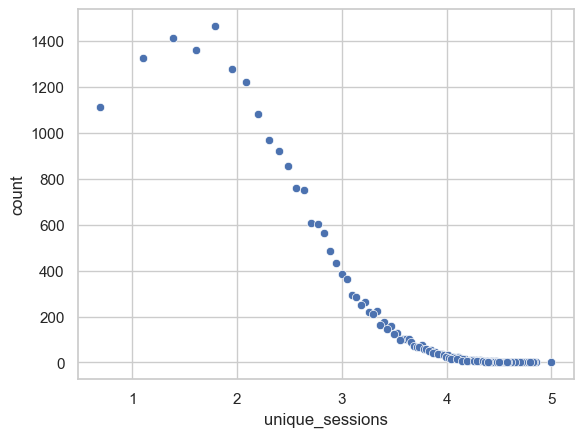

In [80]:

for col in df.columns:
    if df[col].nunique() > 2:
        data = df[[col]].value_counts().reset_index()
        sns.scatterplot(data=data,x= col,y = "count")# ,bins=round(data.shape[0]))
        plt.show()

## Feature Correalations

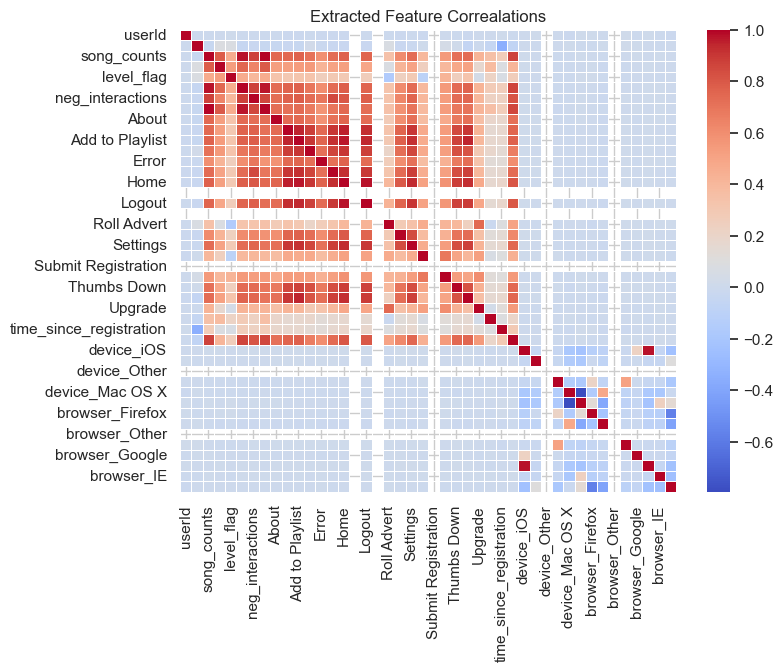

In [81]:
df_corr = df.corr()

# df_corr = df_corr[df_corr >.8]

plt.figure(figsize=(8, 6))
sns.heatmap(df_corr, annot=False, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Extracted Feature Correalations")
plt.show()

##  Feature Distributions

In [82]:
def display_distributions(df):
    sns.set(style="whitegrid")

    numerical_columns = [col for col in df.columns if df[col].nunique() > 2]
    num_numerical_columns = len(numerical_columns)
    
    # Determine the number of rows and columns for subplots
    num_rows = (num_numerical_columns - 1) // 3 + 1
    num_cols = min(3, num_numerical_columns)

    plt.figure(figsize=(15, 5 * num_rows))

    for i, column in enumerate(numerical_columns, start=1):
        plt.subplot(num_rows, num_cols, i)
        sns.histplot(df[column], kde=True)
        plt.title(f'Distribution of {column}')

    plt.tight_layout()
    plt.show()

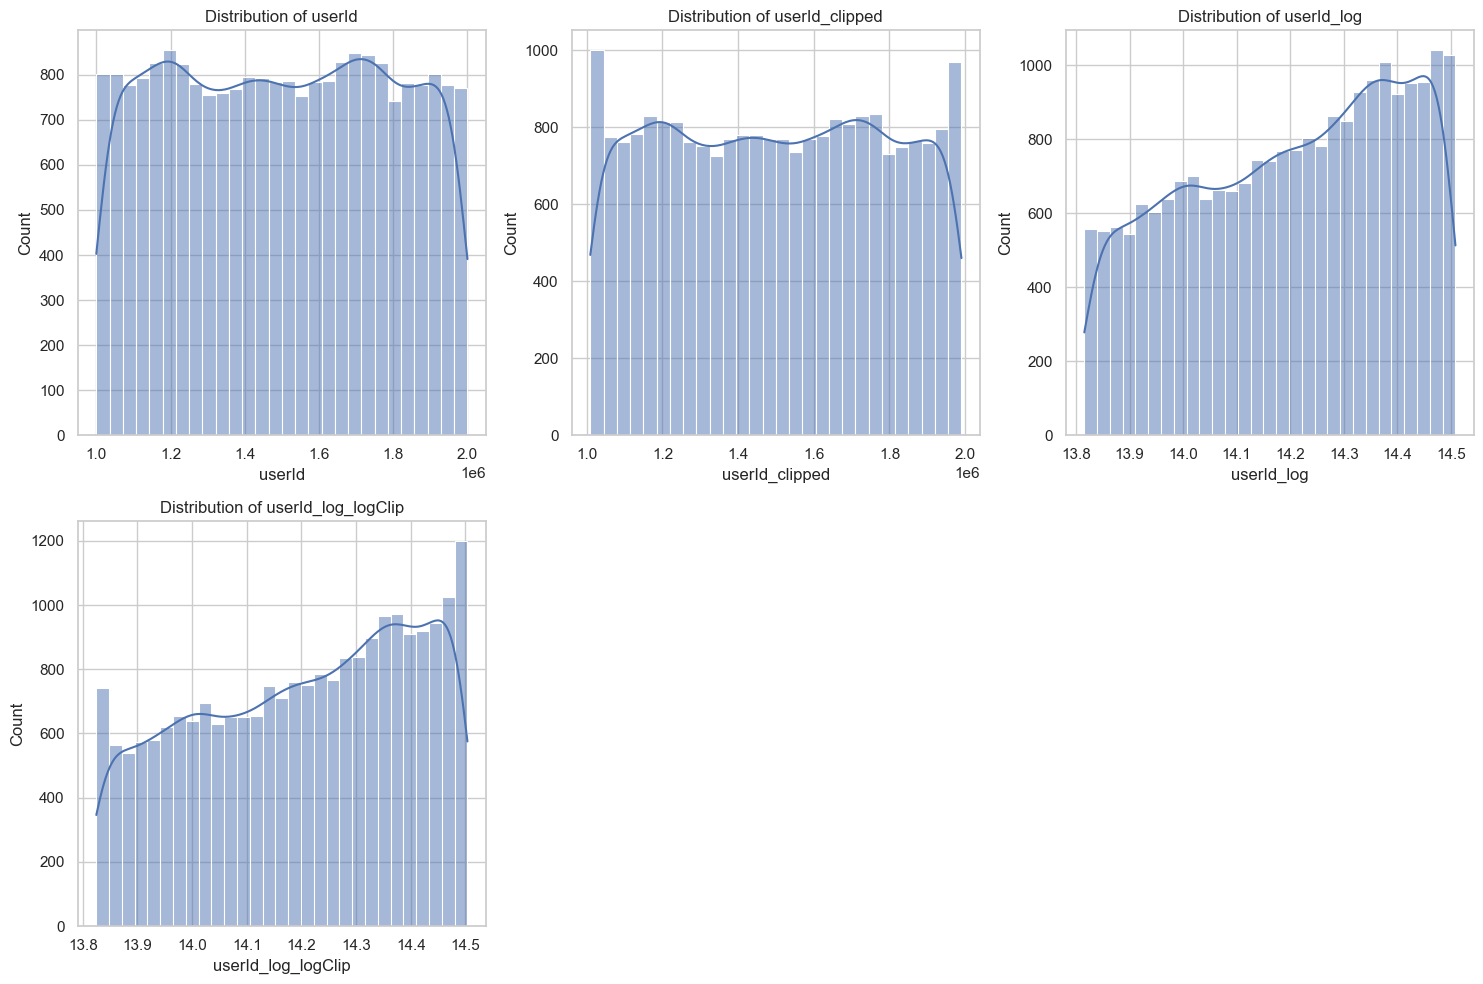

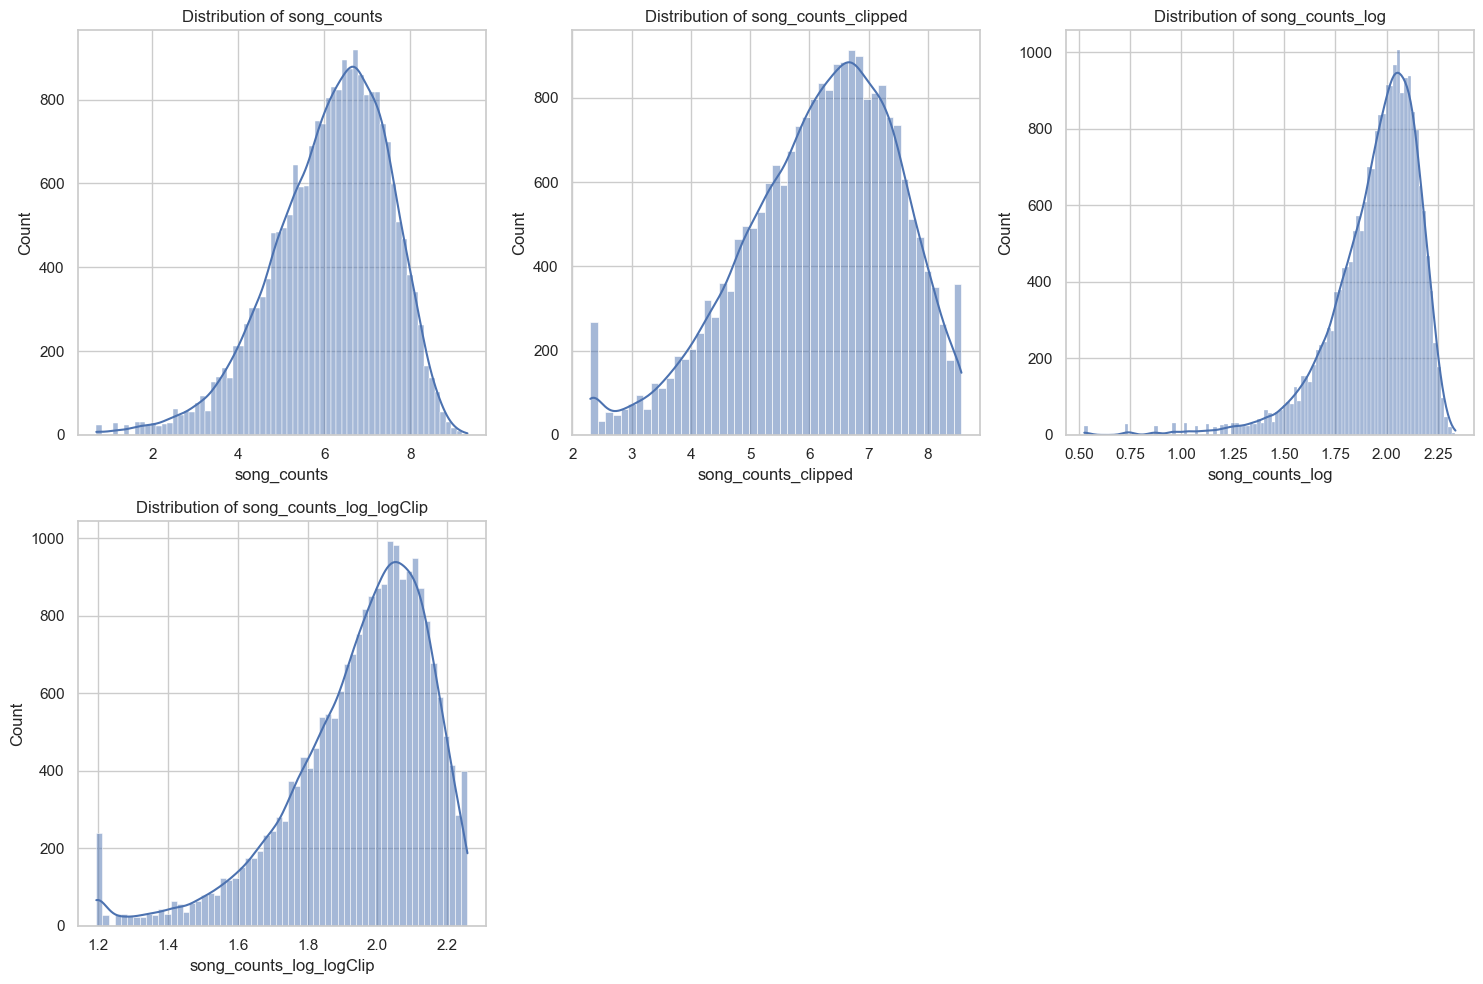

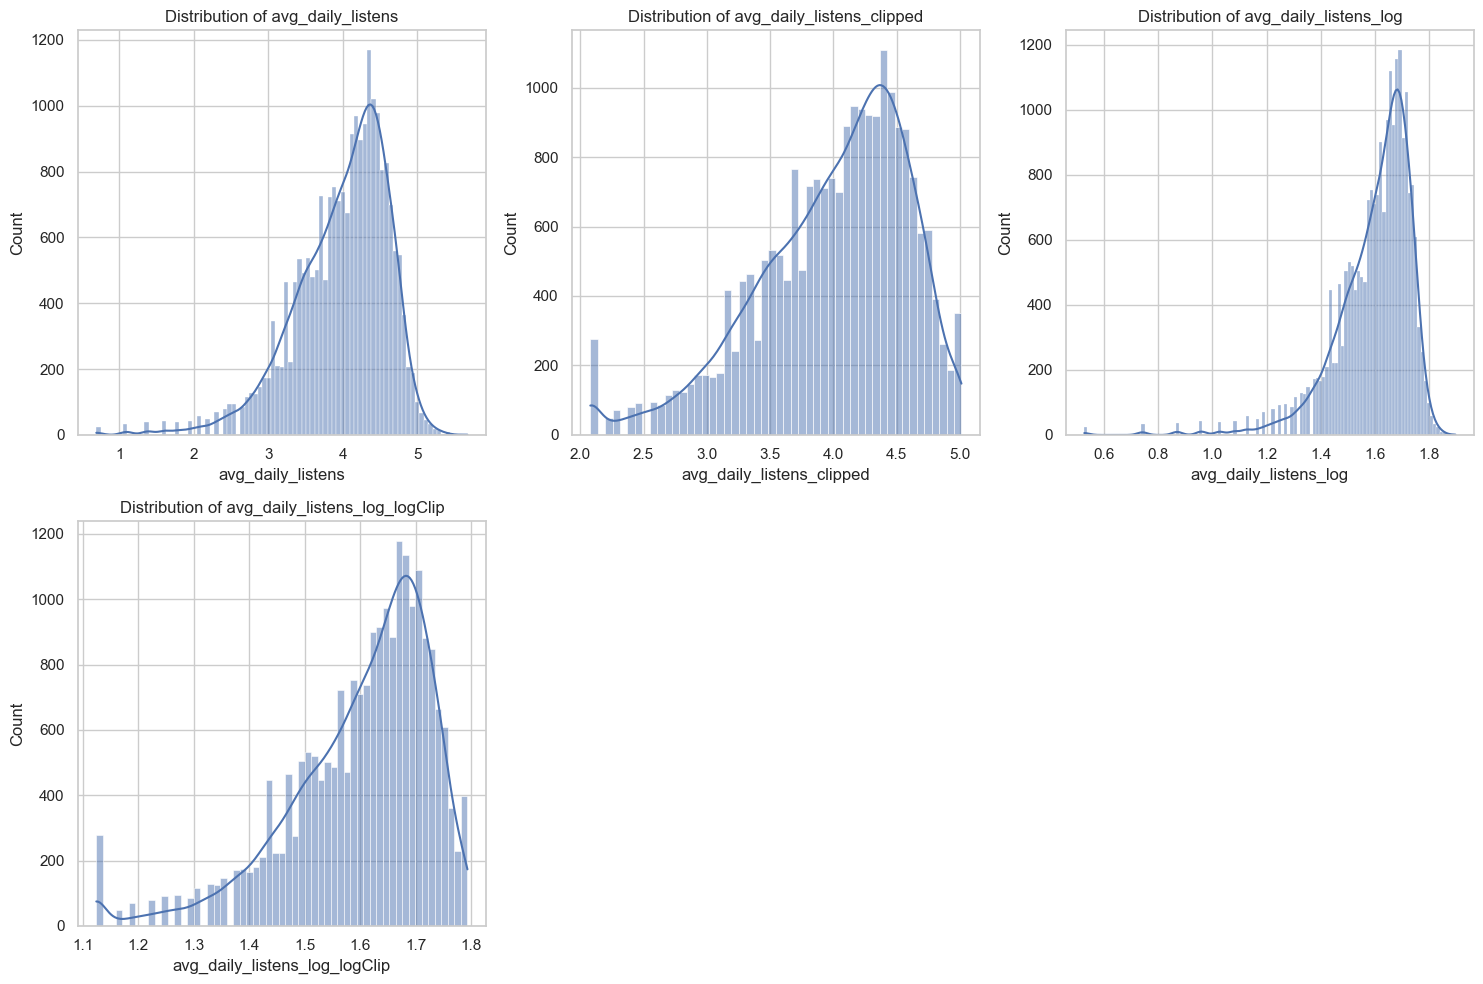

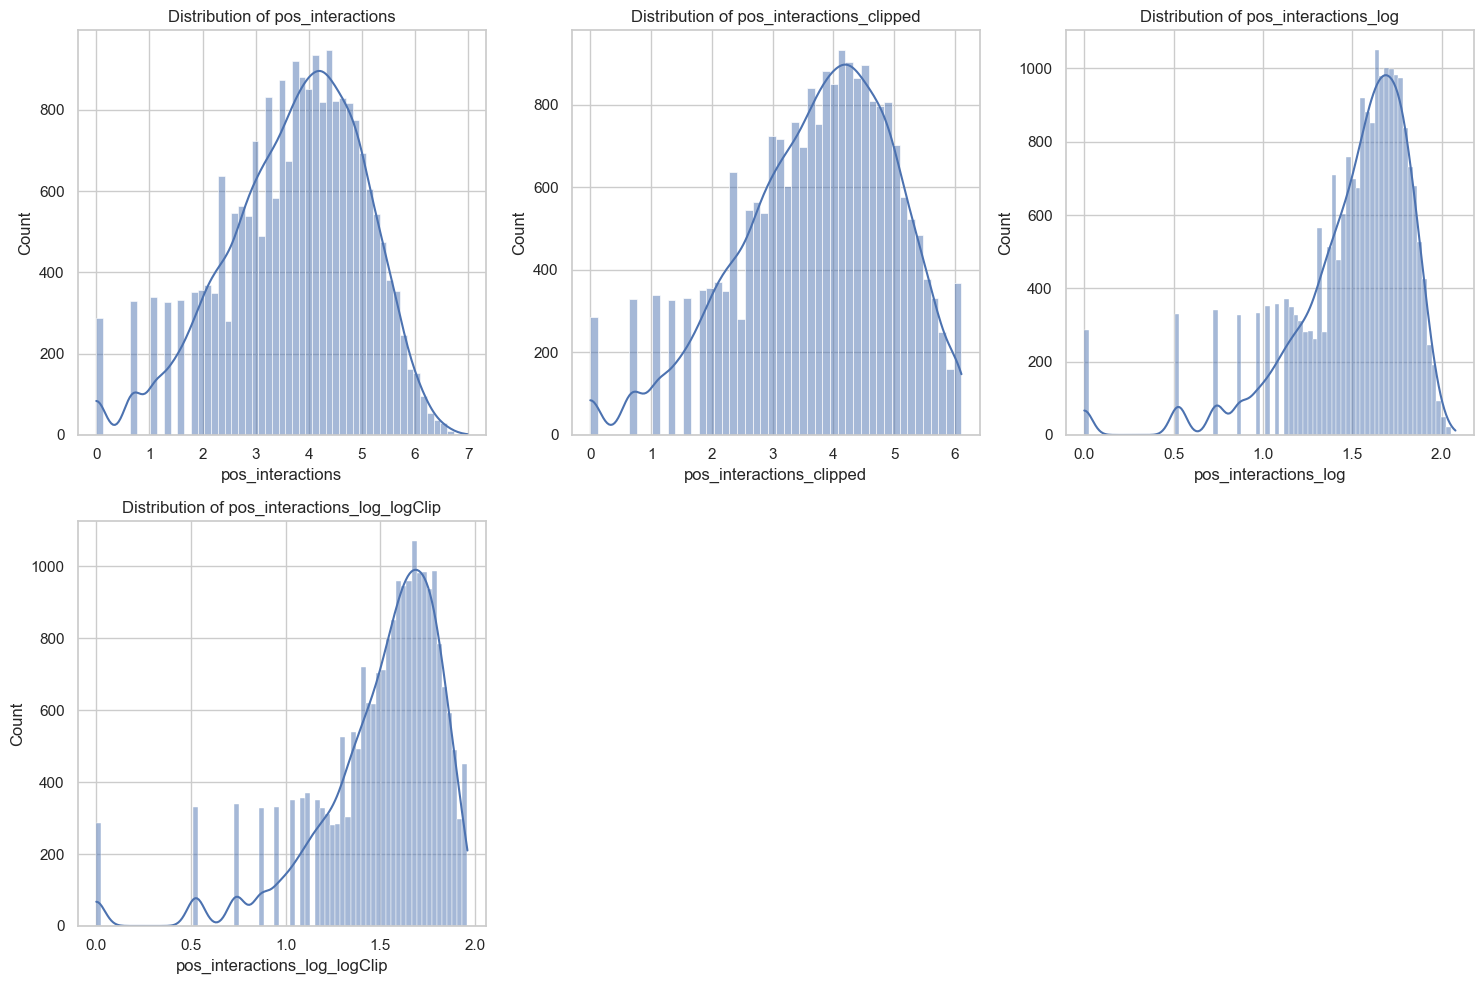

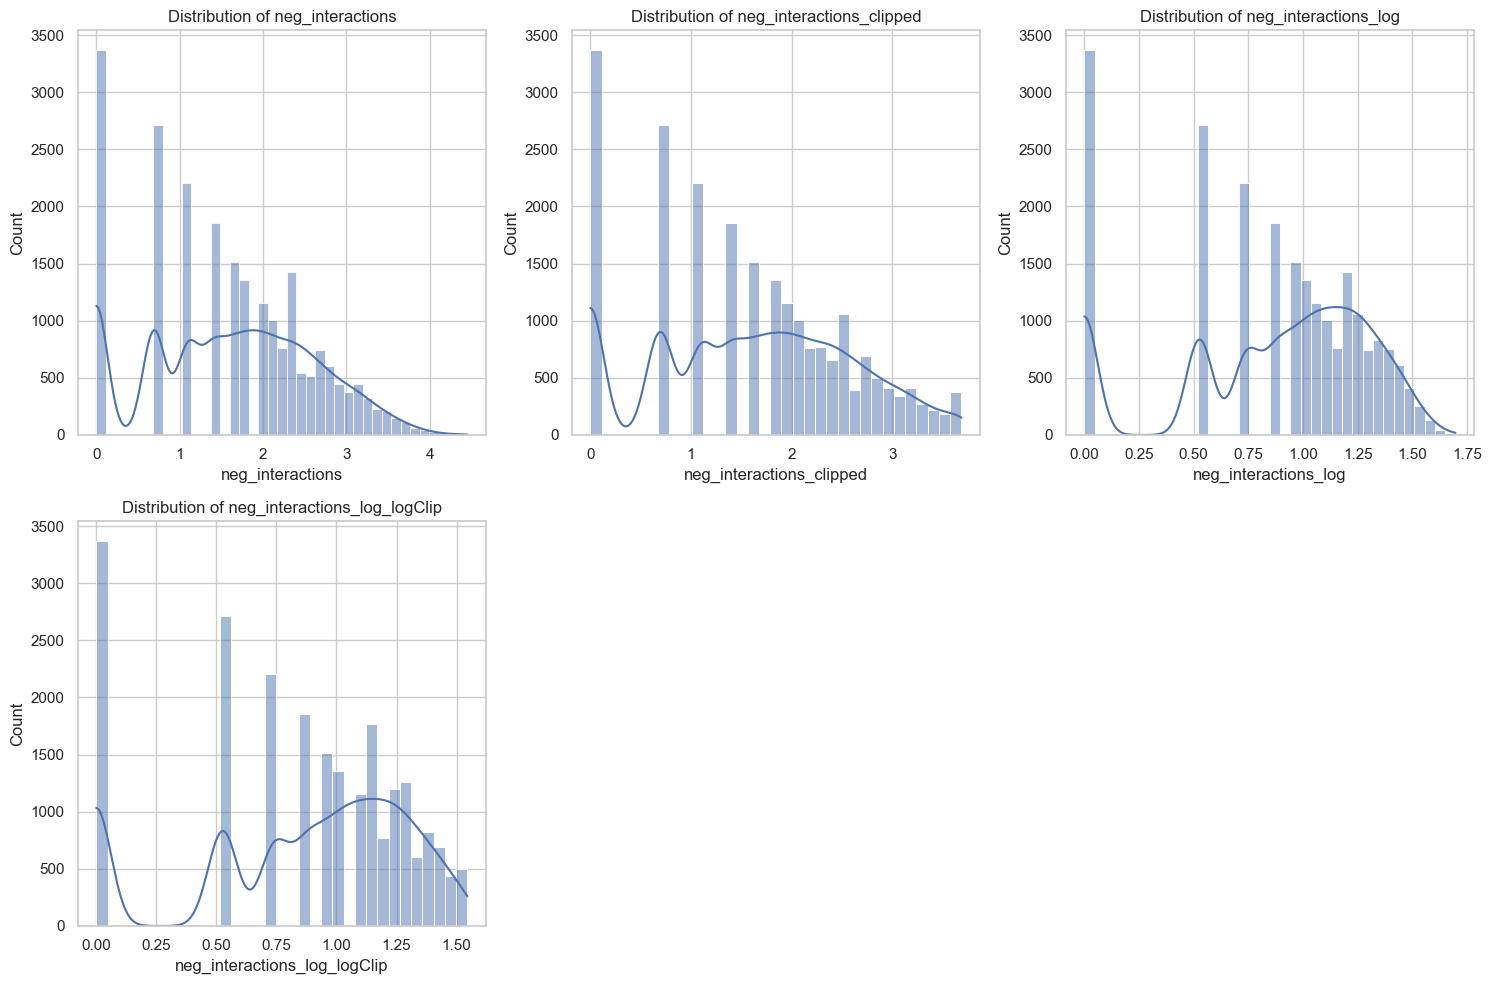

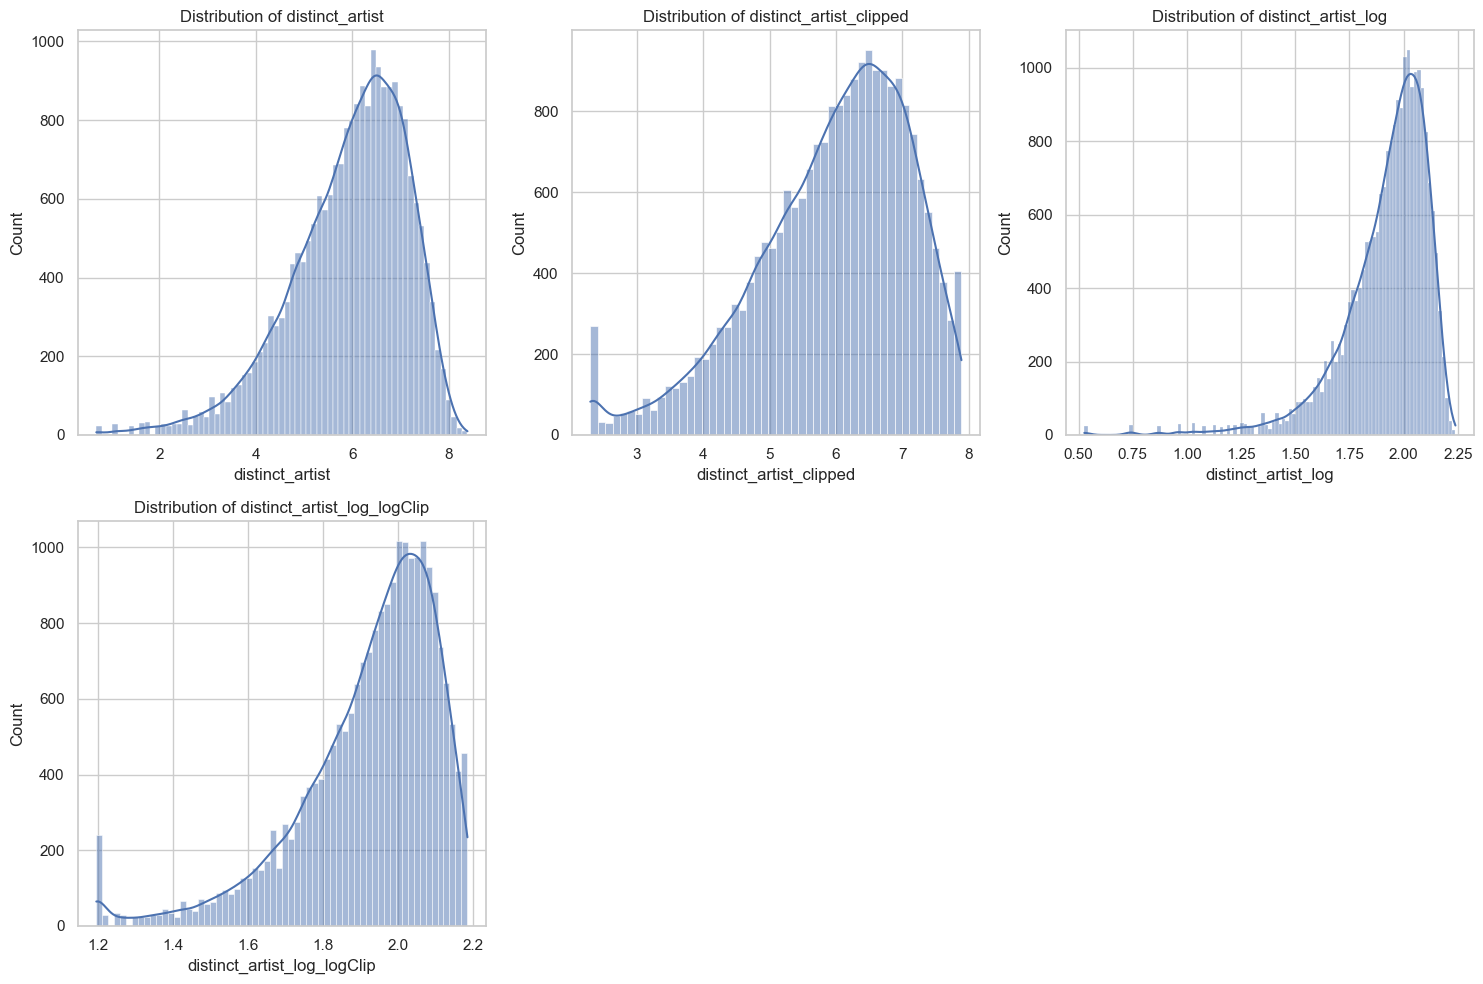

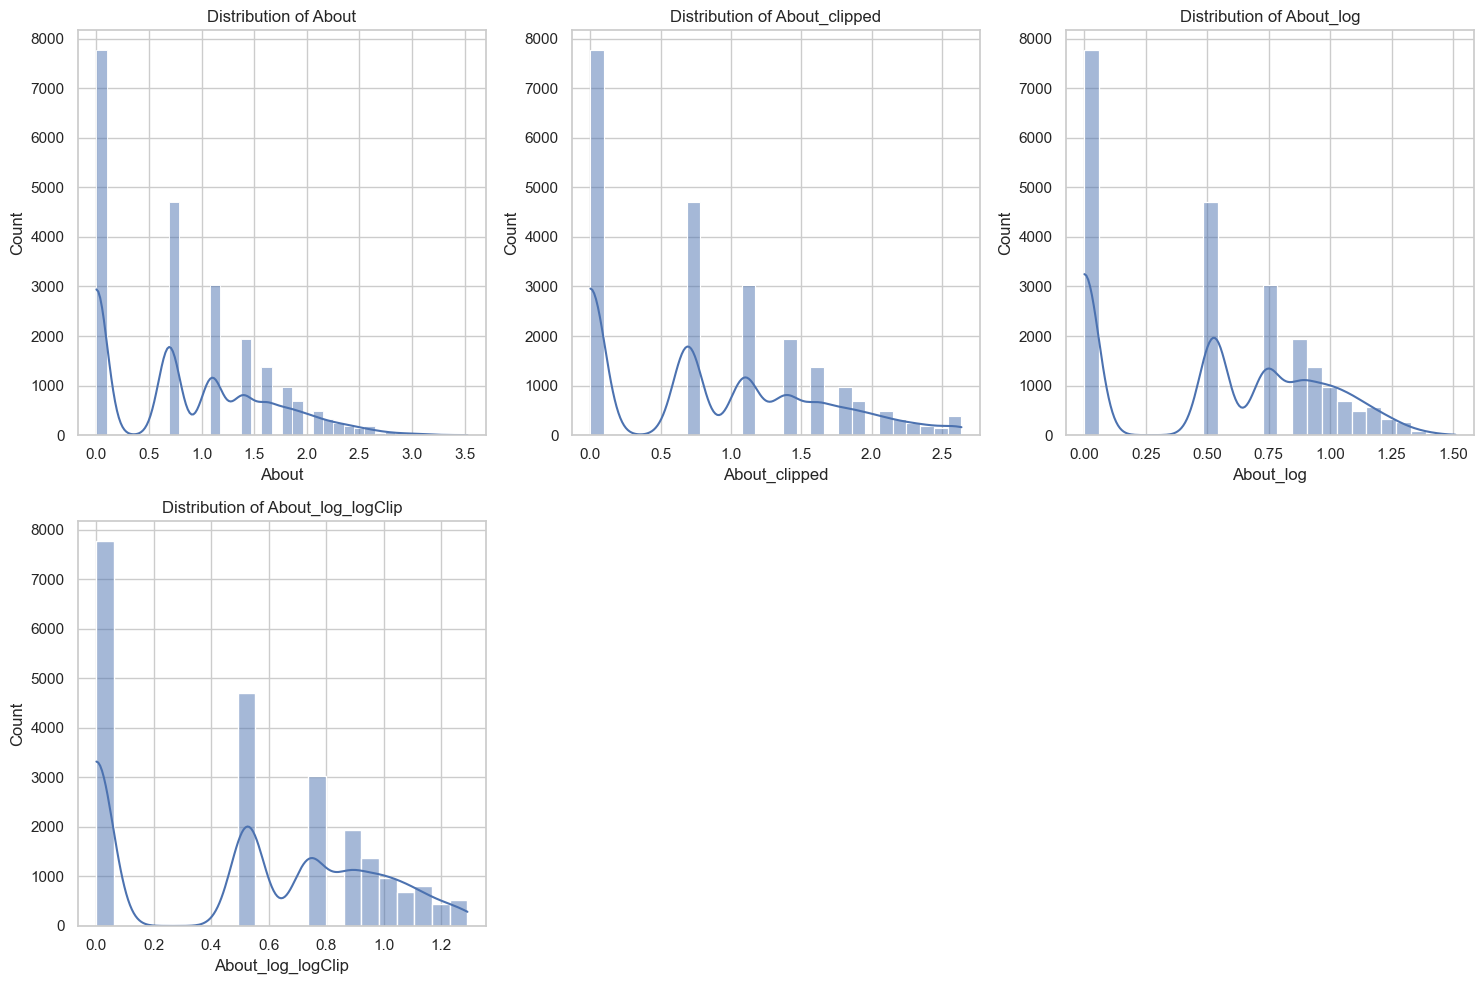

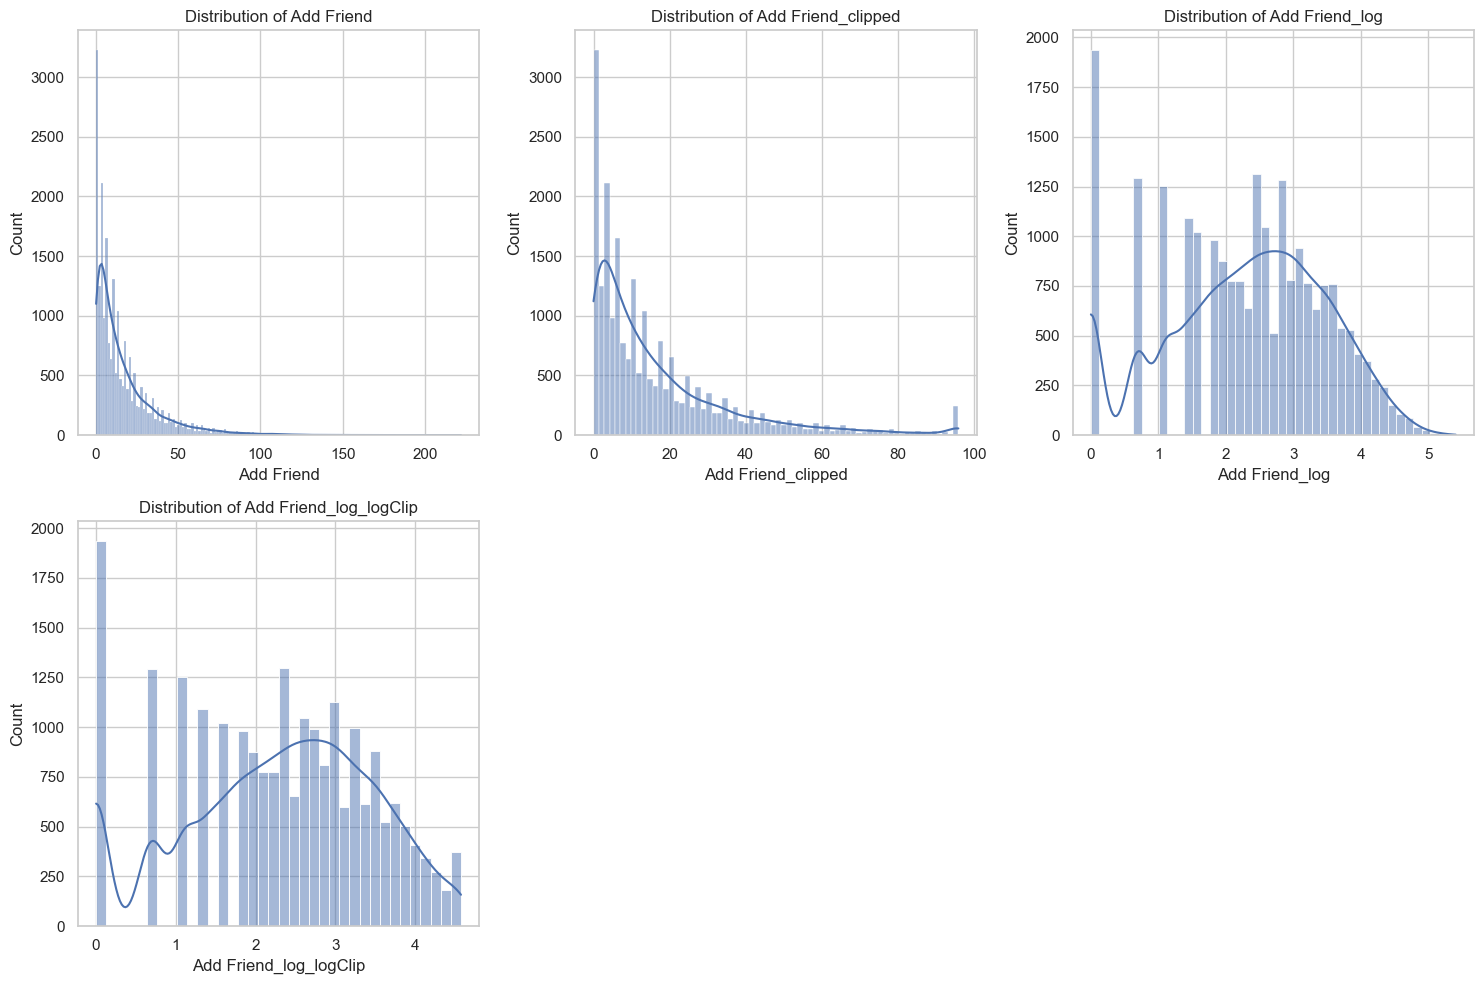

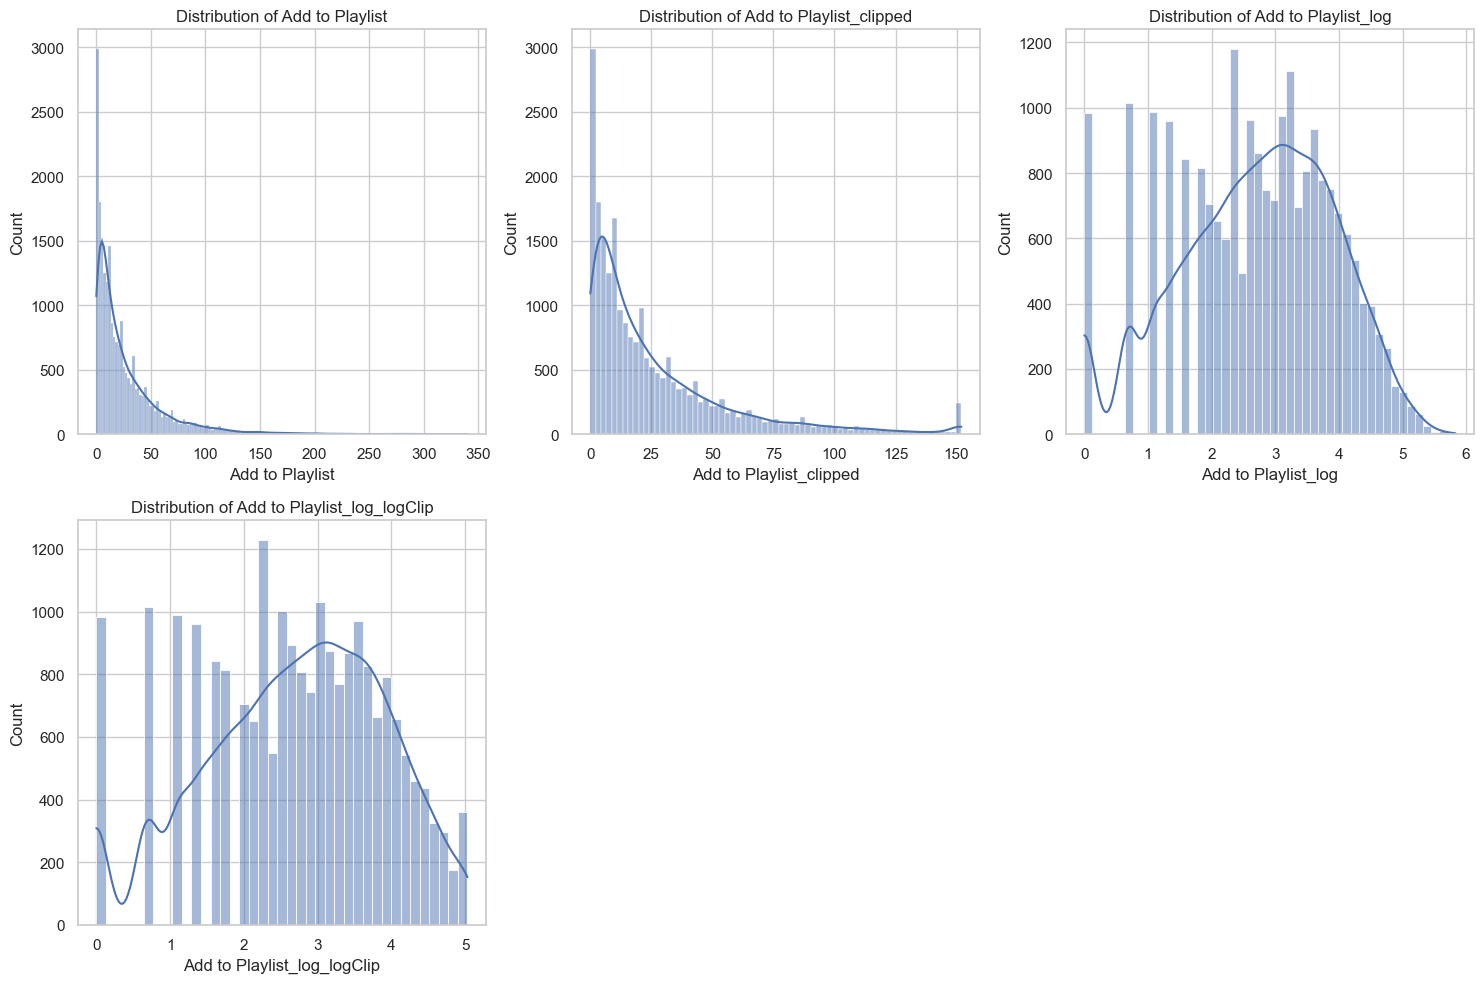

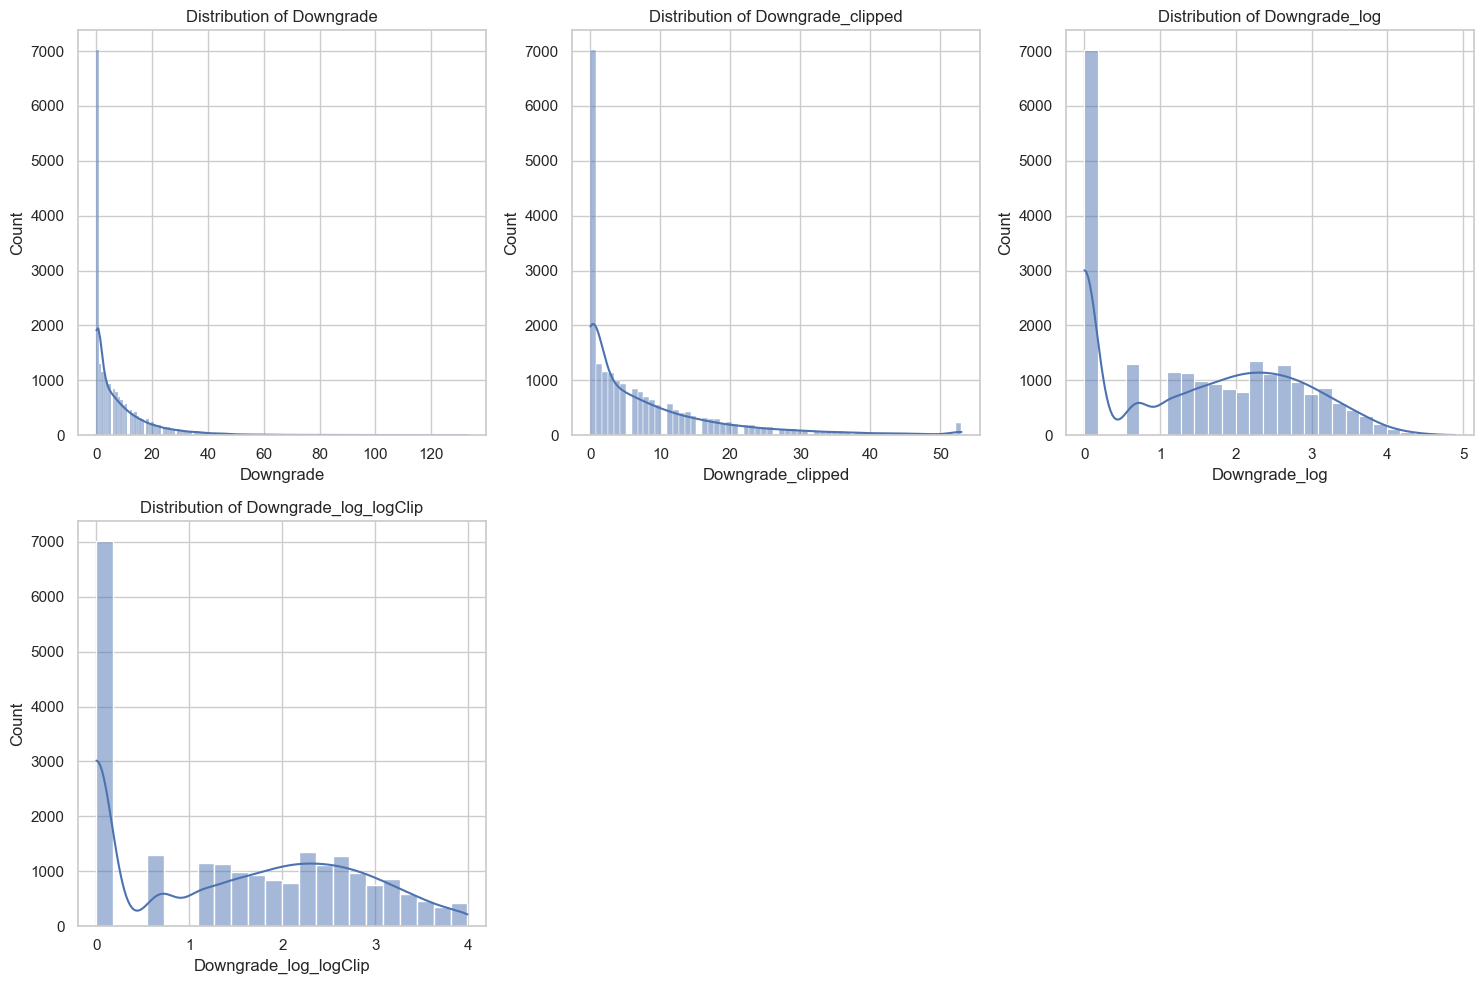

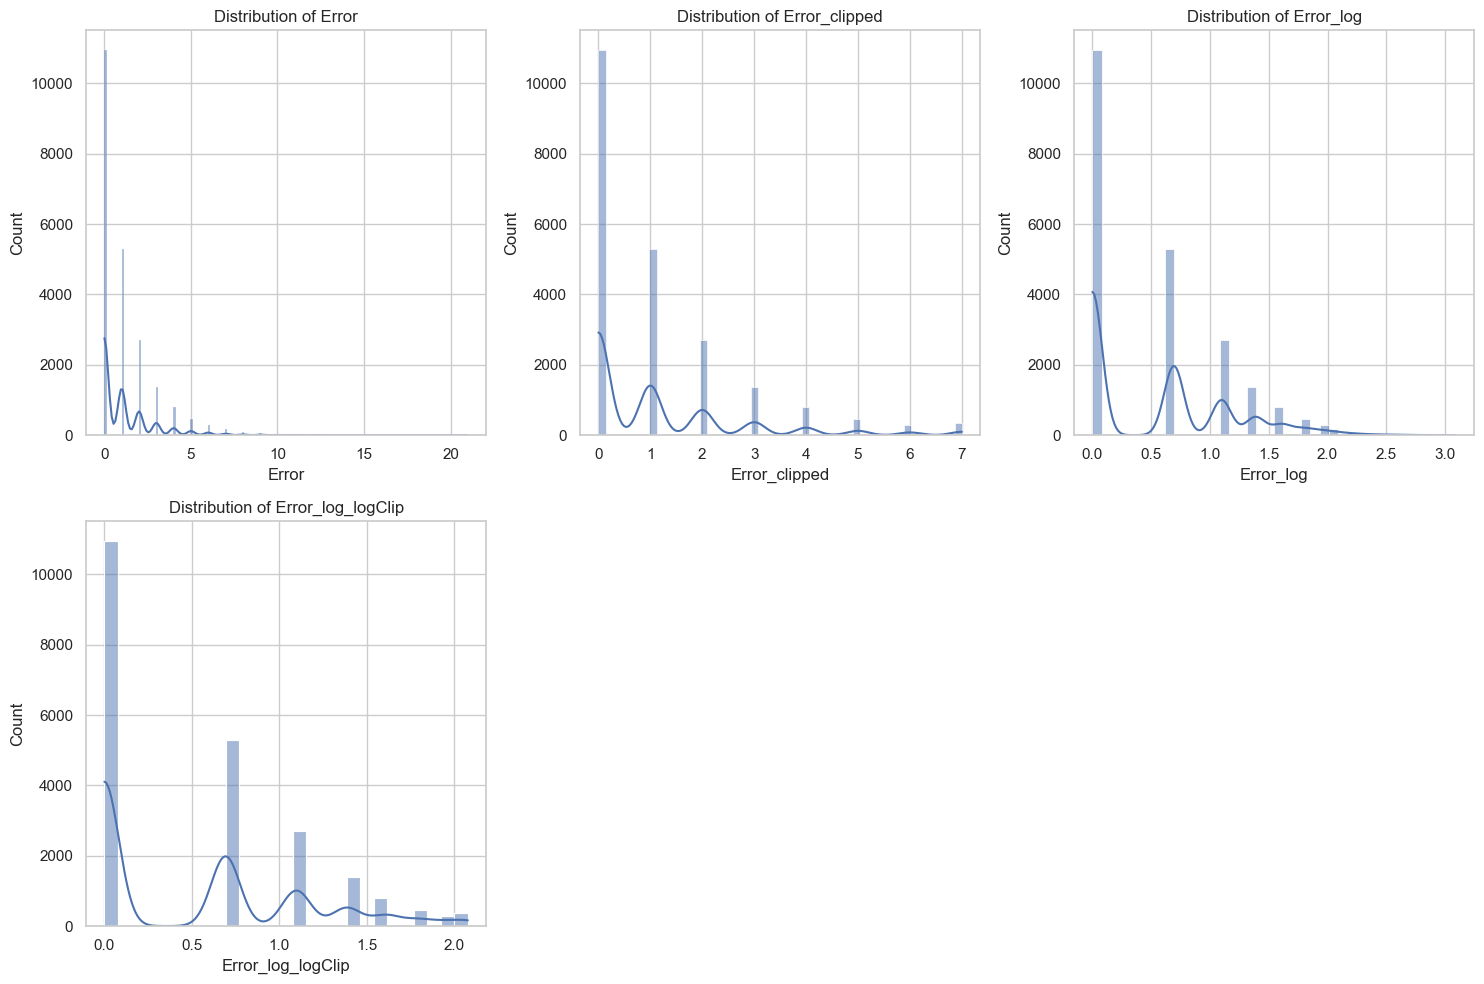

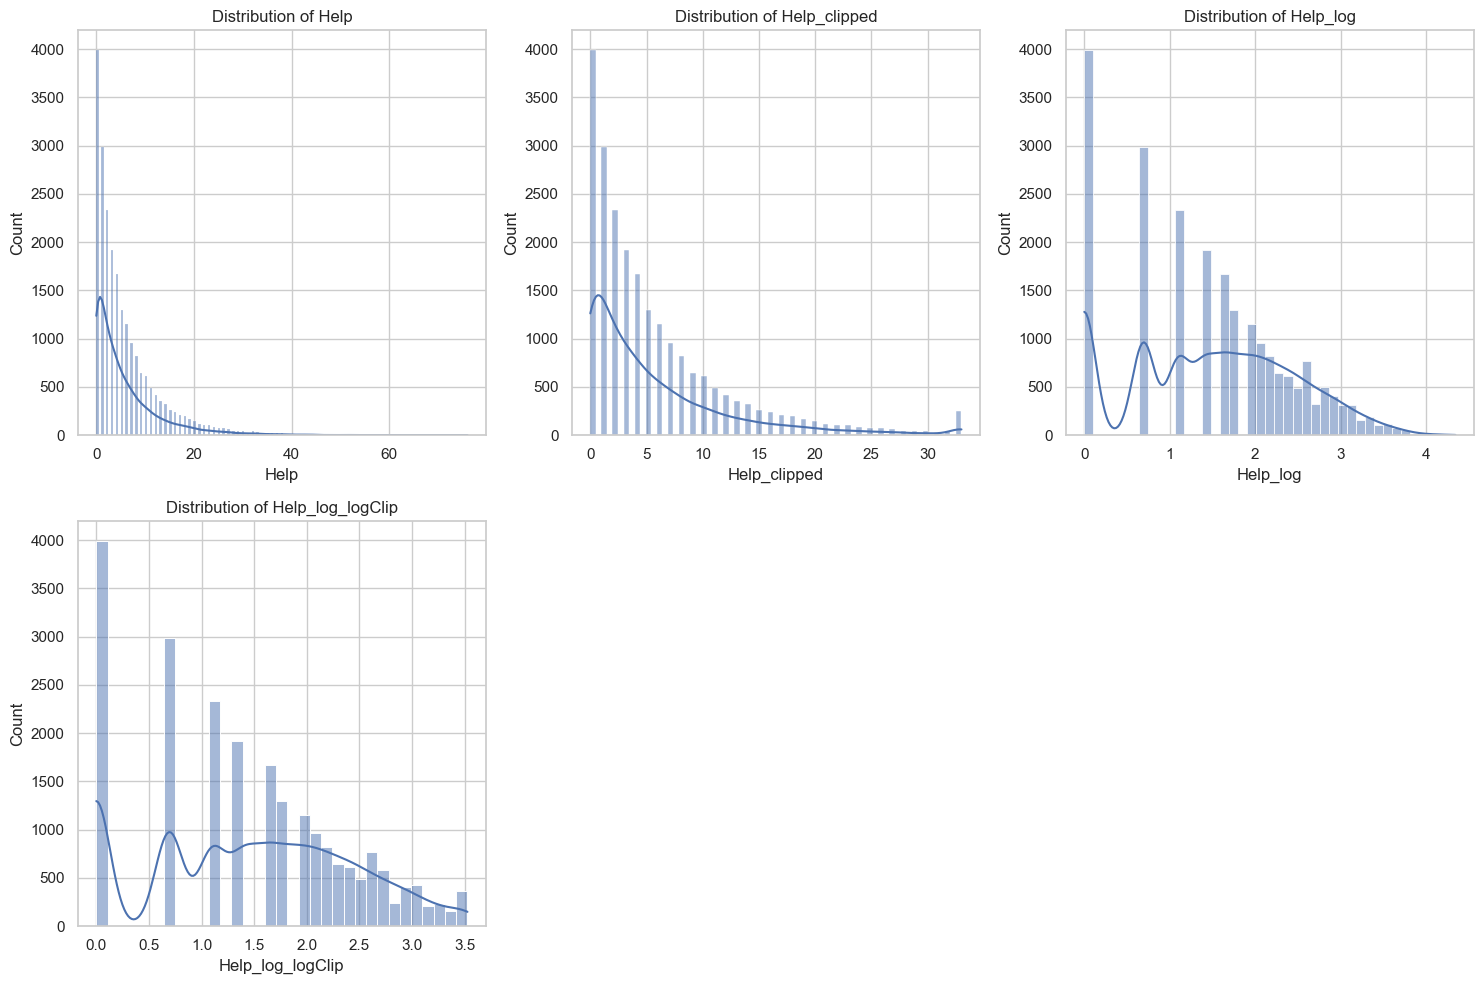

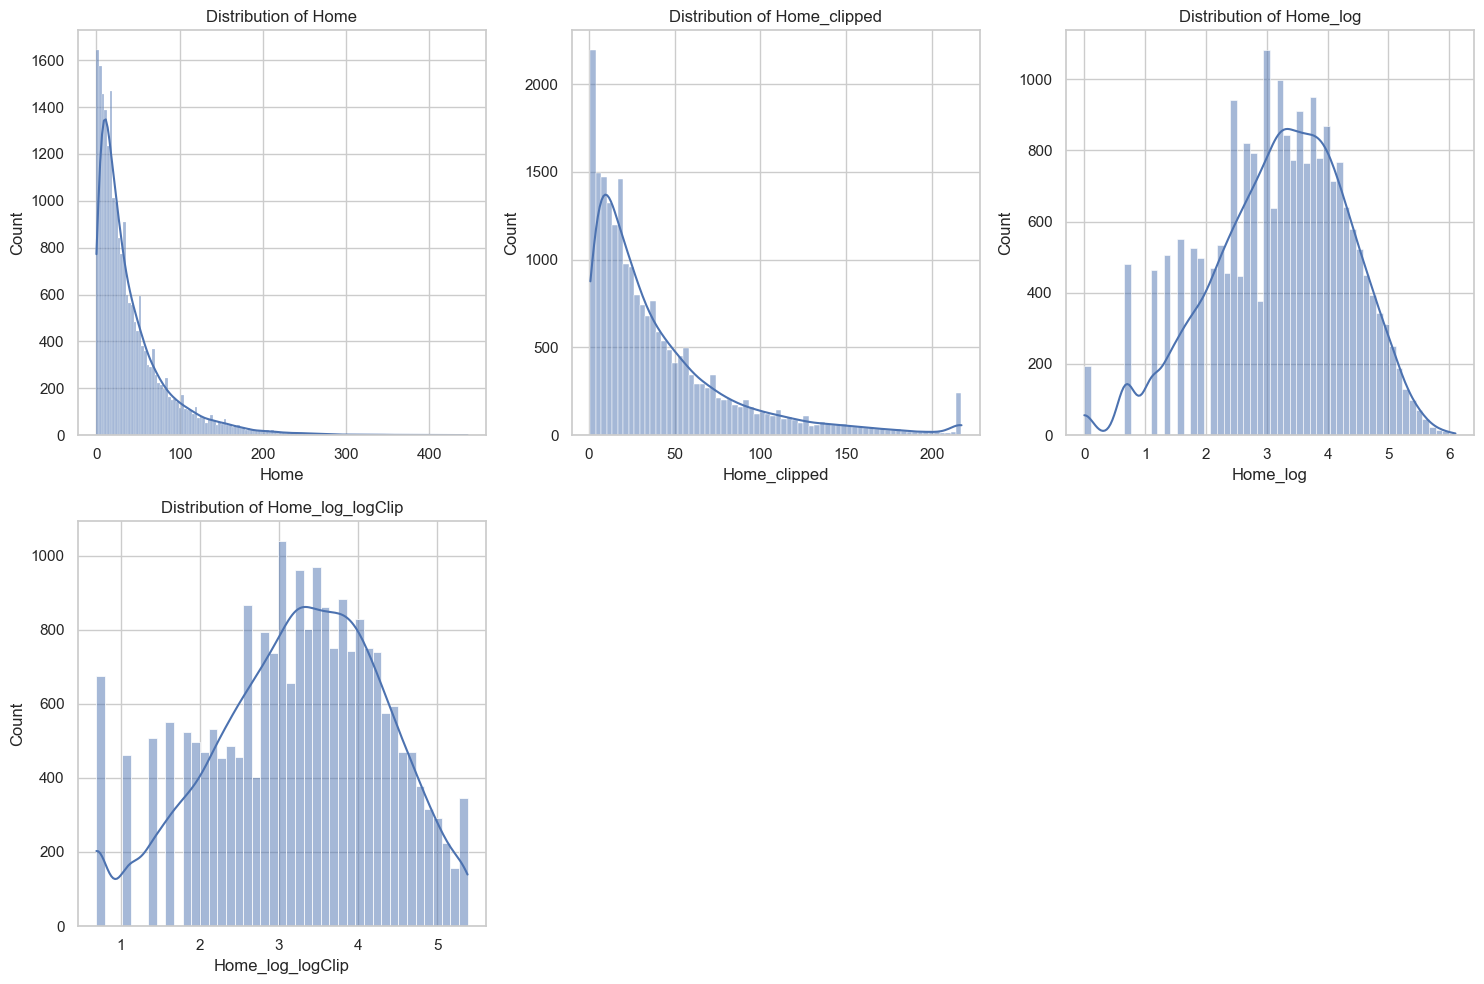

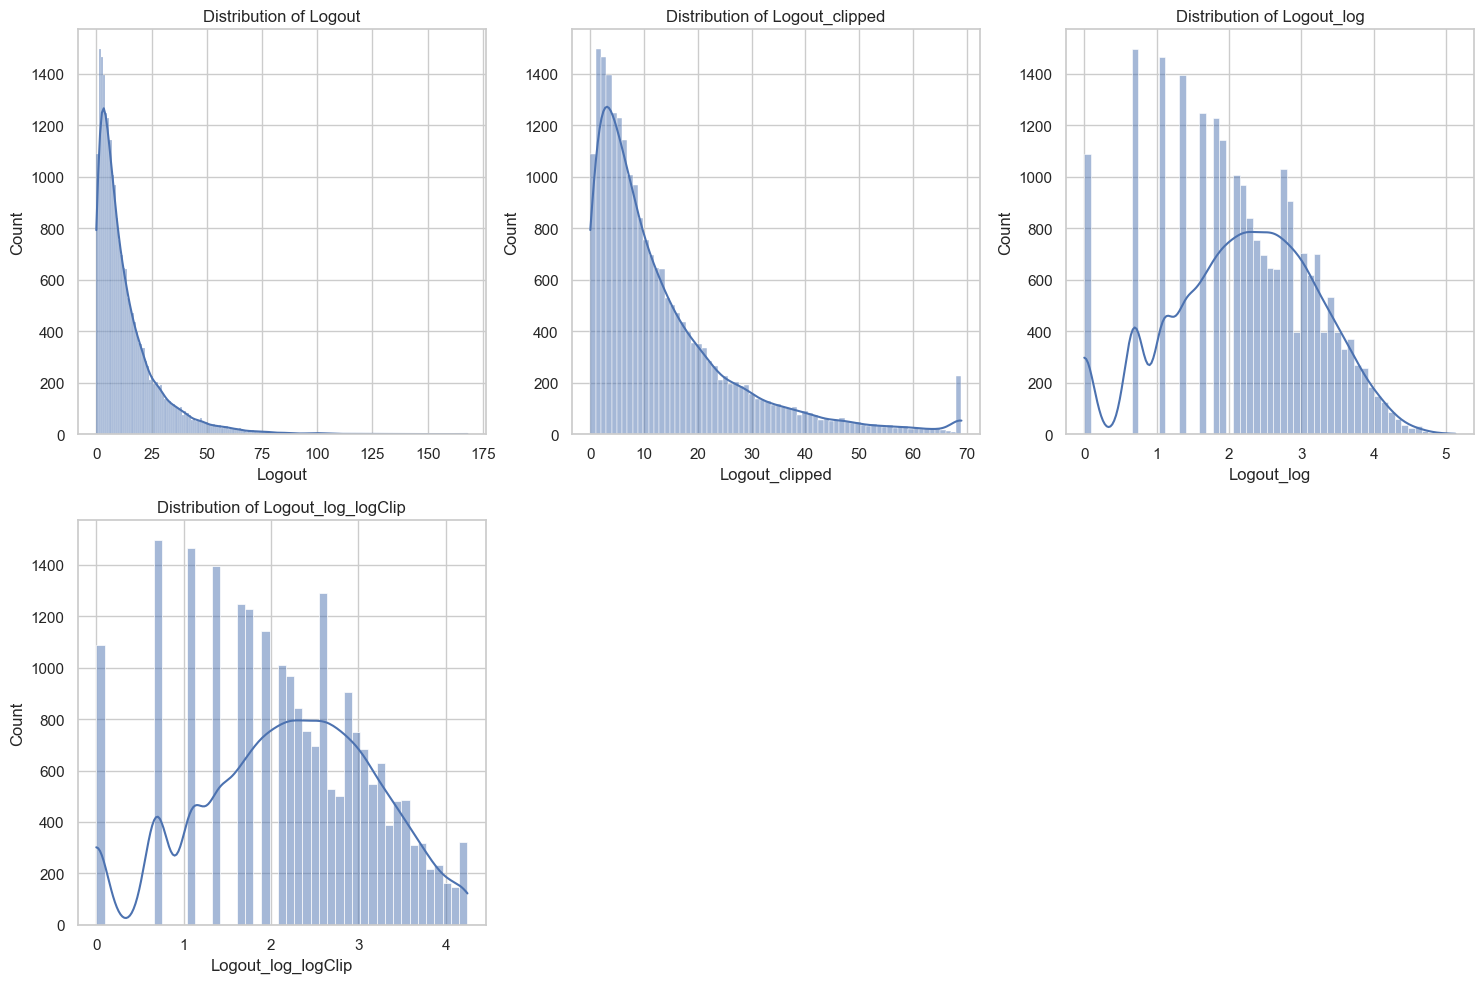

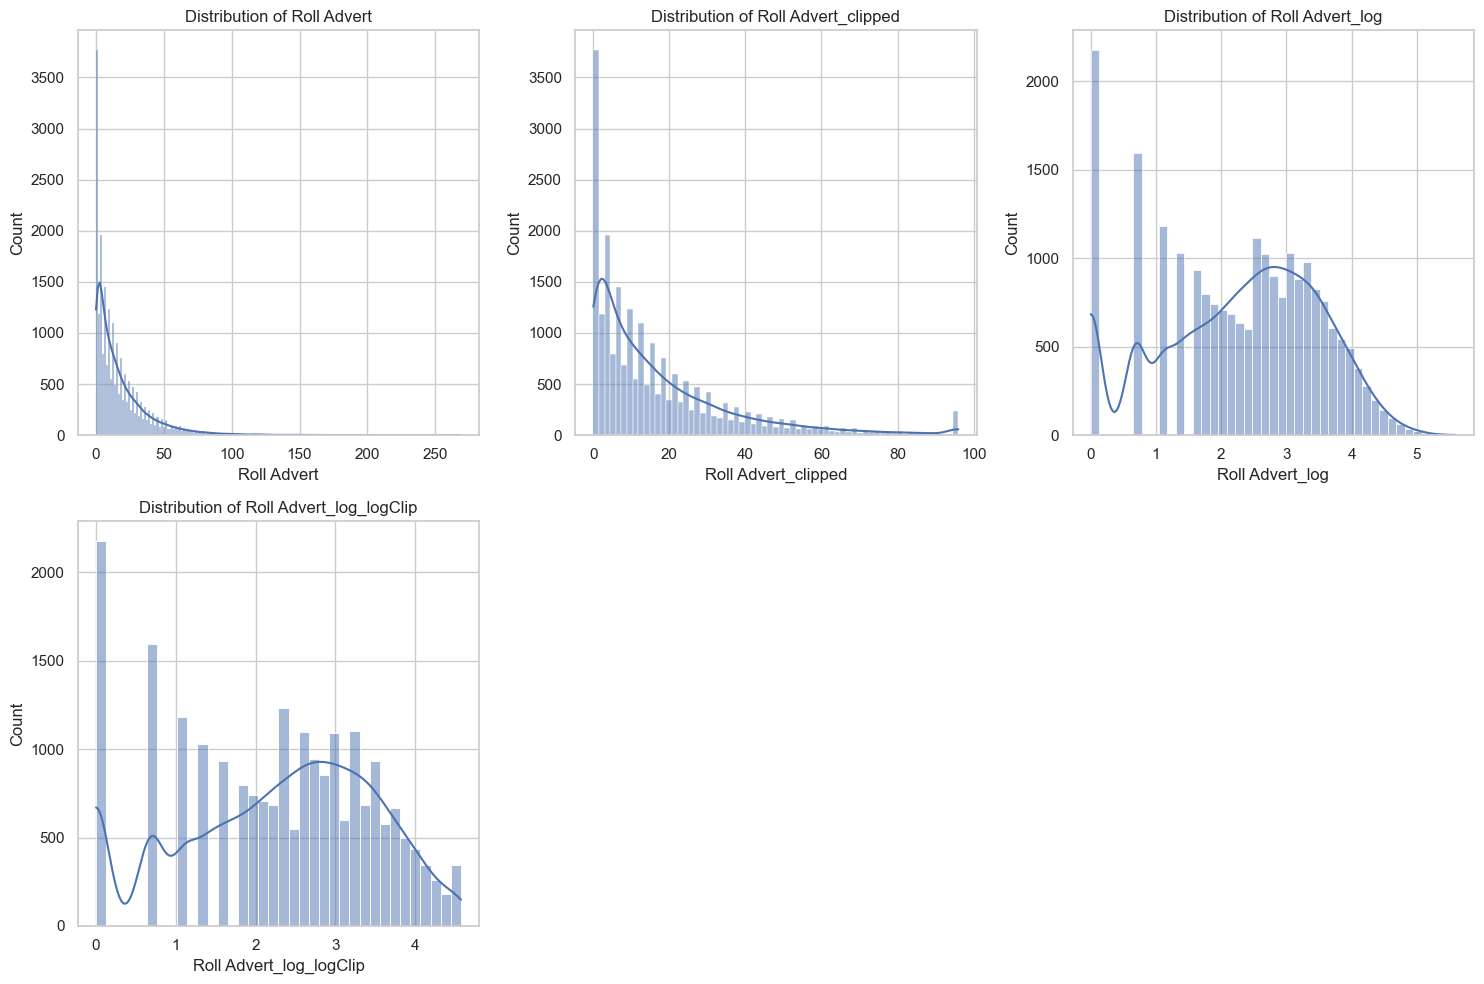

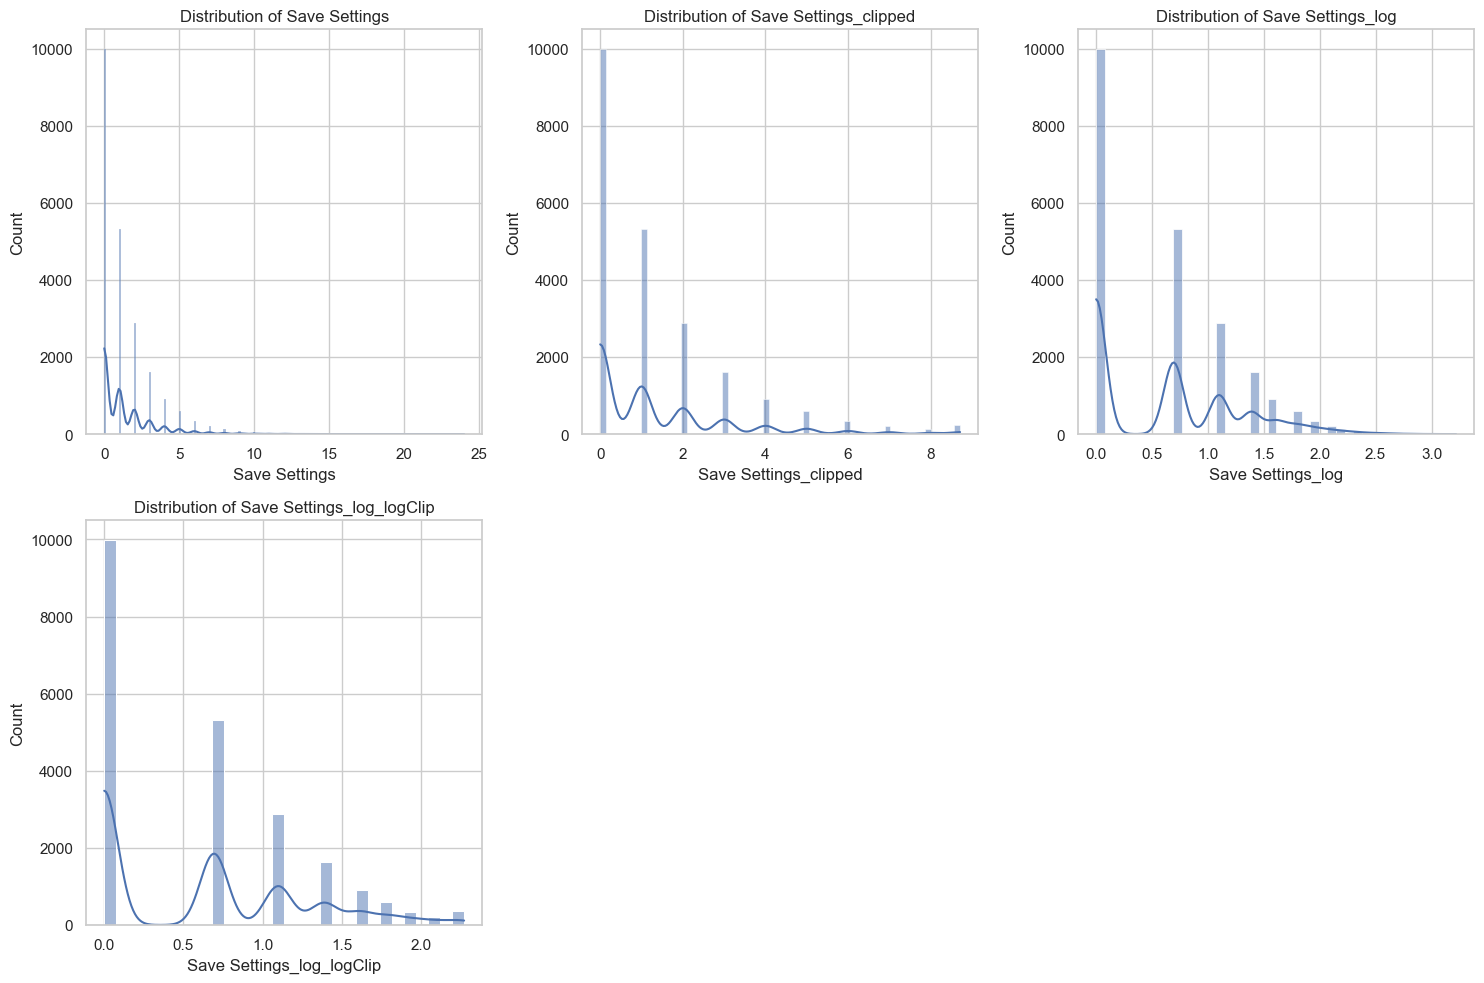

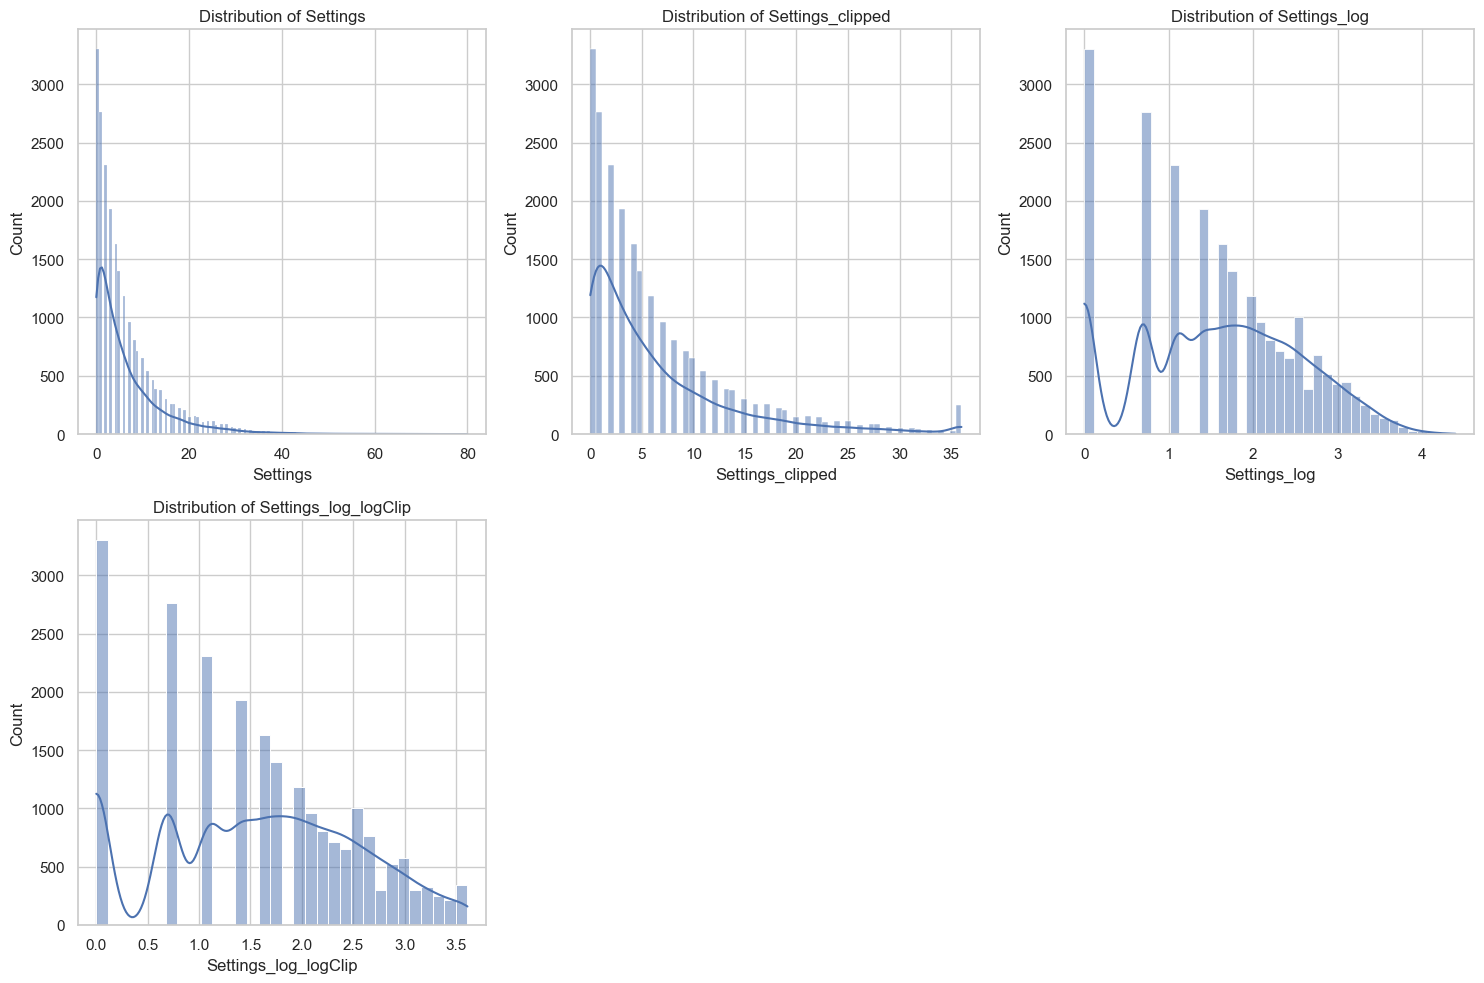

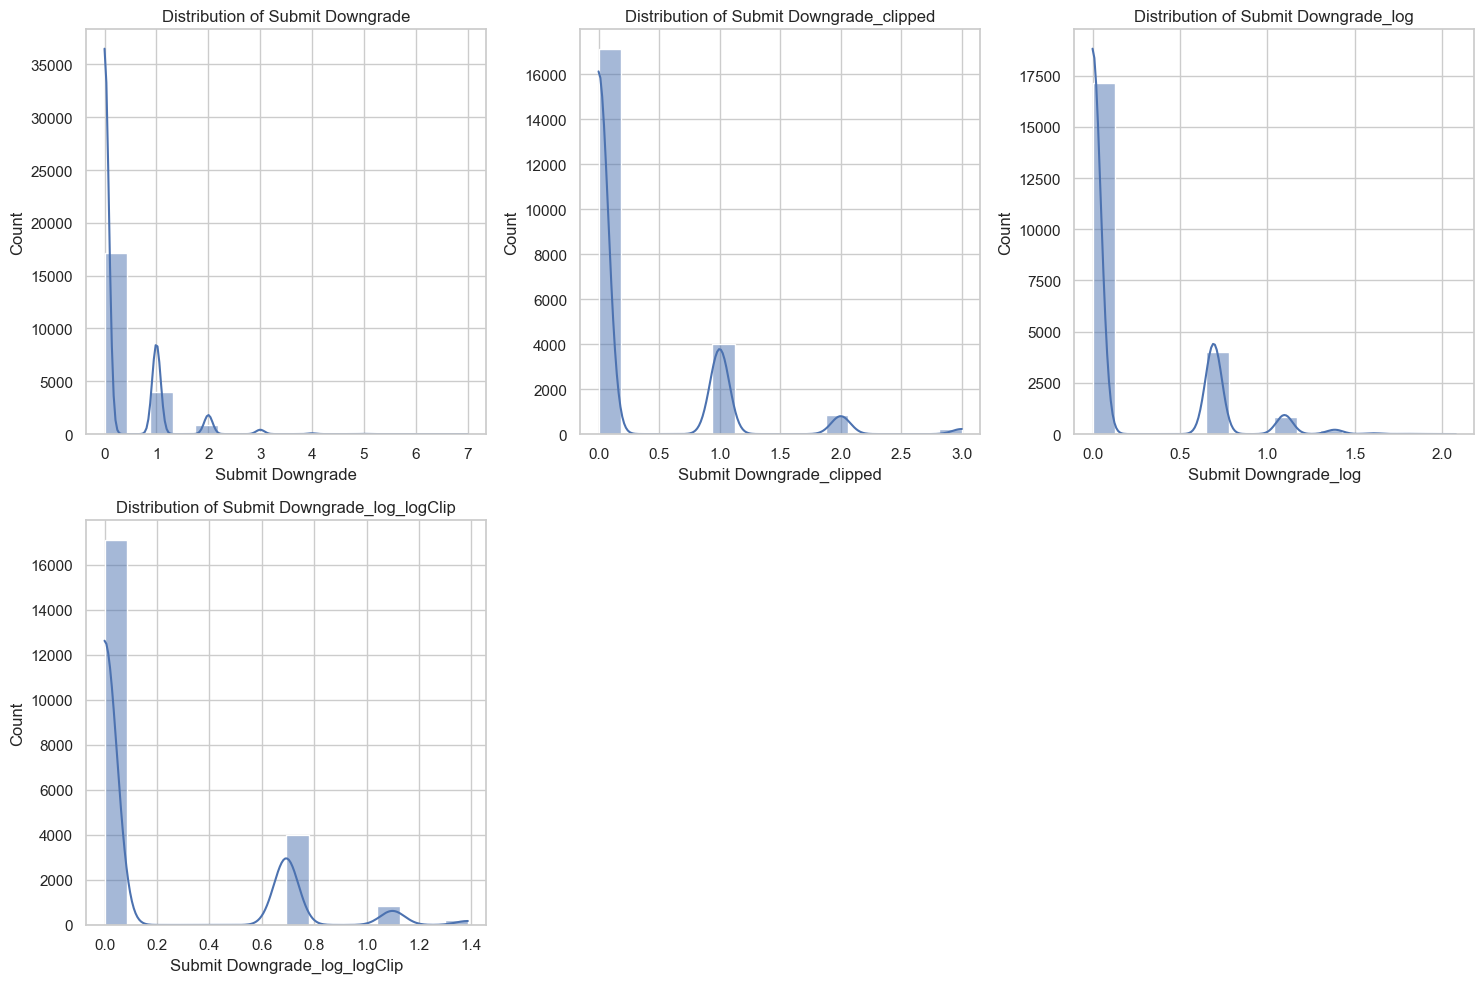

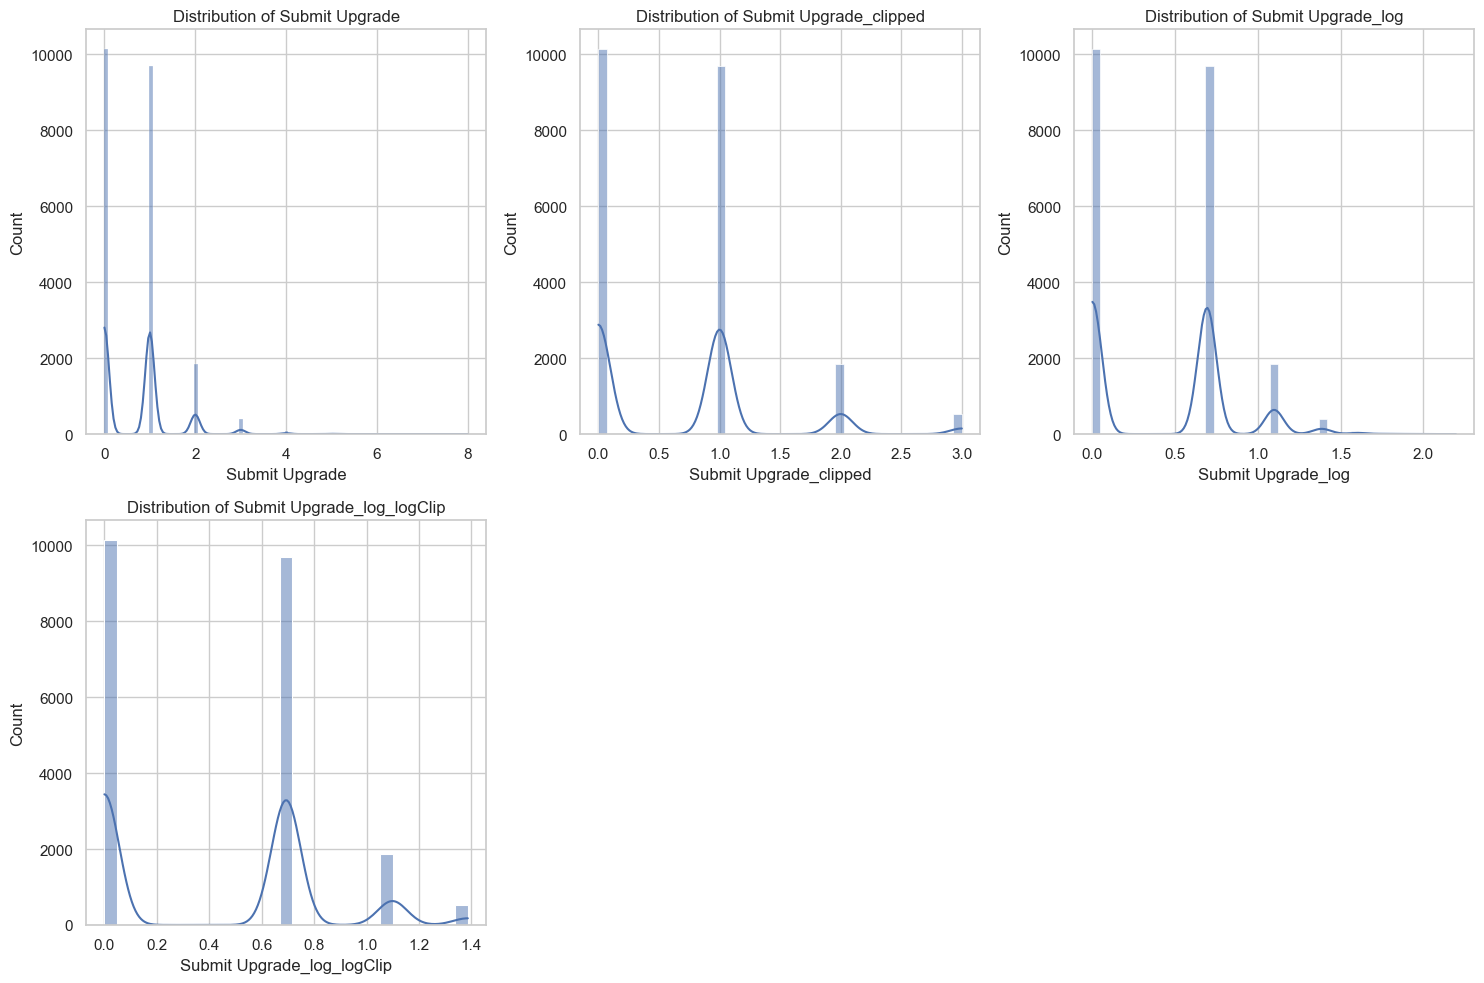

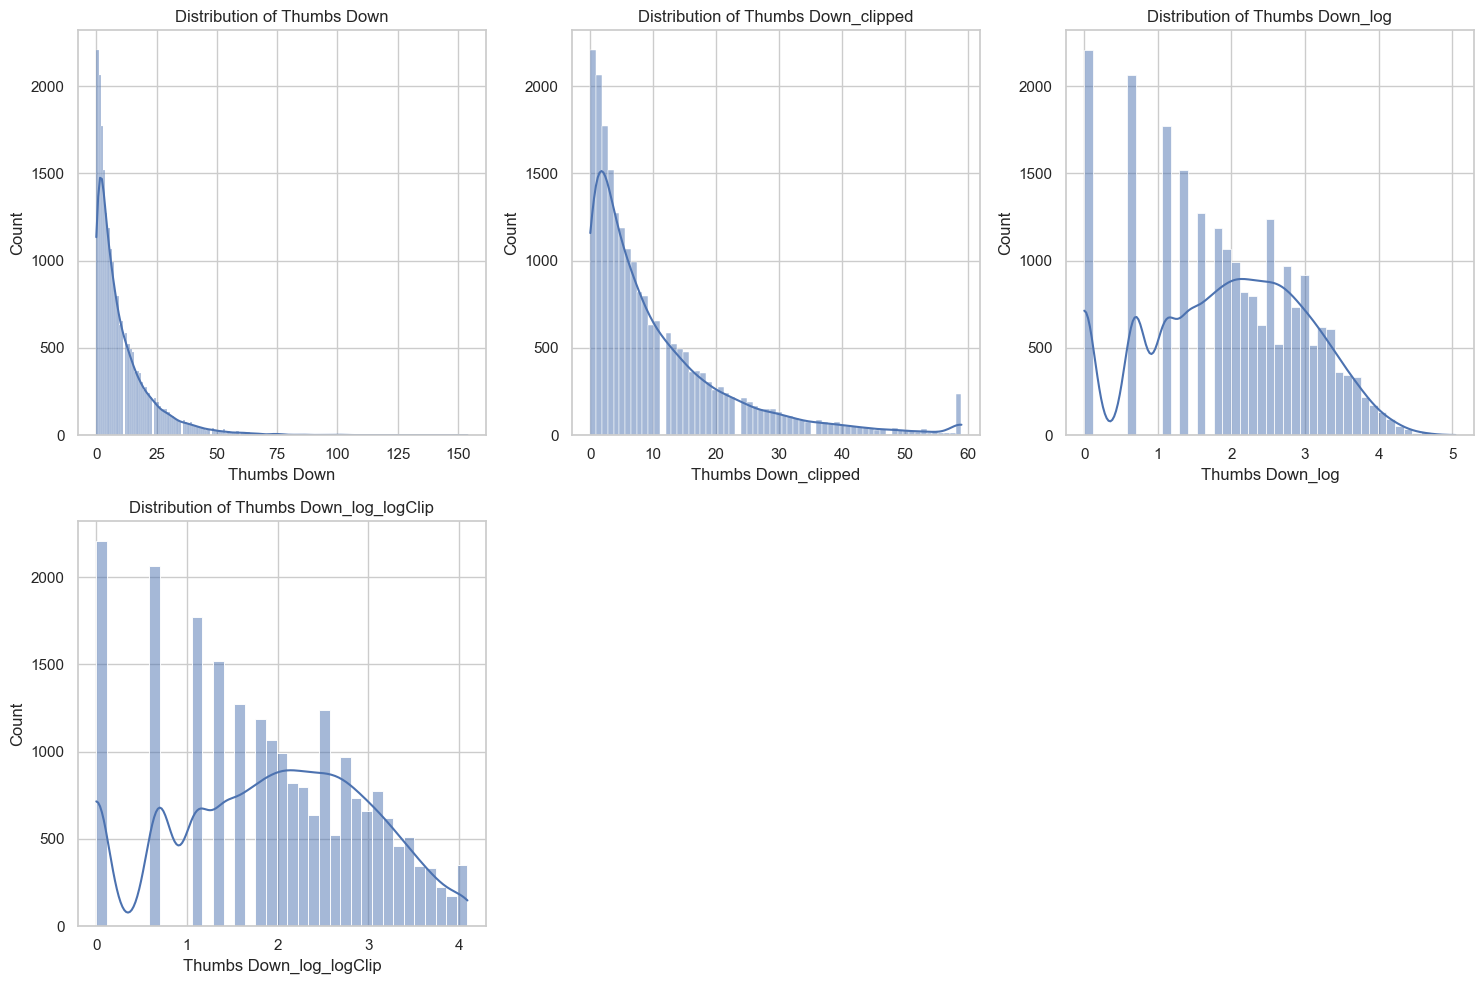

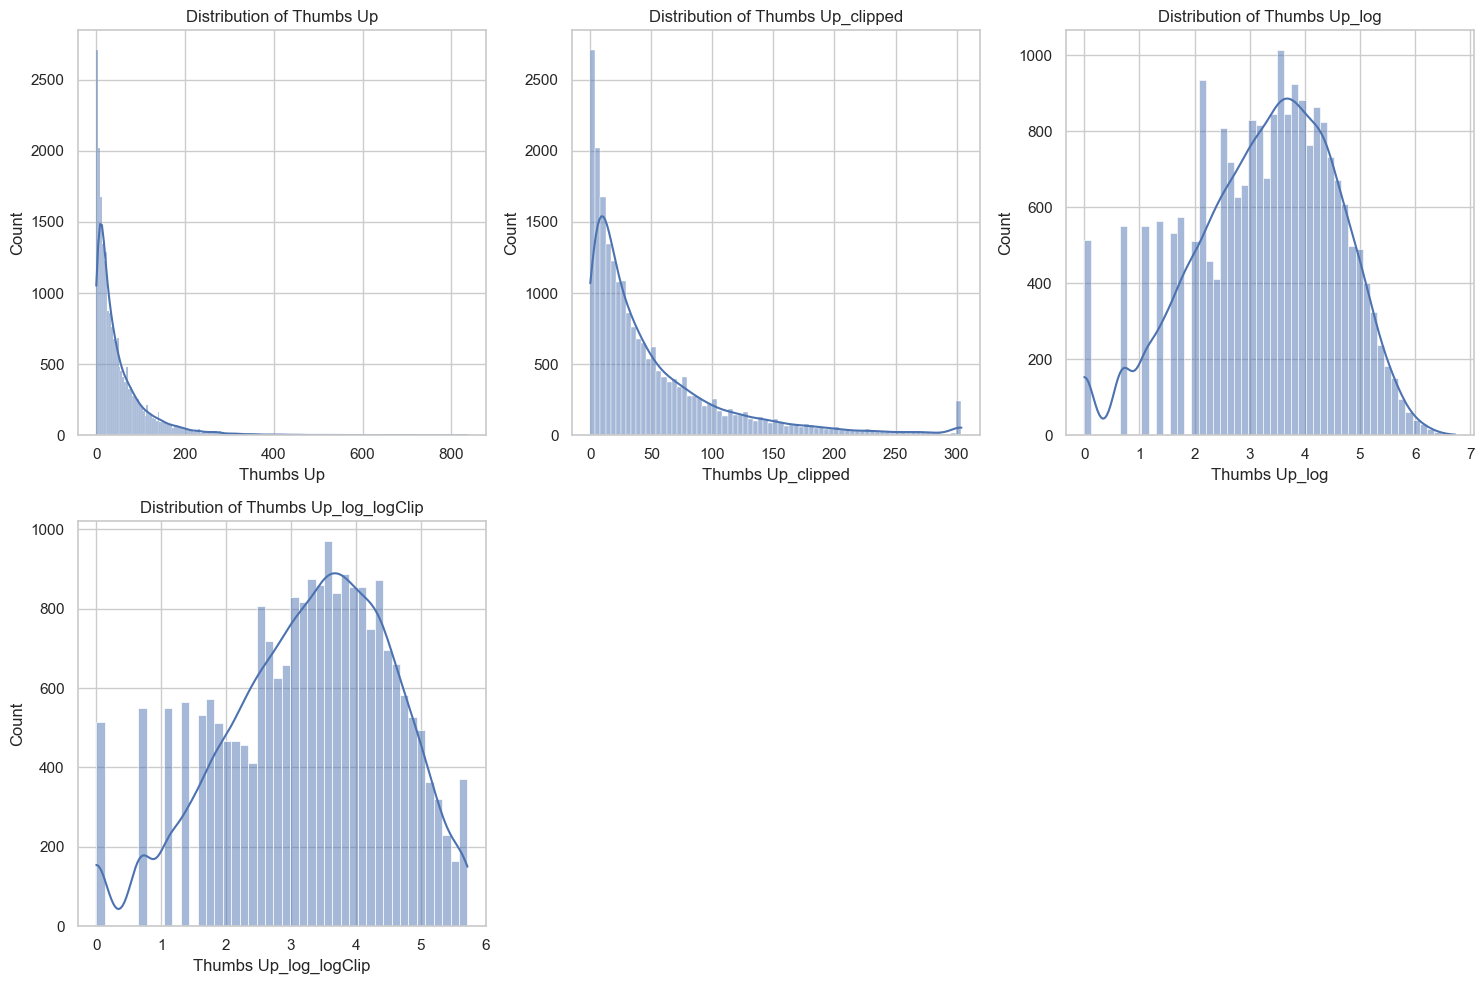

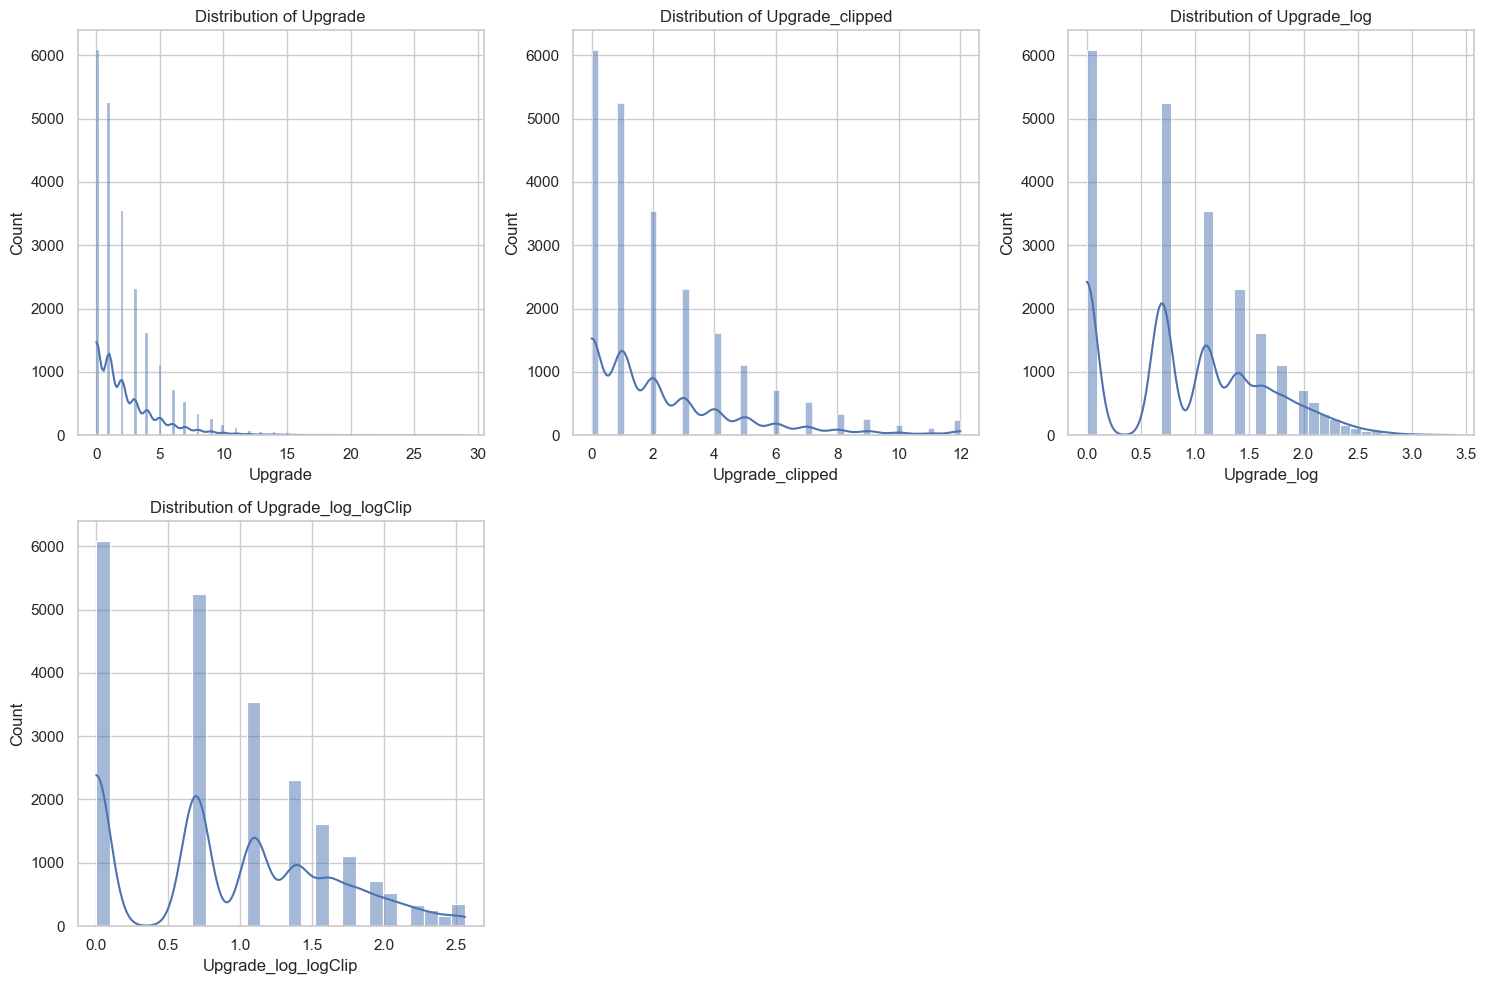

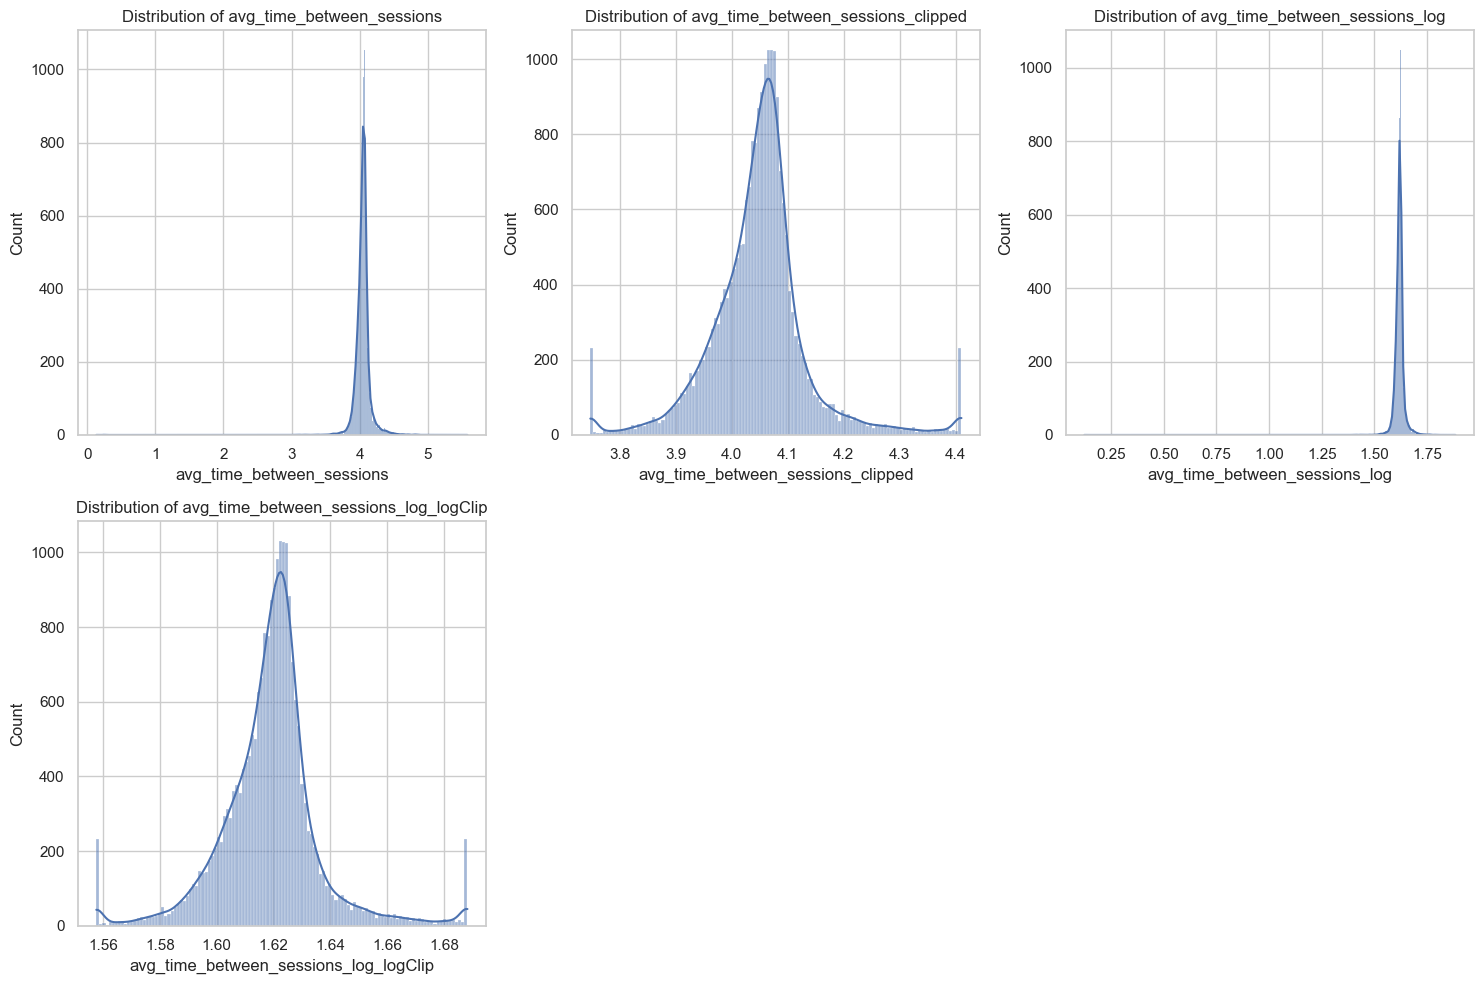

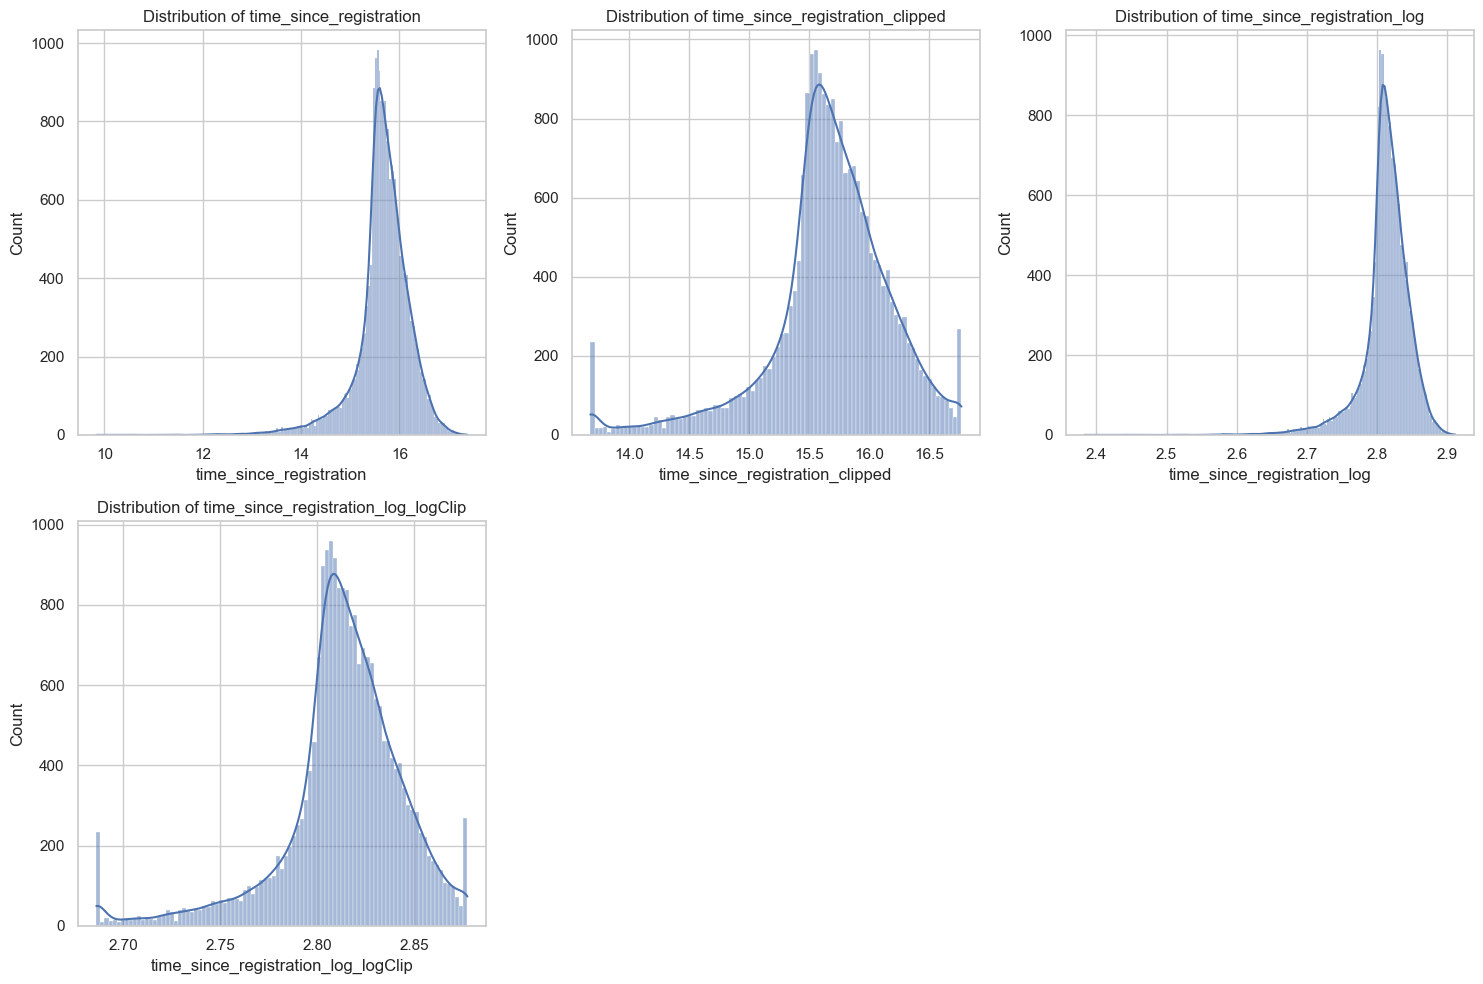

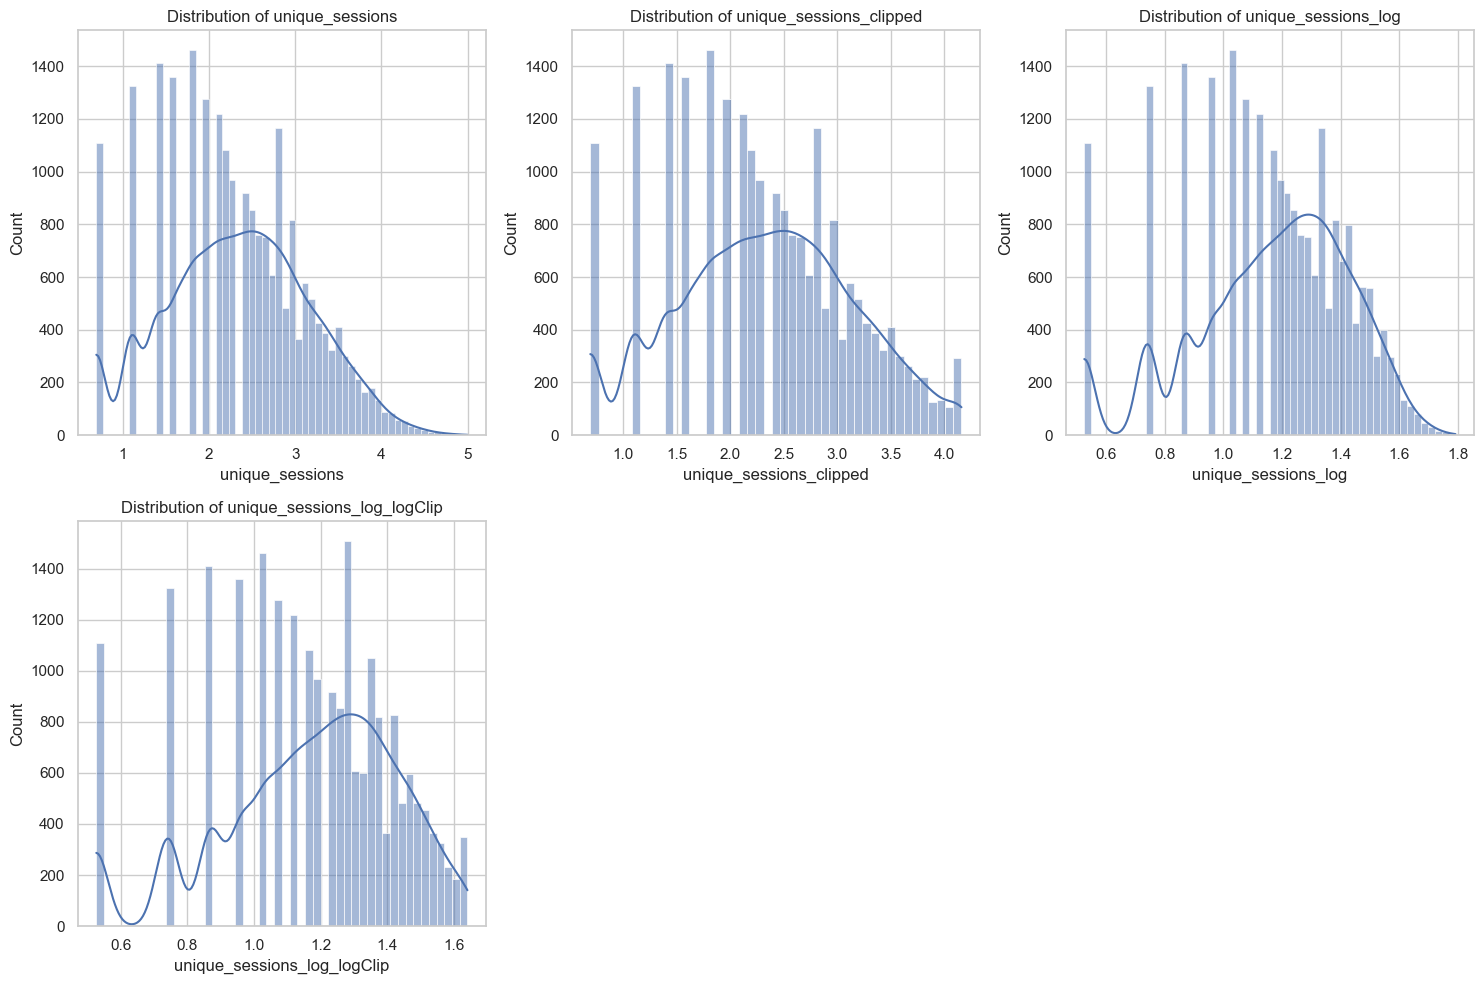

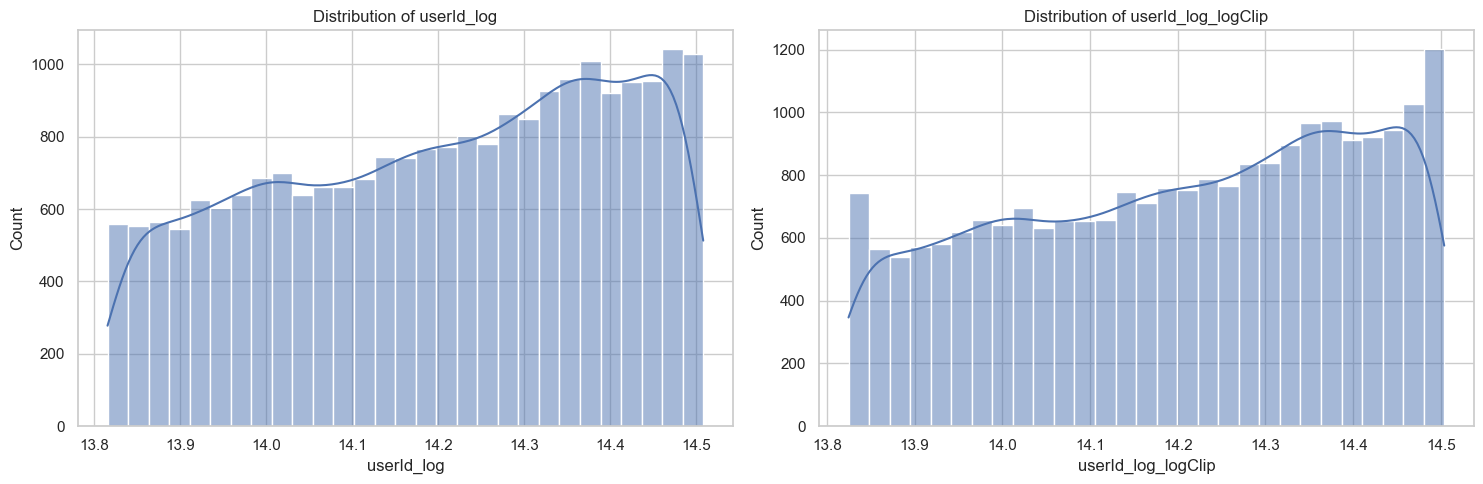

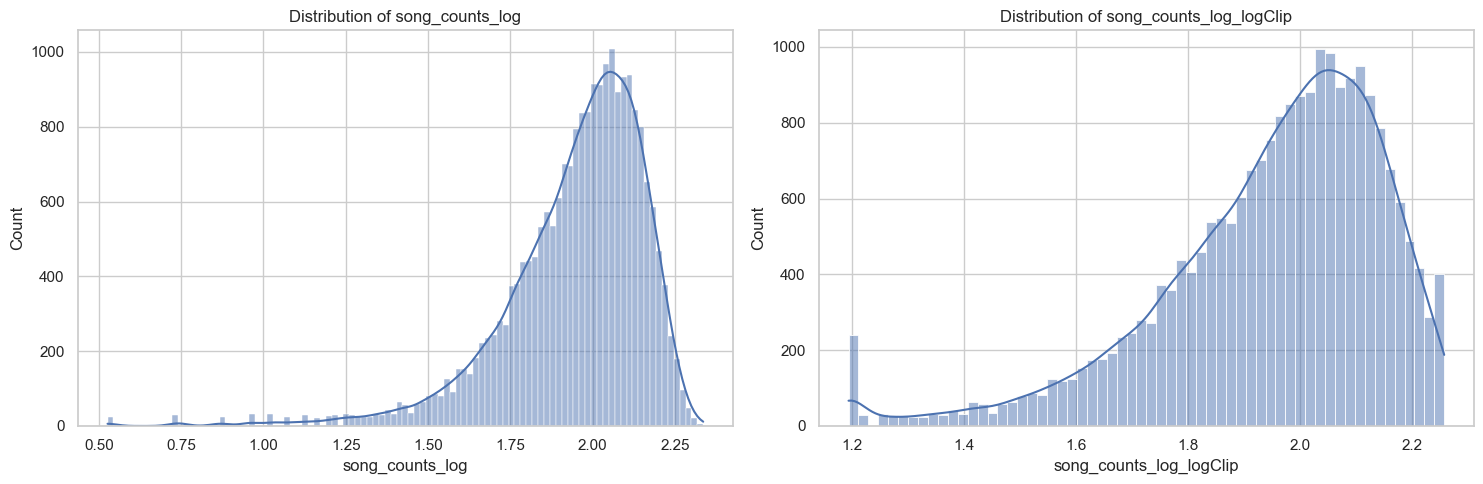

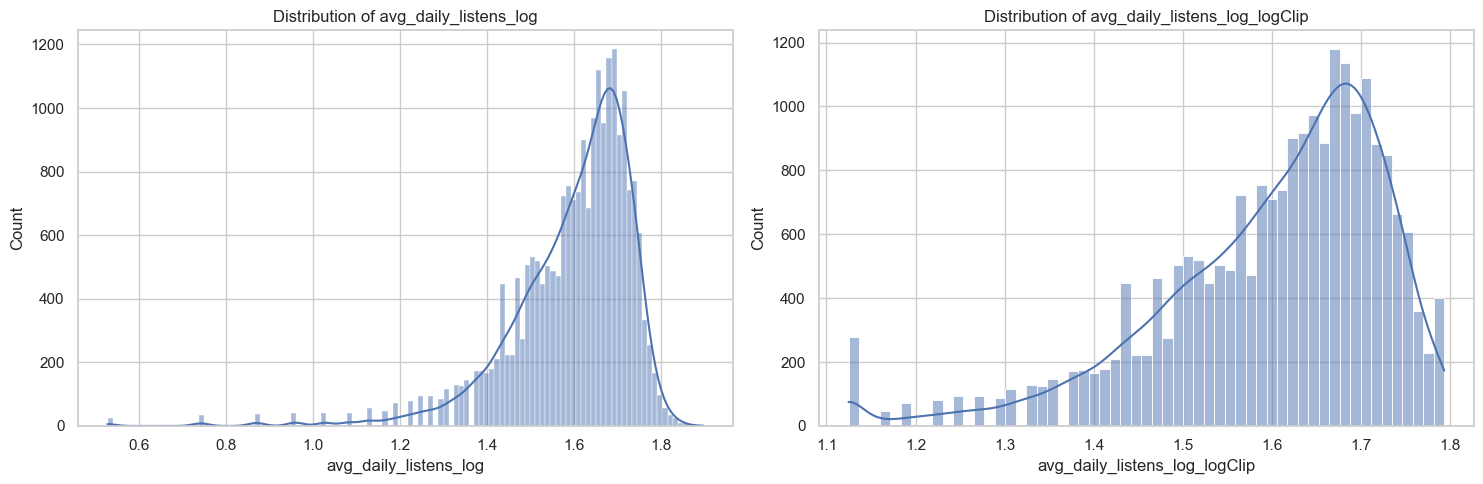

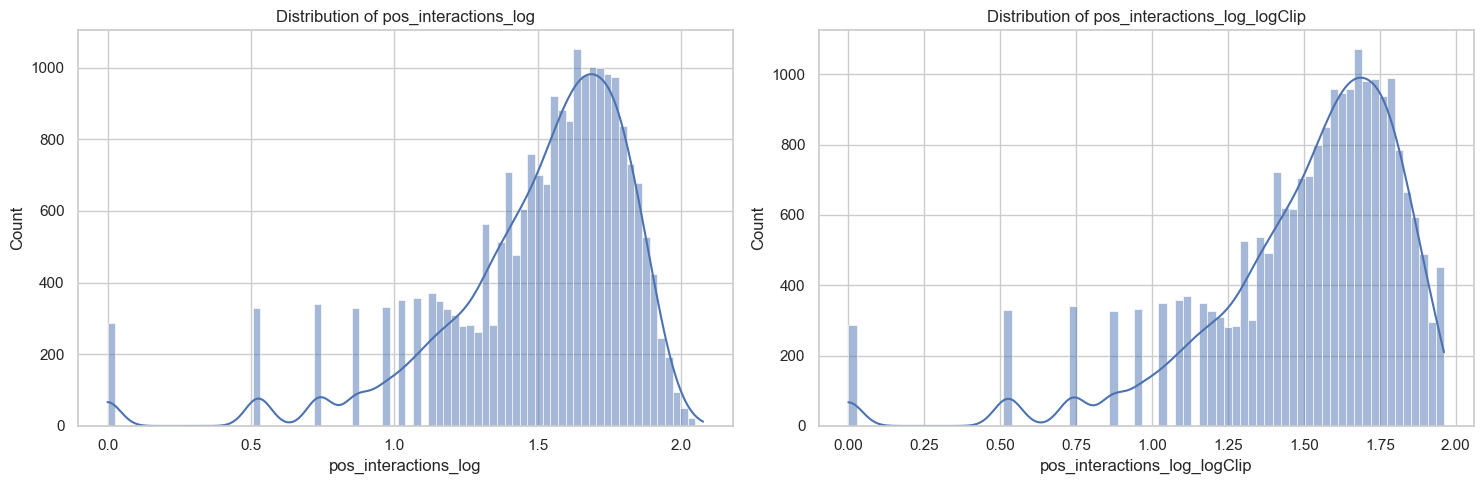

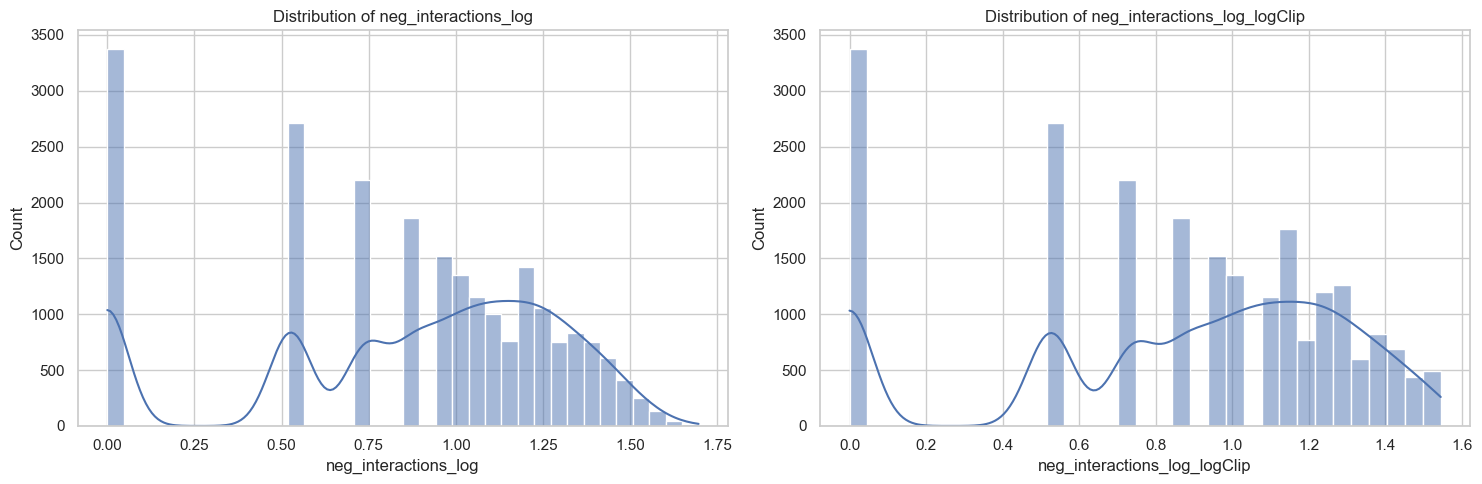

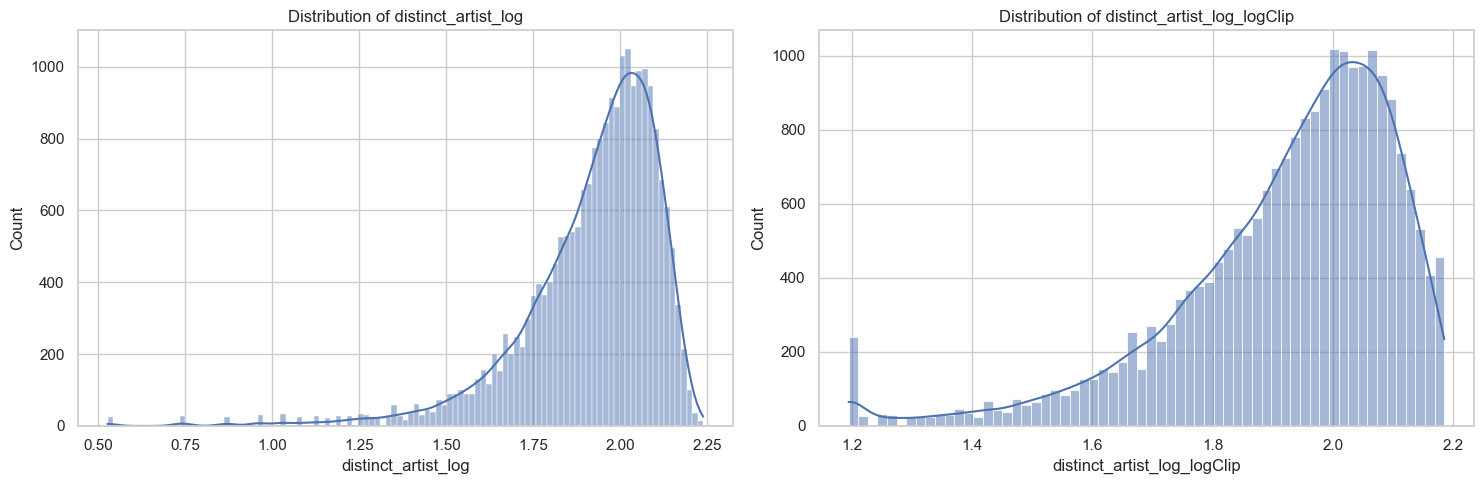

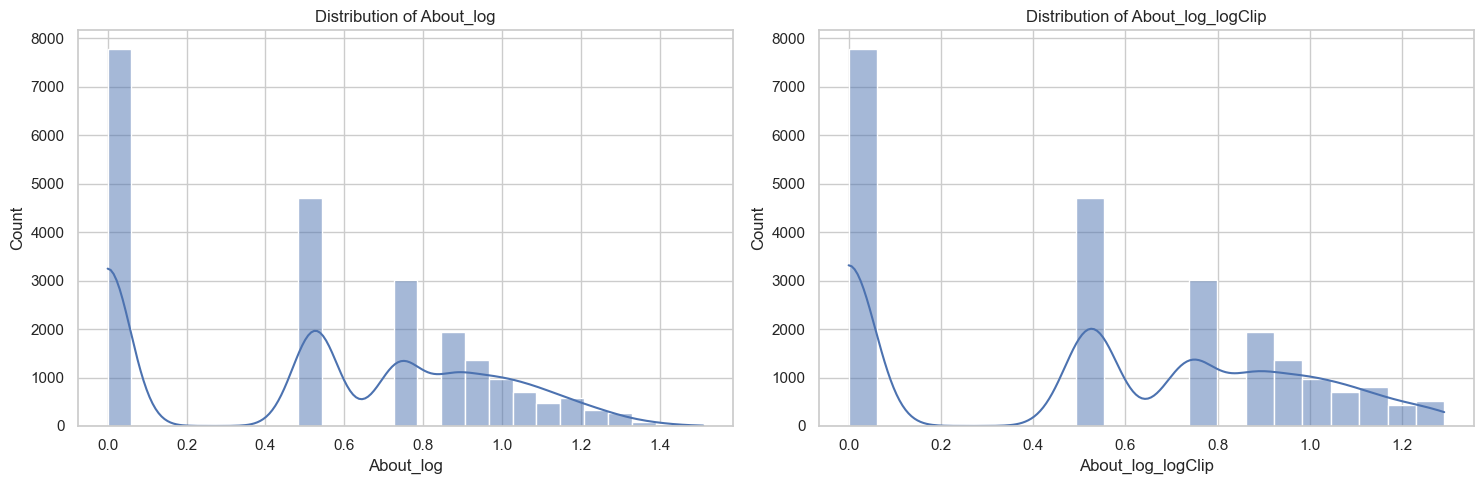

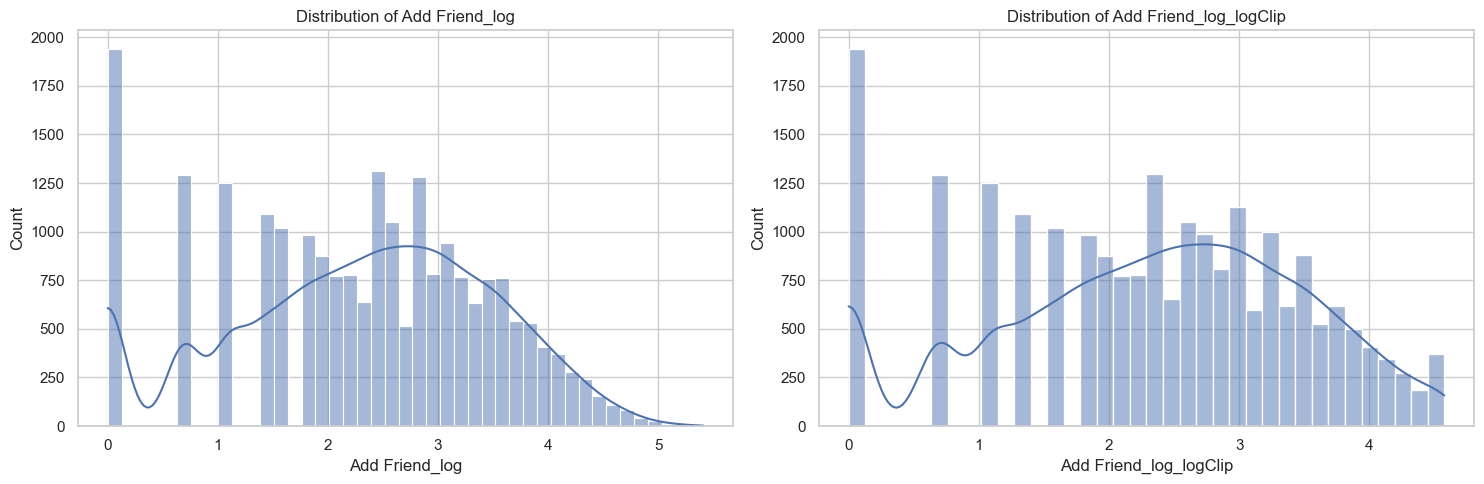

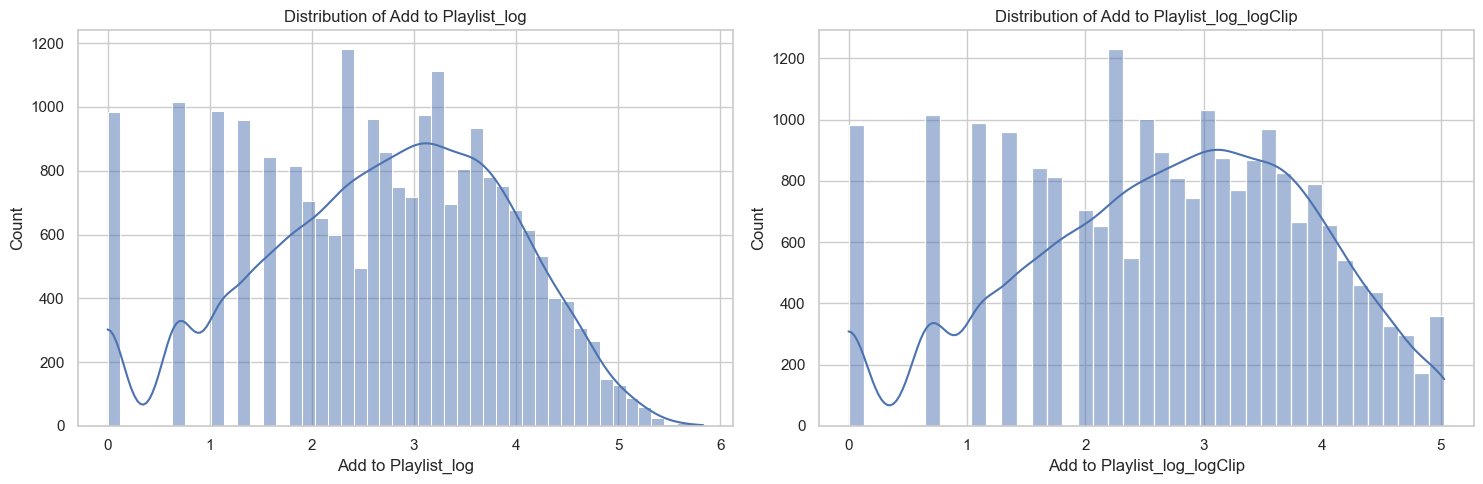

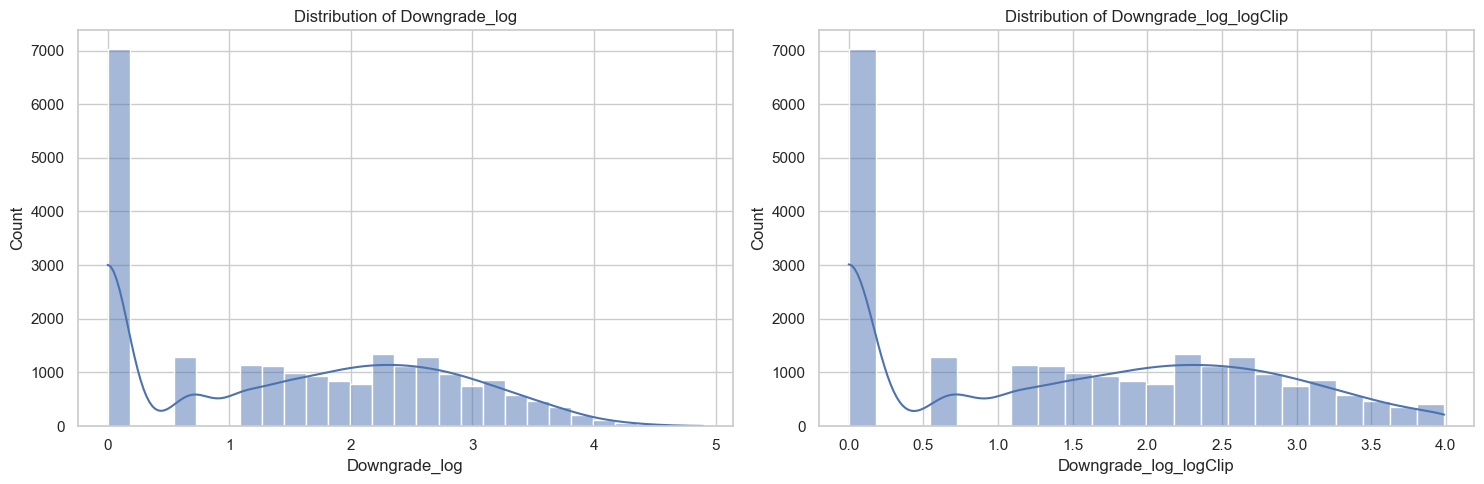

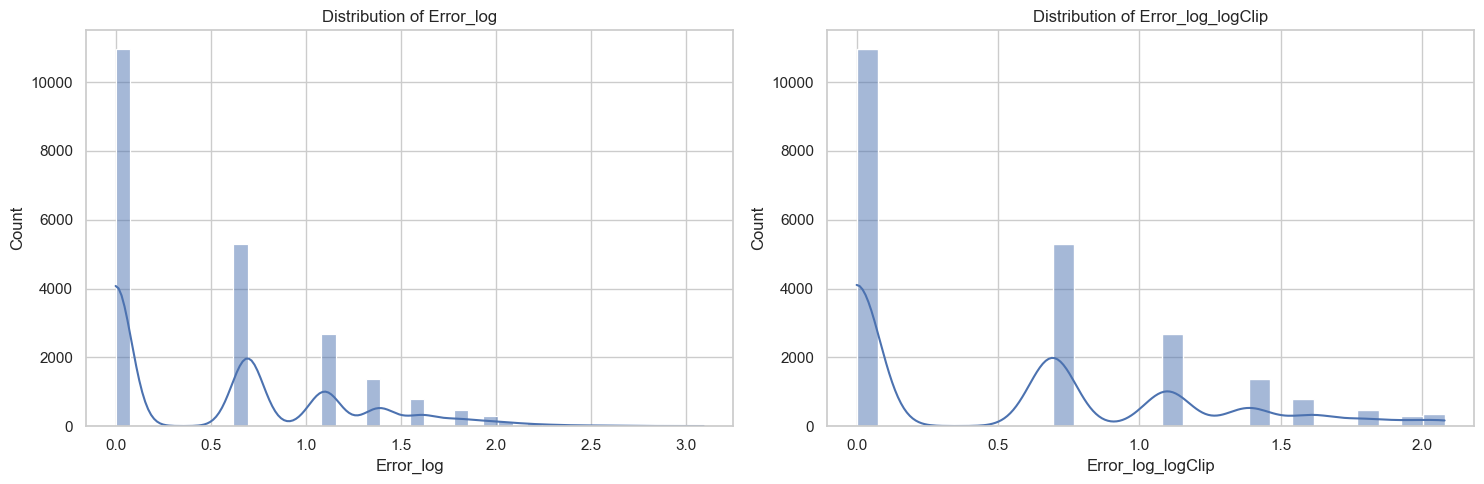

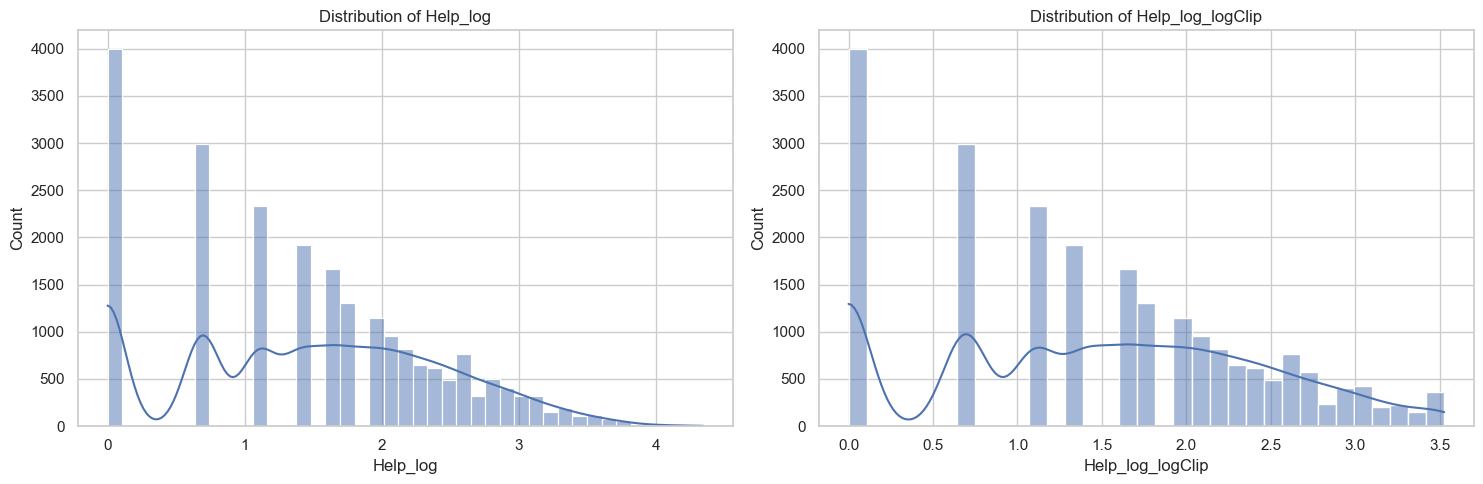

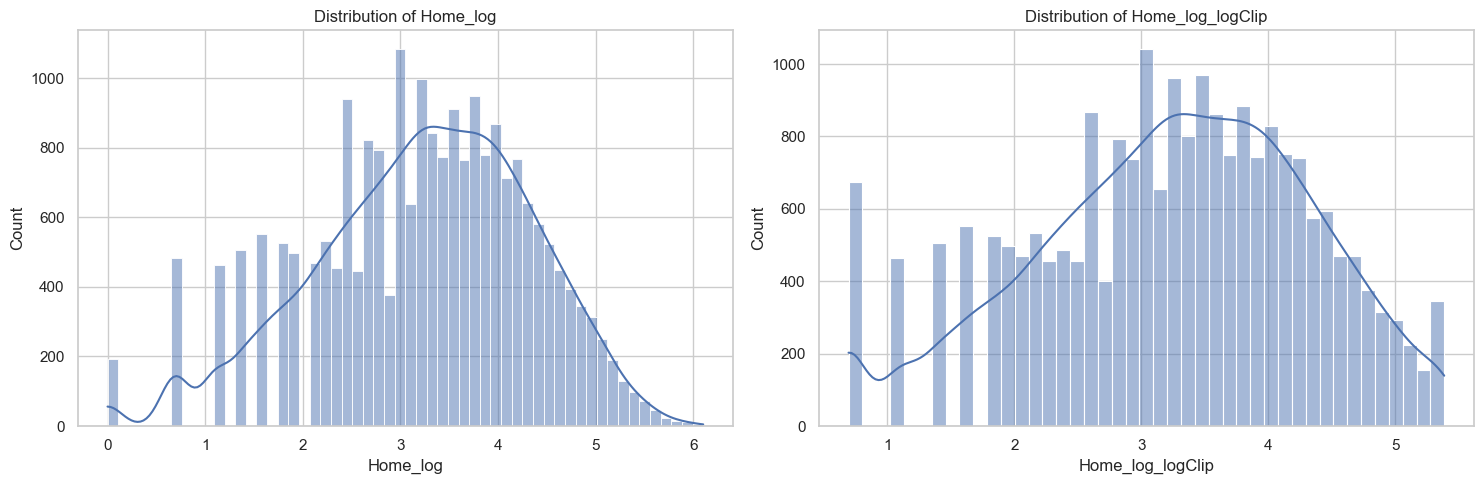

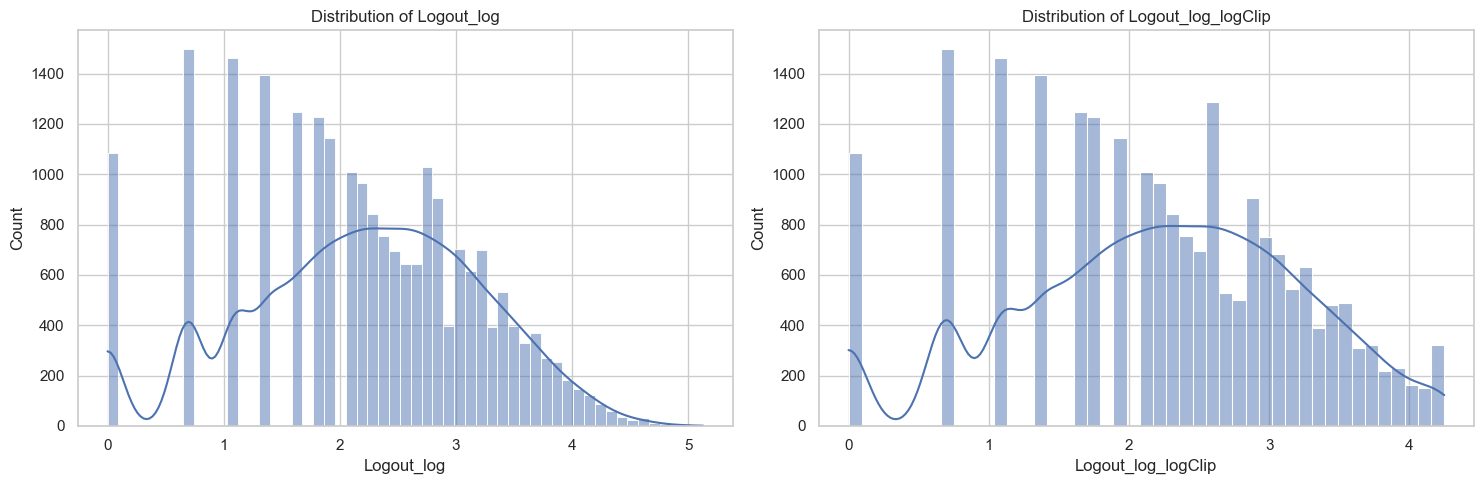

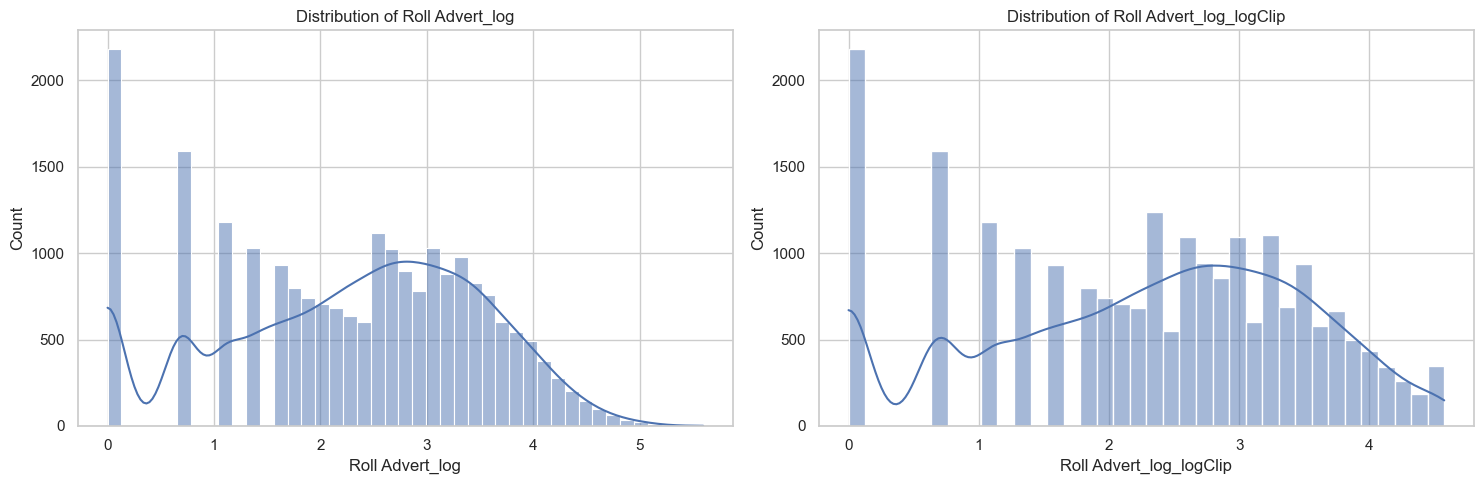

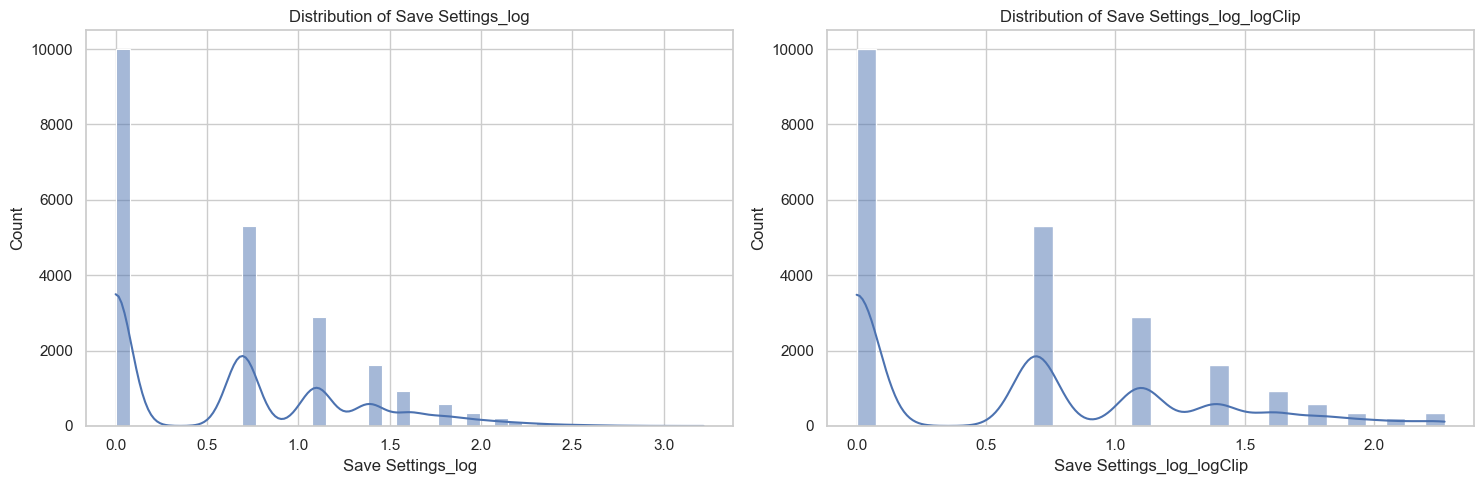

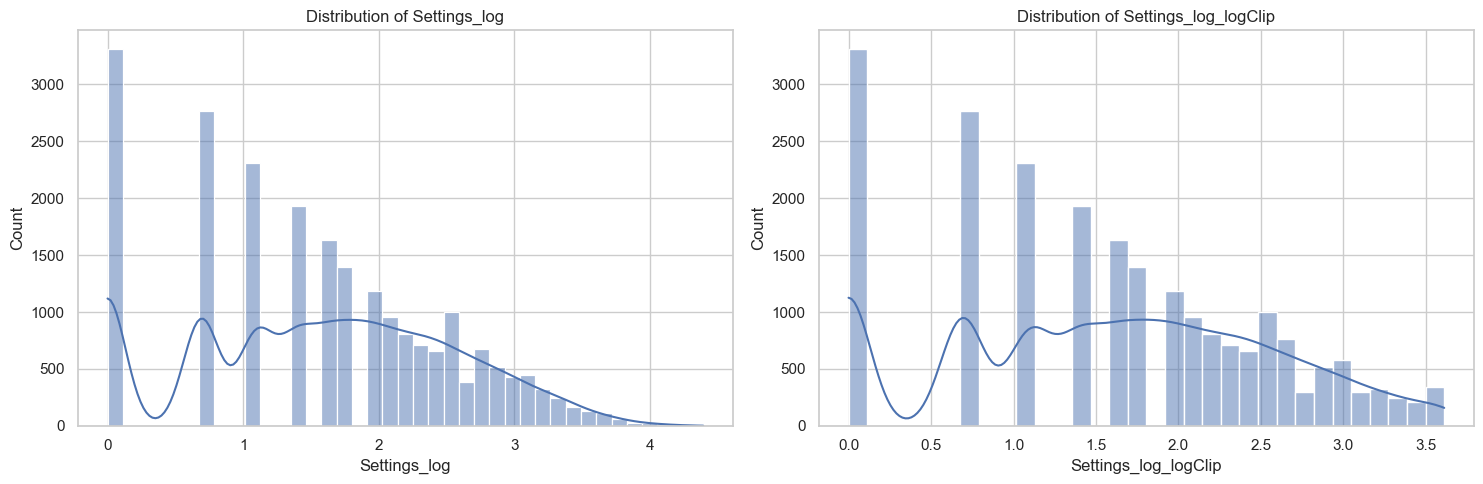

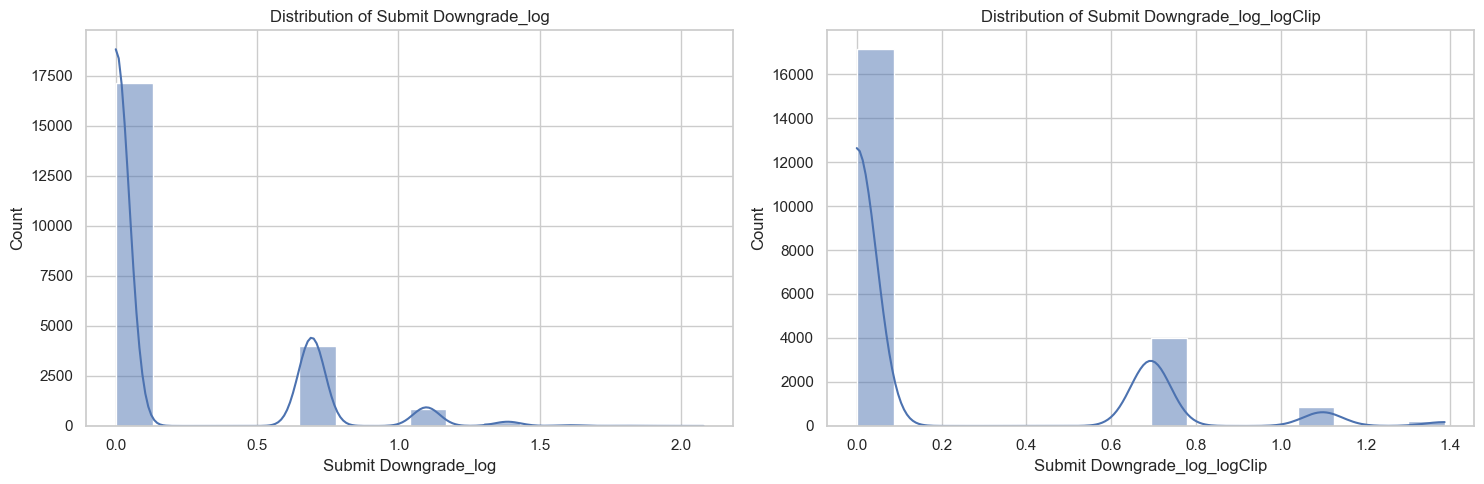

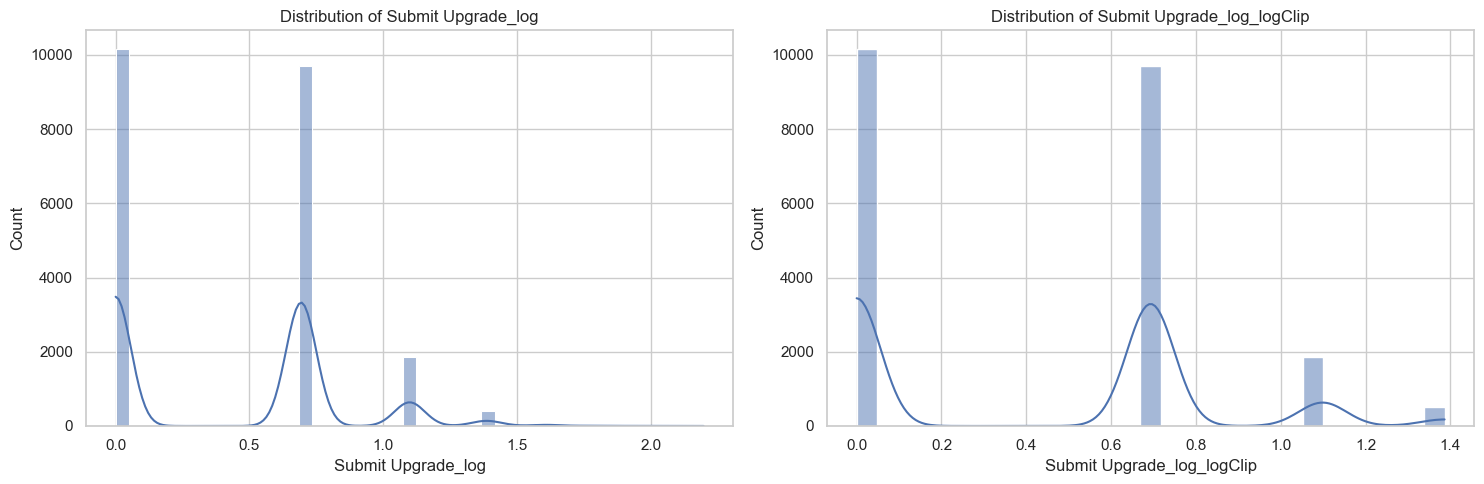

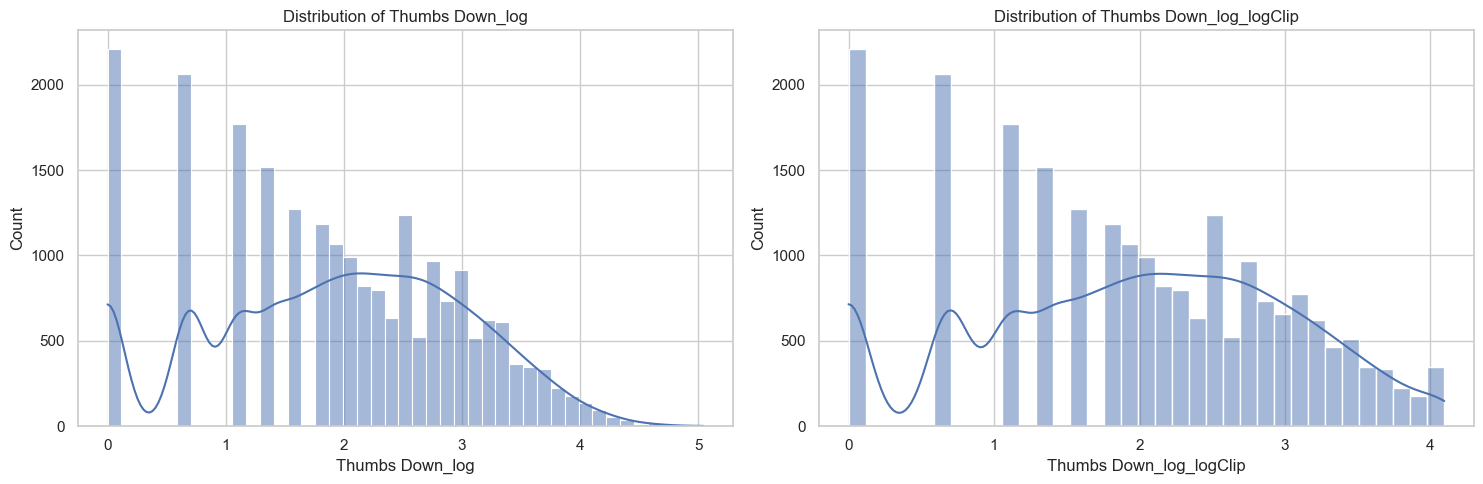

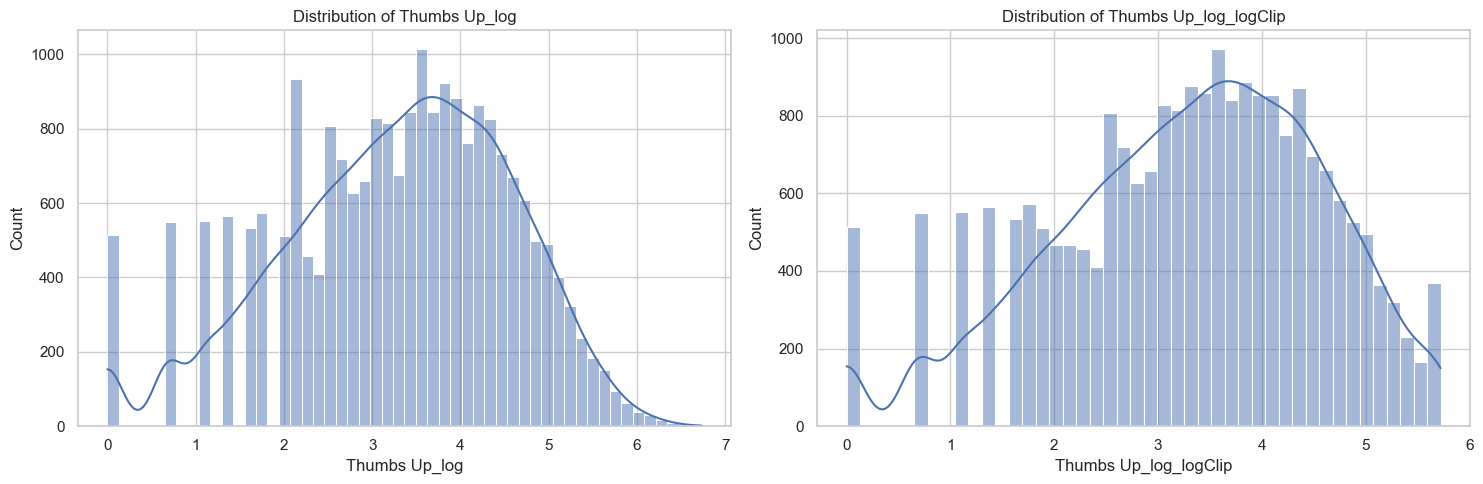

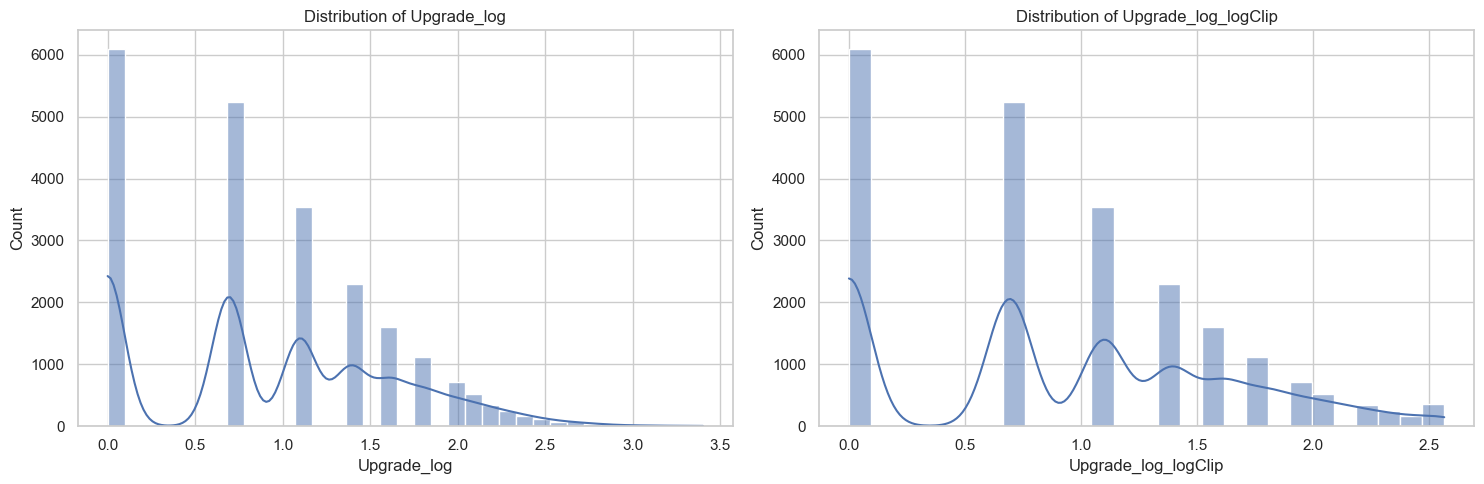

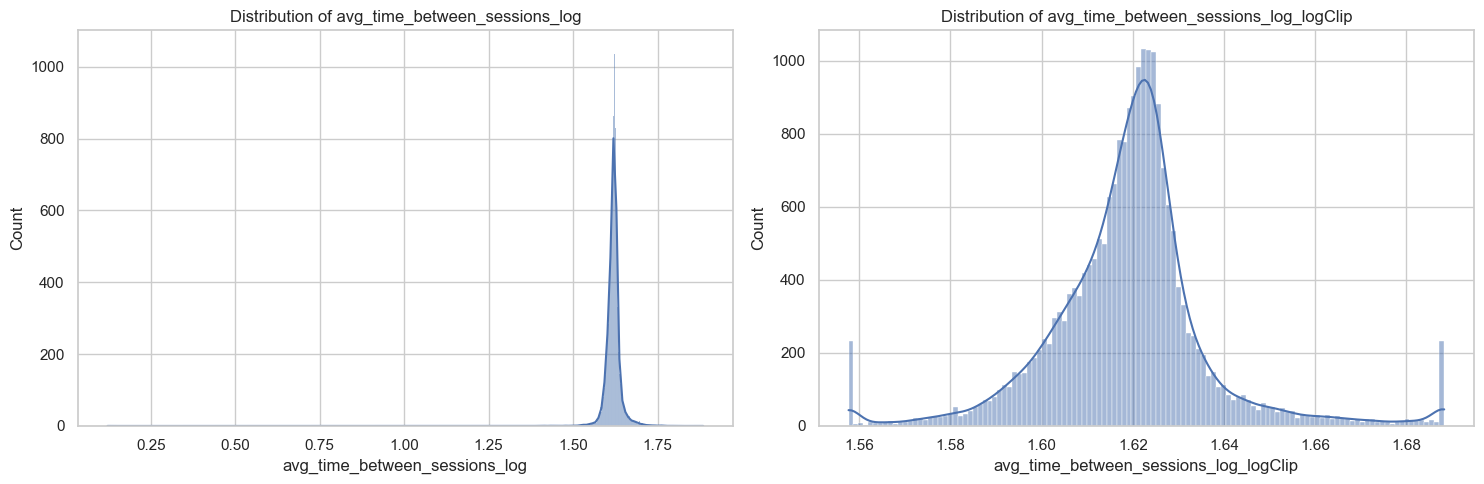

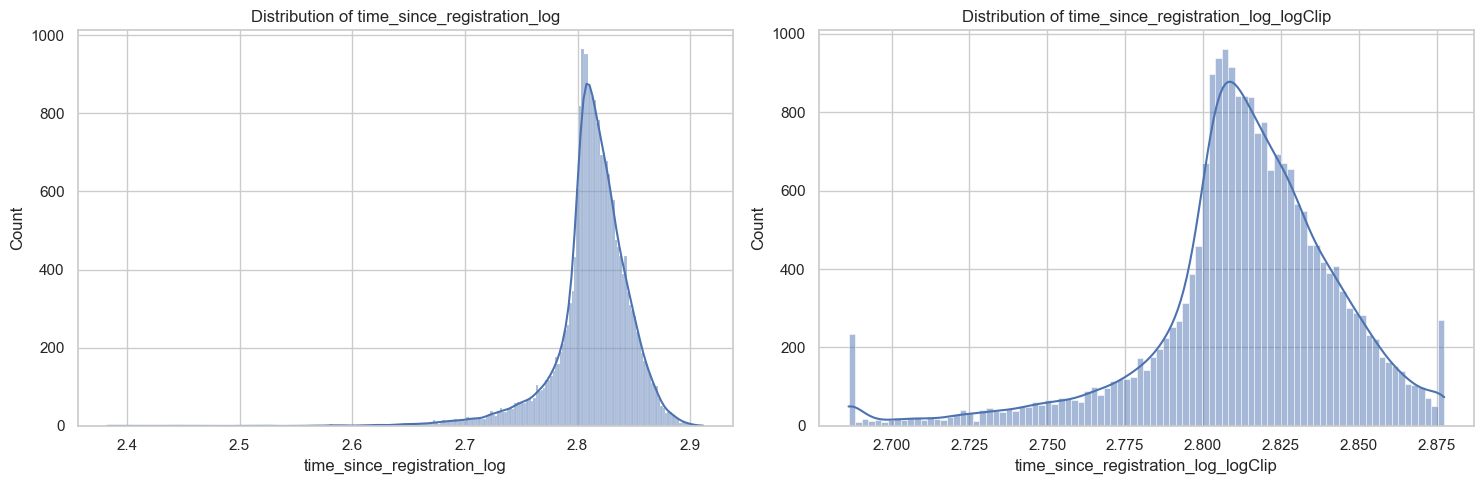

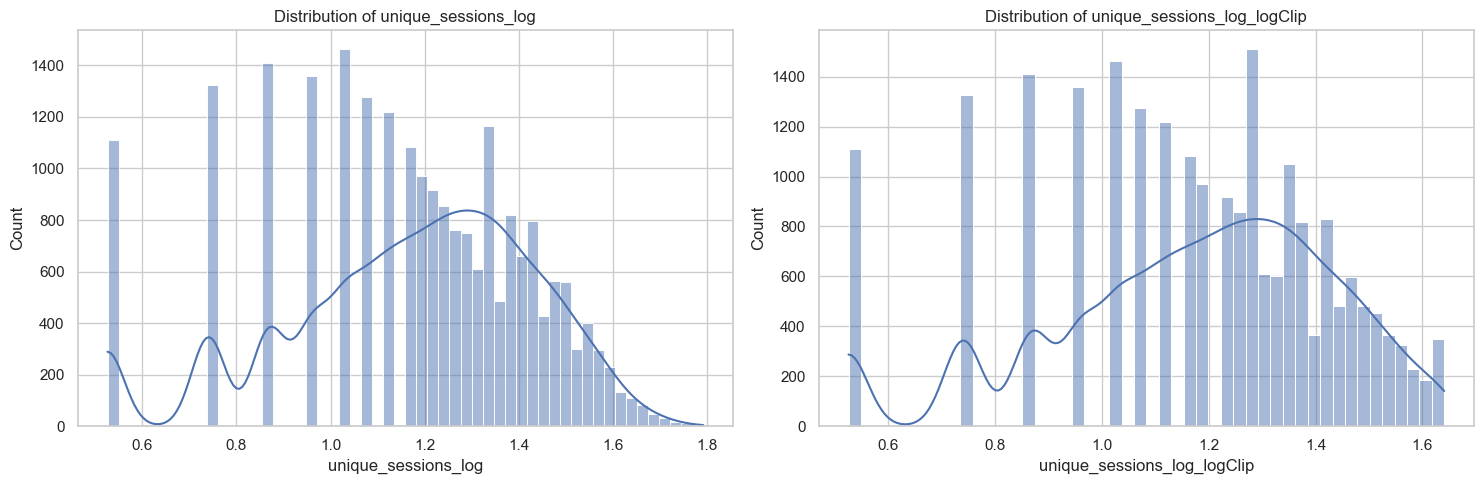

userId  label  song_counts  avg_daily_listens  level_flag  \
0      1000280      1     6.930495           3.850148           0   
1      1000353      1     5.480639           4.110874           1   
2      1000503      1     5.257495           4.174387           1   
3      1001129      0     6.324359           3.951244           0   
4      1001246      0     6.533789           3.663562           1   
...        ...    ...          ...                ...         ...   
22225  1991581      0     6.901737           4.430817           1   
22226  1994379      0     5.356586           3.583519           0   
22227  1996355      0     5.476464           3.555348           1   
22228  1996408      0     7.474205           4.356709           1   
22229  1997088      1     6.949856           3.970292           1   

       pos_interactions  neg_interactions  distinct_artist     About  \
0              4.615121          2.484907         6.643790  0.000000   
1              3.295837          1.098612         5.398163  0.000000   
2              2.302585          1.098612         5.164786  0.000000   
3              3.871201          2.197225         6.133398  1.098612   
4              4.356709          2.197225         6.338594  1.791759   
...                 ...               ...              ...       ...   
22225          4.262680          1.791759         6.655440  1.386294   
22226          2.833213          0.000000         5.220356  1.098612   
22227          3.258097          1.098612         5.398163  1.098612   
22228          5.429346          3.044522         7.108244  1.609438   
22229          4.521789          1.945910         6.687109  1.386294   

       Add Friend  ...  Save Settings_log_logClip  Settings_log_logClip  \
0            14.0  ...                   0.693147              2.302585   
1             9.0  ...                   0.693147              0.693147   
2             3.0  ...                   0.000000              0.693147   
3            12.0  ...                   0.693147              1.609438   
4            10.0  ...                   1.609438              1.945910   
...           ...  ...                        ...                   ...   
22225        18.0  ...                   1.098612              1.609438   
22226         5.0  ...                   0.000000              1.386294   
22227         4.0  ...                   0.000000              1.098612   
22228        38.0  ...                   0.693147              2.397895   
22229        18.0  ...                   1.098612              2.484907   

       Submit Downgrade_log_logClip  Submit Upgrade_log_logClip  \
0                          0.693147                    0.693147   
1                          0.000000                    0.000000   
2                          0.000000                    0.000000   
3                          0.693147                    0.000000   
4                          0.693147                    0.693147   
...                             ...                         ...   
22225                      0.000000                    0.000000   
22226                      0.000000                    0.000000   
22227                      0.000000                    0.693147   
22228                      0.000000                    0.000000   
22229                      0.000000                    0.693147   

       Thumbs Down_log_logClip  Thumbs Up_log_logClip  Upgrade_log_logClip  \
0                     3.526361               3.988984             2.302585   
1                     1.609438               2.639057             0.000000   
2                     1.386294               1.386294             0.000000   
3                     2.397895               3.258097             0.000000   
4                     2.197225               4.094345             0.693147   
...                        ...                    ...                  ...   
22225                 2.302585               3.784190         

In [83]:

def log_and_clip(df, display =False):
    df = df.copy()

    def soft_clip(x, threshold=3,tolerance=1e-10):
        mask = np.isclose(x, 0, atol=0)
        return np.where(mask, x, np.tanh(x / threshold) * threshold)
    for col in df.columns:
        if df[col].nunique() > 2:
            # Clip and log for original columns
            df[col + '_clipped'] = df[col].clip(lower=df[col].quantile(0.01), upper=df[col].quantile(0.99))
            df[col + '_log'] = np.log1p(df[col])
            # df[col + '_softClip'] = soft_clip(df[col])

    for col in df.columns:
        if col.endswith('_log'):
            if df[col].nunique() > 2:
                df[col + '_logClip'] = df[col].clip(lower=df[col].quantile(0.01), upper=df[col].quantile(0.99))



    if display == True:
        for val in df.columns:
            feat_columns = [col for col in df.columns if col.startswith(val)]
            if len(feat_columns) > 1:
                display_distributions(df[feat_columns])

    return df


log_and_clip(df,True)

## Skewness

In [84]:
def check_skew(df,display=True):
    skew_df =df.copy()
    skew ={}
    for col in df.columns:
        skew[col+ "_skew"] = df[col].skew()
    skew_df = pd.DataFrame(data=[skew.values()], columns=skew.keys()).transpose().sort_values(by = 0 , ascending=False)
    if display:
        skew_df.plot(kind= "bar")

    return skew_df


0
browser_Google_skew             19.673708
browser_Chromium_skew           10.825265
device_Ubuntu_skew               5.417282
device_Linux_skew                5.199820
browser_Mobile Safari_skew       4.319092
device_iOS_skew                  4.186089
browser_IE_skew                  4.054333
Thumbs Up_skew                   2.810798
Submit Downgrade_skew            2.551467
Downgrade_skew                   2.499003
Roll Advert_skew                 2.485424
Add Friend_skew                  2.421644
Help_skew                        2.414194
Add to Playlist_skew             2.413992
Error_skew                       2.412888
Thumbs Down_skew                 2.402744
Save Settings_skew               2.402489
Logout_skew                      2.396174
Home_skew                        2.390382
Settings_skew                    2.320793
Upgrade_skew                     2.195391
browser_Safari_skew              2.129655
Submit Upgrade_skew              1.340059
label_skew                       1.317735
browser_Firefox_skew             1.275701
About_skew                       0.474437
device_Mac OS X_skew             0.406172
device_Windows_skew              0.054545
unique_sessions_skew             0.015029
neg_interactions_skew            0.005972
device_Other_skew                0.000000
Submit Registration_skew         0.000000
Login_skew                       0.000000
browser_Other_skew               0.000000
Register_skew                    0.000000
userId_skew                     -0.001930
browser_Chrome_skew             -0.098371
level_flag_skew                 -0.470469
pos_interactions_skew           -0.510936
song_counts_skew                -0.683384
distinct_artist_skew            -0.917202
avg_daily_listens_skew          -1.082066
time_since_registration_skew    -1.561143
avg_time_between_sessions_skew  -7.820887

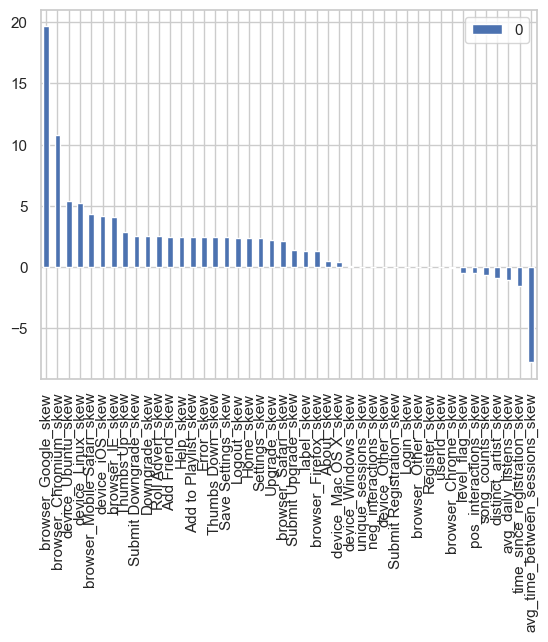

In [85]:
check_skew(df)

0
Submit Downgrade_log_skew            1.663739
Error_log_skew                       0.786917
Save Settings_log_skew               0.683683
Submit Upgrade_log_skew              0.319296
Upgrade_log_skew                     0.260466
Downgrade_log_skew                   0.124150
Help_log_skew                        0.065784
Settings_log_skew                    0.003136
About_log_skew                      -0.021361
Thumbs Down_log_skew                -0.147277
Logout_log_skew                     -0.232289
userId_log_skew                     -0.239220
Add Friend_log_skew                 -0.282985
Roll Advert_log_skew                -0.305006
Add to Playlist_log_skew            -0.317326
Home_log_skew                       -0.386577
Thumbs Up_log_skew                  -0.396554
unique_sessions_log_skew            -0.585120
neg_interactions_log_skew           -0.705901
song_counts_log_skew                -1.666299
pos_interactions_log_skew           -1.711429
distinct_artist_log_skew            -1.911635
time_since_registration_log_skew    -1.936916
avg_daily_listens_log_skew          -1.959344
avg_time_between_sessions_log_skew -20.512296

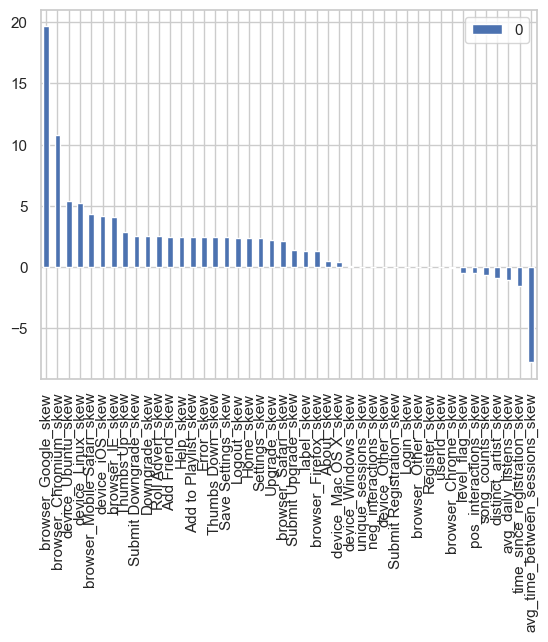

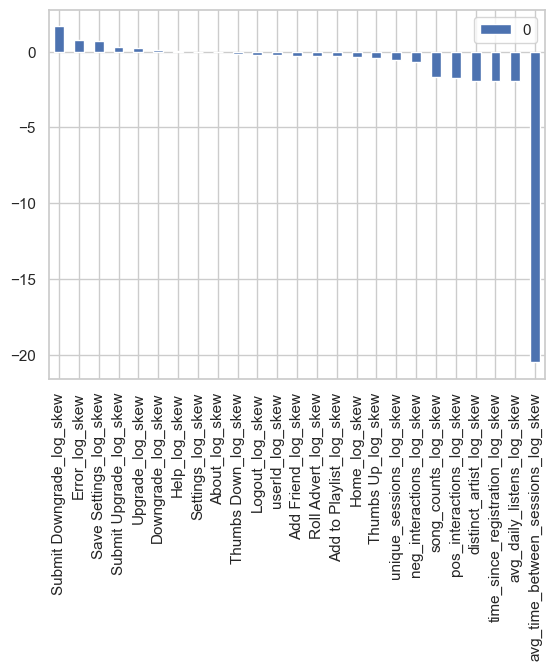

In [86]:
clip_log_df = log_and_clip(df,False) 
log_cols = [col for col in clip_log_df.columns if col.endswith("_log")]
clip_cols = [col for col in clip_log_df.columns if col.endswith("_clipped")]
clipLog_cols = [col for col in clip_log_df.columns if col.endswith("_logClip")]
softClip_cols = [col for col in clip_log_df.columns if col.endswith("_softClip")]

check_skew(df)
check_skew(clip_log_df[log_cols])
# check_skew(clip_log_df[clip_cols])
# check_skew(clip_log_df[clipLog_cols])
# check_skew(clip_log_df[softClip_cols])

# Determining Outliers

Number of outliers for each feature:
Number of outliers for each feature:


Outliers  total samples
time_since_registration_log       377          22249
avg_daily_listens_log             278          22249
distinct_artist_log               243          22249
Submit Downgrade_log              239          22249
song_counts_log                   192          22249
Error_log                          70          22249
Save Settings_log                  61          22249
Submit Upgrade_log                 30          22249
About_log                          17          22249
Upgrade_log                        17          22249
Thumbs Up_log                       0          22249
Thumbs Down_log                     0          22249
pos_interactions_log                0          22249
Settings_log                        0          22249
Roll Advert_log                     0          22249
Add Friend_log                      0          22249
Logout_log                          0          22249
neg_interactions_log                0          22249
Help_log                            0          22249
Downgrade_log                       0          22249
Add to Playlist_log                 0          22249
Home_log                            0          22249

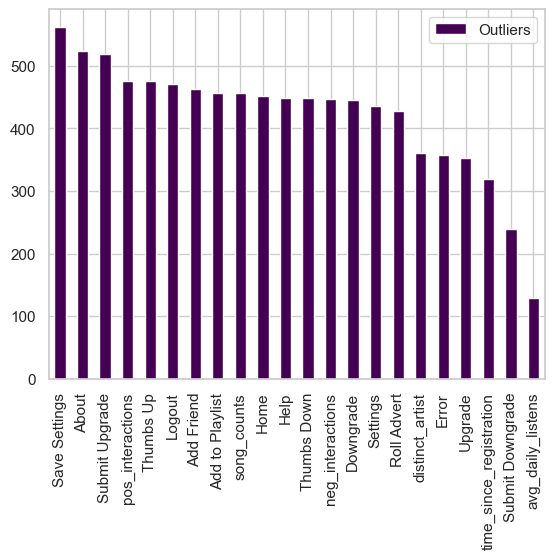

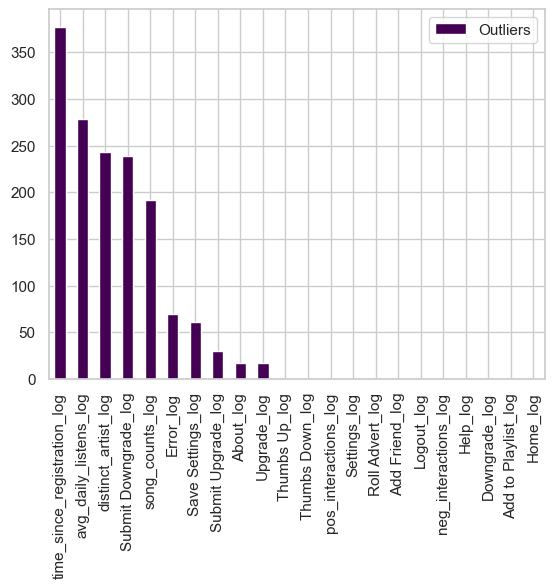

In [30]:


def detect_outliers(df,display =True):
    def count_outliers(series, threshold=3):
        z_scores = np.abs((series - series.mean()) / series.std())
        return (z_scores > threshold).sum()


    non_binary_cols = [col for col in df.columns if df[col].nunique() >2]
    outliers_count = df[non_binary_cols].apply(count_outliers)

    print("Number of outliers for each feature:")
    outliers_df = pd.DataFrame(data=outliers_count)
    outliers_df["total samples"] = len(df)
    outliers_df = outliers_df.sort_values(by=0, ascending=False).rename(columns={0: "Outliers"})

    # Create a stacked bar plot
    outliers_df.plot(kind="bar", y = "Outliers",colormap="viridis")

    if display == True:
    
        plt.legend(title="Total Samples", loc="upper left")

        plt.xlabel("Features")
        plt.ylabel("Count of Outliers")
        plt.title("Stacked Bar Graph of Outliers by Feature")

        plt.show()

    return outliers_df

detect_outliers(df,False)
detect_outliers(clip_log_df[log_cols], False)